# Import Library

In [202]:
# Basic Library
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Visualization Library
import matplotlib.pyplot as plt
import seaborn as sns

# Stat Library
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load Final Data

In [203]:
df = pd.read_csv('./data/final_df.csv')
df

,match_id,tier,timePlayed,teamId,win,champion_kills,monster_kills,building_kills,puuid,teamPosition,championName,takedownsBeforeJungleMinionSpawn,mainRole,summoner1Id,summoner2Id,kill_involve_ratio,deaths,cs,goldEarned,goldSpent,champExperience,item_duplication,totalDamageDealtToChampions,damageDealtToObjectives,totalTimeSpentDead,visionScore,abilityUses,skillshotsDodged,laneMinionsFirst10Minutes,alliedJungleMonsterKills,enemyJungleMonsterKills,kda,jungleCsBefore10Minutes,subRole,tower_involve_ratio,object_involve_ratio,average_transaction_margin_per_10min,delta_attack_stat,delta_attackSpeed,delta_defense_stat,delta_max_health,no_moving_minute,deathBefore10Minutes,goldBefore10Minutes,level10Minutes
0,KR_6745793645,2.0,26.1,100,True,32,4.0,10,wlWE8MqLSzyc9LVb-4RLWG3xmK46F8pknz0Hy17HPlHZFG...,TOP,Gangplank,0,Fighter,Ignite,Flash,0.406,7,165,11667,10650,13645,1,16296,5629,115,18,321,7,46,12,0,1.857143,0.0,-,30.0,0.0,6.54,11.3,1.6,3.4,65.0,0.0,4,3539.0,8.0
1,KR_6745793645,2.0,26.1,100,True,32,4.0,10,IDEtGY05gR-JaOznTMdbqn0Hgz3FzzgH2qETiItesa2DkG...,JUNGLE,Viego,0,Fighter,Flash,Smite,0.531,7,154,13098,11483,12370,1,19419,39165,200,26,306,6,4,48,3,2.428571,48.0,Assassin,10.0,100.0,6.92,10.7,4.7,4.5,77.6,0.0,1,4011.0,7.0
2,KR_6745793645,2.0,26.1,100,True,32,4.0,10,kT8IynjB428UgIrxayeTDsTlS6aPaYIMBDeB0590Zp8Ih9...,MIDDLE,Orianna,0,Mage,Teleport,Flash,0.500,3,136,10351,8925,13209,1,15053,3524,63,17,219,6,60,0,0,5.333333,0.0,Support,30.0,0.0,8.08,10.0,2.2,3.1,63.8,0.0,2,3043.0,8.0
3,KR_6745793645,2.0,26.1,100,True,32,4.0,10,BLETPcJypWgvezu1sXgu6D3y4PHE9J0Im1EmoG237pci_N...,BOTTOM,Kaisa,0,Marksman,Heal,Flash,0.500,1,243,14217,11625,14211,1,20733,18981,26,22,139,5,75,0,1,16.000000,0.0,Mage,40.0,0.0,6.92,10.0,6.5,3.0,59.2,0.0,0,3956.0,7.0
4,KR_6745793645,2.0,26.1,100,True,32,4.0,10,TFxBalyWaL40iK1WrLx930UIkiKn2cdQ816MHWeup0AUAv...,UTILITY,Leona,0,Tank,Ignite,Flash,0.562,3,31,7860,6600,10086,1,7171,754,55,55,117,12,14,0,0,6.000000,0.0,Support,0.0,0.0,5.77,4.8,1.2,7.7,85.8,0.0,1,2451.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713290,KR_7153806610,2.0,1.9,200,True,0,0.0,0,9ftft0MiiHrGp6coIEdv_xNCWYGSEPnVVSD0MvfQt2FYmT...,JUNGLE,Warwick,0,Fighter,Flash,Smite,0.000,0,4,601,500,325,1,0,0,0,0,3,0,0,1,0,0.000000,4.0,Tank,0.0,0.0,10.00,45.0,13.0,0.0,10.0,0.0,0,NaN,NaN
713291,KR_7153806610,2.0,1.9,200,True,0,0.0,0,Jwho46enAHraELcouZ-F2BWth4UWXNbchZeKWOSKfJYJLu...,TOP,Aatrox,0,Fighter,Teleport,Flash,0.000,0,0,511,500,0,1,72,0,0,0,5,0,0,0,0,0.000000,0.0,-,0.0,0.0,10.00,45.0,0.0,0.0,120.0,0.0,0,NaN,NaN
713292,KR_7153806610,2.0,1.9,200,True,0,0.0,0,-MS6cCD97HsowVdti83vtJVOOwkPRQlzHRKkTejSS0XK-D...,MIDDLE,Sylas,0,Mage,Ignite,Flash,0.000,0,0,511,500,123,1,506,0,0,0,5,1,0,0,0,0.000000,0.0,Assassin,0.0,0.0,10.00,72.0,0.0,0.0,100.0,0.0,0,NaN,NaN
713293,KR_7153806610,2.0,1.9,200,True,0,0.0,0,QHAjCYlMqvB72AqJjNg1-JnUzkE2eJIVPK4A2qqJ-ZLEYH...,UTILITY,Karma,0,Mage,Ignite,Flash,0.000,0,0,512,500,0,1,0,0,0,0,3,0,0,0,0,0.000000,0.0,Support,0.0,0.0,10.00,44.0,0.0,0.0,40.0,0.0,0,NaN,NaN


# Remove Unresectable Rows & Columns

In [204]:
normal_df = df.copy()

# 플레이 시간이 10분이 미만 매치 제거
normal_df = normal_df[normal_df['timePlayed']>10].reset_index(drop=True)

# teamPosition 결측치 겹치는 매치 없으므로 없는 라인으로 채우기
positions = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

# 결측치가 있는 매치 및 팀 추출
missing_positions = normal_df[normal_df['teamPosition'].isna()]
unique_matches = missing_positions[['match_id', 'teamId']].drop_duplicates()

# 결측치 채우기 함수 정의
def fill_missing_positions(group):
    existing_positions = group['teamPosition'].dropna().unique().tolist()
    missing_positions = [pos for pos in positions if pos not in existing_positions]
    
    # 결측치가 있는 경우 순서대로 채우기
    for idx in group.index:
        if pd.isna(group.at[idx, 'teamPosition']) and missing_positions:
            group.at[idx, 'teamPosition'] = missing_positions.pop(0)
    return group

# 결측치가 있는 각 매치 및 팀에 대해 결측치 채우기
for _, row in unique_matches.iterrows():
    match_id, team_id = row['match_id'], row['teamId']
    condition = (normal_df['match_id'] == match_id) & (normal_df['teamId'] == team_id)
    normal_df.loc[condition] = fill_missing_positions(normal_df.loc[condition])

# 10명 모두의 기록이 없는 매치 제거
match_counts = normal_df['match_id'].value_counts()
valid_matches = match_counts[match_counts == 10].index
normal_df = normal_df[normal_df['match_id'].isin(valid_matches)].reset_index(drop=True)

# 챔프 이름 드롭
normal_df = normal_df.drop(['championName'],axis=1)

# 해석이 불가능한 컬럼 드롭
normal_df = normal_df.drop(['takedownsBeforeJungleMinionSpawn'],axis=1)

normal_df

,match_id,tier,timePlayed,teamId,win,champion_kills,monster_kills,building_kills,puuid,teamPosition,mainRole,summoner1Id,summoner2Id,kill_involve_ratio,deaths,cs,goldEarned,goldSpent,champExperience,item_duplication,totalDamageDealtToChampions,damageDealtToObjectives,totalTimeSpentDead,visionScore,abilityUses,skillshotsDodged,laneMinionsFirst10Minutes,alliedJungleMonsterKills,enemyJungleMonsterKills,kda,jungleCsBefore10Minutes,subRole,tower_involve_ratio,object_involve_ratio,average_transaction_margin_per_10min,delta_attack_stat,delta_attackSpeed,delta_defense_stat,delta_max_health,no_moving_minute,deathBefore10Minutes,goldBefore10Minutes,level10Minutes
0,KR_6745793645,2.0,26.1,100,True,32,4.0,10,wlWE8MqLSzyc9LVb-4RLWG3xmK46F8pknz0Hy17HPlHZFG...,TOP,Fighter,Ignite,Flash,0.406,7,165,11667,10650,13645,1,16296,5629,115,18,321,7,46,12,0,1.857143,0.0,-,30.0,0.0,6.54,11.3,1.6,3.4,65.0,0.0,4,3539.0,8.0
1,KR_6745793645,2.0,26.1,100,True,32,4.0,10,IDEtGY05gR-JaOznTMdbqn0Hgz3FzzgH2qETiItesa2DkG...,JUNGLE,Fighter,Flash,Smite,0.531,7,154,13098,11483,12370,1,19419,39165,200,26,306,6,4,48,3,2.428571,48.0,Assassin,10.0,100.0,6.92,10.7,4.7,4.5,77.6,0.0,1,4011.0,7.0
2,KR_6745793645,2.0,26.1,100,True,32,4.0,10,kT8IynjB428UgIrxayeTDsTlS6aPaYIMBDeB0590Zp8Ih9...,MIDDLE,Mage,Teleport,Flash,0.500,3,136,10351,8925,13209,1,15053,3524,63,17,219,6,60,0,0,5.333333,0.0,Support,30.0,0.0,8.08,10.0,2.2,3.1,63.8,0.0,2,3043.0,8.0
3,KR_6745793645,2.0,26.1,100,True,32,4.0,10,BLETPcJypWgvezu1sXgu6D3y4PHE9J0Im1EmoG237pci_N...,BOTTOM,Marksman,Heal,Flash,0.500,1,243,14217,11625,14211,1,20733,18981,26,22,139,5,75,0,1,16.000000,0.0,Mage,40.0,0.0,6.92,10.0,6.5,3.0,59.2,0.0,0,3956.0,7.0
4,KR_6745793645,2.0,26.1,100,True,32,4.0,10,TFxBalyWaL40iK1WrLx930UIkiKn2cdQ816MHWeup0AUAv...,UTILITY,Tank,Ignite,Flash,0.562,3,31,7860,6600,10086,1,7171,754,55,55,117,12,14,0,0,6.000000,0.0,Support,0.0,0.0,5.77,4.8,1.2,7.7,85.8,0.0,1,2451.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678405,KR_7153692448,3.0,22.6,200,True,35,8.0,9,gkB4bDe3FJGu0SHRrtflxj6isHxeL3rNc0QCNCNsmXz1eY...,TOP,Tank,Teleport,Flash,0.400,3,136,9449,8225,13751,1,17149,8249,49,13,168,8,56,0,0,4.666667,0.0,-,11.1,0.0,8.64,5.5,1.9,12.1,187.0,0.0,3,3265.0,8.0
678406,KR_7153692448,3.0,22.6,200,True,35,8.0,9,82JGMnVgfd7MbWrac-MHzwLmdp5g5VExLCCDh2J-MZoUYT...,MIDDLE,Fighter,Ignite,Flash,0.743,2,154,15132,11075,15093,1,32877,19009,20,13,171,15,54,0,0,13.000000,0.0,-,33.3,0.0,7.27,13.3,10.0,4.9,149.1,0.0,2,4887.0,9.0
678407,KR_7153692448,3.0,22.6,200,True,35,8.0,9,59EWvMfqOtGef6eIhndf2n8jJvm2P8lGMTpE9s-QiwMsjt...,JUNGLE,Fighter,Smite,Flash,0.343,4,159,10237,7300,11584,1,12598,43225,78,13,301,16,3,58,0,3.000000,66.0,Mage,0.0,100.0,4.55,11.8,1.9,3.6,91.7,0.0,2,3530.0,7.0
678408,KR_7153692448,3.0,22.6,200,True,35,8.0,9,_PhSYmlXzw8oaIoiRrknvZjHxLfHW2sCWCvSRqtEMW6z1x...,BOTTOM,Marksman,Barrier,Flash,0.343,0,132,8979,8150,11885,1,12867,12545,0,17,116,16,38,0,0,12.000000,0.0,Support,0.0,0.0,7.73,7.6,10.1,3.2,70.3,0.0,0,2447.0,7.0


In [205]:
team_gold = normal_df.groupby(['match_id', 'teamId', 'teamPosition'])['goldBefore10Minutes'].sum().reset_index()

# 팀별 10분 이내 골드 합계 pivot 테이블 생성
pivot_table = team_gold.pivot_table(index=['match_id', 'teamPosition'], columns='teamId', values='goldBefore10Minutes', fill_value=0).reset_index()

# 골드 차이 계산
pivot_table['gold_diff_100'] = pivot_table[100] - pivot_table[200]
pivot_table['gold_diff_200'] = pivot_table[200] - pivot_table[100]

# pivot_table을 원본 normal_df에 병합하여 early_gold_diff 컬럼 추가
normal_df = pd.merge(normal_df, pivot_table[['match_id', 'teamPosition', 'gold_diff_100', 'gold_diff_200']], on=['match_id', 'teamPosition'], how='left')

# teamId에 따른 early_gold_diff 컬럼 값 설정
normal_df['early_gold_diff'] = normal_df.apply(lambda x: x['gold_diff_100'] if x['teamId'] == 100 else x['gold_diff_200'], axis=1)

# 불필요한 컬럼 드롭
normal_df = normal_df.drop(columns=['gold_diff_100', 'gold_diff_200'])

team_levels = normal_df.groupby(['match_id', 'teamId', 'teamPosition'])['level10Minutes'].sum().reset_index()

# 팀별 10분 이내 레벨 합계 pivot 테이블 생성
pivot_table = team_levels.pivot_table(index=['match_id', 'teamPosition'], columns='teamId', values='level10Minutes', fill_value=0).reset_index()

# 레벨 차이 계산
pivot_table['level_diff_100'] = pivot_table[100] - pivot_table[200]
pivot_table['level_diff_200'] = pivot_table[200] - pivot_table[100]

# pivot_table을 원본 normal_df에 병합하여 diff_early_level 컬럼 추가
normal_df = pd.merge(normal_df, pivot_table[['match_id', 'teamPosition', 'level_diff_100', 'level_diff_200']], on=['match_id', 'teamPosition'], how='left')

# teamId에 따른 diff_early_level 컬럼 값 설정
normal_df['diff_early_level'] = normal_df.apply(lambda x: x['level_diff_100'] if x['teamId'] == 100 else x['level_diff_200'], axis=1)

# 불필요한 컬럼 드롭
normal_df = normal_df.drop(columns=['level_diff_100', 'level_diff_200'])

# 라인전 터진 매치 드롭
conditions = [
    (normal_df['early_gold_diff'] >= 1000) | (normal_df['diff_early_level'] >= 2),
    (normal_df['early_gold_diff'] <= -1000) | (normal_df['diff_early_level'] <= -2)
]
choices = ['win', 'lose']
normal_df['early_competition'] = np.select(conditions, choices, default='draw')

team_competition = normal_df.groupby(['match_id', 'teamId'])['early_competition'].agg(lambda x: all(y == 'win' for y in x) or all(y == 'lose' for y in x)).reset_index()
team_competition = team_competition[team_competition['early_competition'] == True]

# 매치-팀별로 'early_competition'이 모두 동일한 행만 필터링
filtered_df = pd.merge(normal_df, team_competition[['match_id', 'teamId']], on=['match_id', 'teamId'])

# normal_df에서 filtered_df에 있는 데이터를 제거
normal_df = normal_df[~normal_df.index.isin(filtered_df.index)].reset_index(drop=True)

normal_df = normal_df.drop(columns=['early_gold_diff', 'diff_early_level'])

normal_df

,match_id,tier,timePlayed,teamId,win,champion_kills,monster_kills,building_kills,puuid,teamPosition,mainRole,summoner1Id,summoner2Id,kill_involve_ratio,deaths,cs,goldEarned,goldSpent,champExperience,item_duplication,totalDamageDealtToChampions,damageDealtToObjectives,totalTimeSpentDead,visionScore,abilityUses,skillshotsDodged,laneMinionsFirst10Minutes,alliedJungleMonsterKills,enemyJungleMonsterKills,kda,jungleCsBefore10Minutes,subRole,tower_involve_ratio,object_involve_ratio,average_transaction_margin_per_10min,delta_attack_stat,delta_attackSpeed,delta_defense_stat,delta_max_health,no_moving_minute,deathBefore10Minutes,goldBefore10Minutes,level10Minutes,early_competition
0,KR_6747846931,1.0,15.6,100,True,22,2.0,4,vR4DQCuOC0N0Jcwz7ODEWZppZgbK5cEEgd7h3GzJfCTZ3n...,TOP,Fighter,Teleport,Flash,0.227,1,107,6920,5895,8397,1,8484,3000,6,5,98,13,60,0,0,5.000000,0.0,Assassin,0.0,0.0,9.33,10.5,7.5,5.6,100.5,0.0,1,4179.0,8.0,win
1,KR_6747846931,1.0,15.6,100,True,22,2.0,4,zw_3yvEiURGGZIgNY2b-s2fU3pOm4bgirN_r6ZZzle-QCD...,JUNGLE,Fighter,Smite,Flash,0.227,1,97,5986,4083,5712,1,5151,14383,10,13,250,2,0,21,14,5.000000,60.0,Tank,0.0,100.0,4.67,7.3,5.7,4.7,61.3,0.0,1,3175.0,6.0,draw
2,KR_6747846931,1.0,15.6,100,True,22,2.0,4,DERBGsI-fnuhaJuVINMOeJNmtNnDs-m6g7jwh-F08DfA5n...,MIDDLE,Fighter,Flash,Ignite,0.364,6,105,6987,5550,7424,1,10379,5609,69,7,215,0,66,0,0,1.333333,0.0,Assassin,50.0,0.0,9.33,8.1,8.5,4.3,64.3,0.0,6,3632.0,8.0,draw
3,KR_6747846931,1.0,15.6,100,True,22,2.0,4,7ucfChLqRROcG6gn4bbrGCKB19haK9ymAy-LDrwS88VqTB...,BOTTOM,Marksman,Heal,Flash,0.364,1,105,7279,5900,5732,1,8373,4938,12,5,79,6,54,0,0,8.000000,0.0,-,75.0,0.0,4.00,10.9,5.7,3.4,53.8,0.0,1,3739.0,7.0,draw
4,KR_6747846931,1.0,15.6,100,True,22,2.0,4,2K1C7BGDxO9XwiDJqIkY3DoF0oaVOZk5vaokbO27bKhicN...,UTILITY,Tank,Ignite,Flash,0.273,4,24,4872,4050,3913,1,3384,469,34,20,70,14,14,0,0,1.500000,0.0,Support,0.0,0.0,7.33,3.9,1.3,7.9,56.5,0.0,4,2306.0,5.0,draw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677965,KR_7153692448,3.0,22.6,200,True,35,8.0,9,gkB4bDe3FJGu0SHRrtflxj6isHxeL3rNc0QCNCNsmXz1eY...,TOP,Tank,Teleport,Flash,0.400,3,136,9449,8225,13751,1,17149,8249,49,13,168,8,56,0,0,4.666667,0.0,-,11.1,0.0,8.64,5.5,1.9,12.1,187.0,0.0,3,3265.0,8.0,draw
677966,KR_7153692448,3.0,22.6,200,True,35,8.0,9,82JGMnVgfd7MbWrac-MHzwLmdp5g5VExLCCDh2J-MZoUYT...,MIDDLE,Fighter,Ignite,Flash,0.743,2,154,15132,11075,15093,1,32877,19009,20,13,171,15,54,0,0,13.000000,0.0,-,33.3,0.0,7.27,13.3,10.0,4.9,149.1,0.0,2,4887.0,9.0,win
677967,KR_7153692448,3.0,22.6,200,True,35,8.0,9,59EWvMfqOtGef6eIhndf2n8jJvm2P8lGMTpE9s-QiwMsjt...,JUNGLE,Fighter,Smite,Flash,0.343,4,159,10237,7300,11584,1,12598,43225,78,13,301,16,3,58,0,3.000000,66.0,Mage,0.0,100.0,4.55,11.8,1.9,3.6,91.7,0.0,2,3530.0,7.0,draw
677968,KR_7153692448,3.0,22.6,200,True,35,8.0,9,_PhSYmlXzw8oaIoiRrknvZjHxLfHW2sCWCvSRqtEMW6z1x...,BOTTOM,Marksman,Barrier,Flash,0.343,0,132,8979,8150,11885,1,12867,12545,0,17,116,16,38,0,0,12.000000,0.0,Support,0.0,0.0,7.73,7.6,10.1,3.2,70.3,0.0,0,2447.0,7.0,lose


In [206]:
# 골드 사용량 마진 컬럼 생성 후 기존 컬럼 드롭
normal_df['gold_margin'] = normal_df['goldEarned'] - normal_df['goldSpent']
normal_df = normal_df.drop(['goldEarned','goldSpent'], axis=1)
normal_df

,match_id,tier,timePlayed,teamId,win,champion_kills,monster_kills,building_kills,puuid,teamPosition,mainRole,summoner1Id,summoner2Id,kill_involve_ratio,deaths,cs,champExperience,item_duplication,totalDamageDealtToChampions,damageDealtToObjectives,totalTimeSpentDead,visionScore,abilityUses,skillshotsDodged,laneMinionsFirst10Minutes,alliedJungleMonsterKills,enemyJungleMonsterKills,kda,jungleCsBefore10Minutes,subRole,tower_involve_ratio,object_involve_ratio,average_transaction_margin_per_10min,delta_attack_stat,delta_attackSpeed,delta_defense_stat,delta_max_health,no_moving_minute,deathBefore10Minutes,goldBefore10Minutes,level10Minutes,early_competition,gold_margin
0,KR_6747846931,1.0,15.6,100,True,22,2.0,4,vR4DQCuOC0N0Jcwz7ODEWZppZgbK5cEEgd7h3GzJfCTZ3n...,TOP,Fighter,Teleport,Flash,0.227,1,107,8397,1,8484,3000,6,5,98,13,60,0,0,5.000000,0.0,Assassin,0.0,0.0,9.33,10.5,7.5,5.6,100.5,0.0,1,4179.0,8.0,win,1025
1,KR_6747846931,1.0,15.6,100,True,22,2.0,4,zw_3yvEiURGGZIgNY2b-s2fU3pOm4bgirN_r6ZZzle-QCD...,JUNGLE,Fighter,Smite,Flash,0.227,1,97,5712,1,5151,14383,10,13,250,2,0,21,14,5.000000,60.0,Tank,0.0,100.0,4.67,7.3,5.7,4.7,61.3,0.0,1,3175.0,6.0,draw,1903
2,KR_6747846931,1.0,15.6,100,True,22,2.0,4,DERBGsI-fnuhaJuVINMOeJNmtNnDs-m6g7jwh-F08DfA5n...,MIDDLE,Fighter,Flash,Ignite,0.364,6,105,7424,1,10379,5609,69,7,215,0,66,0,0,1.333333,0.0,Assassin,50.0,0.0,9.33,8.1,8.5,4.3,64.3,0.0,6,3632.0,8.0,draw,1437
3,KR_6747846931,1.0,15.6,100,True,22,2.0,4,7ucfChLqRROcG6gn4bbrGCKB19haK9ymAy-LDrwS88VqTB...,BOTTOM,Marksman,Heal,Flash,0.364,1,105,5732,1,8373,4938,12,5,79,6,54,0,0,8.000000,0.0,-,75.0,0.0,4.00,10.9,5.7,3.4,53.8,0.0,1,3739.0,7.0,draw,1379
4,KR_6747846931,1.0,15.6,100,True,22,2.0,4,2K1C7BGDxO9XwiDJqIkY3DoF0oaVOZk5vaokbO27bKhicN...,UTILITY,Tank,Ignite,Flash,0.273,4,24,3913,1,3384,469,34,20,70,14,14,0,0,1.500000,0.0,Support,0.0,0.0,7.33,3.9,1.3,7.9,56.5,0.0,4,2306.0,5.0,draw,822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677965,KR_7153692448,3.0,22.6,200,True,35,8.0,9,gkB4bDe3FJGu0SHRrtflxj6isHxeL3rNc0QCNCNsmXz1eY...,TOP,Tank,Teleport,Flash,0.400,3,136,13751,1,17149,8249,49,13,168,8,56,0,0,4.666667,0.0,-,11.1,0.0,8.64,5.5,1.9,12.1,187.0,0.0,3,3265.0,8.0,draw,1224
677966,KR_7153692448,3.0,22.6,200,True,35,8.0,9,82JGMnVgfd7MbWrac-MHzwLmdp5g5VExLCCDh2J-MZoUYT...,MIDDLE,Fighter,Ignite,Flash,0.743,2,154,15093,1,32877,19009,20,13,171,15,54,0,0,13.000000,0.0,-,33.3,0.0,7.27,13.3,10.0,4.9,149.1,0.0,2,4887.0,9.0,win,4057
677967,KR_7153692448,3.0,22.6,200,True,35,8.0,9,59EWvMfqOtGef6eIhndf2n8jJvm2P8lGMTpE9s-QiwMsjt...,JUNGLE,Fighter,Smite,Flash,0.343,4,159,11584,1,12598,43225,78,13,301,16,3,58,0,3.000000,66.0,Mage,0.0,100.0,4.55,11.8,1.9,3.6,91.7,0.0,2,3530.0,7.0,draw,2937
677968,KR_7153692448,3.0,22.6,200,True,35,8.0,9,_PhSYmlXzw8oaIoiRrknvZjHxLfHW2sCWCvSRqtEMW6z1x...,BOTTOM,Marksman,Barrier,Flash,0.343,0,132,11885,1,12867,12545,0,17,116,16,38,0,0,12.000000,0.0,Support,0.0,0.0,7.73,7.6,10.1,3.2,70.3,0.0,0,2447.0,7.0,lose,829


# Basic Anaysis

In [124]:
normal_df.describe()

,tier,timePlayed,teamId,champion_kills,monster_kills,building_kills,kill_involve_ratio,deaths,cs,champExperience,item_duplication,totalDamageDealtToChampions,damageDealtToObjectives,totalTimeSpentDead,visionScore,abilityUses,skillshotsDodged,laneMinionsFirst10Minutes,alliedJungleMonsterKills,enemyJungleMonsterKills,jungleCsBefore10Minutes,tower_involve_ratio,object_involve_ratio,average_transaction_margin_per_10min,delta_attack_stat,delta_attackSpeed,delta_defense_stat,delta_max_health,no_moving_minute,deathBefore10Minutes,goldBefore10Minutes,level10Minutes,gold_margin
count,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000,677970.000000
mean,5.369783,26.706989,150.000000,27.008135,5.011490,5.937187,0.469185,5.403195,151.063190,12260.516591,1.039890,18336.108233,10827.626073,140.637708,29.028855,251.662814,34.047170,42.518794,13.376290,2.528507,11.195941,13.465981,19.394300,7.340172,10.036053,3.059579,4.413917,71.333331,0.015597,1.583754,3399.556961,7.011341,837.798757
std,2.654694,6.929043,50.000037,11.899557,2.912711,4.496790,0.170342,3.107575,78.272048,4456.524550,0.215028,11523.476527,12675.563509,100.848051,23.725436,167.599458,55.019873,30.274833,25.752866,5.680376,22.653647,20.665906,35.676616,1.503983,4.775959,2.562948,2.453564,22.199241,0.365930,1.290129,669.043896,1.043527,891.548628
min,1.000000,10.100000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.800000,-3.100000,-1.300000,0.000000,0.000000,0.000000,1500.000000,1.000000,-51485.000000
25%,3.000000,21.900000,100.000000,18.000000,3.000000,2.000000,0.355000,3.000000,102.000000,8908.000000,1.000000,9597.000000,1929.000000,63.000000,14.000000,140.000000,7.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.300000,7.100000,1.200000,2.800000,55.800000,0.000000,1.000000,2940.000000,6.000000,307.000000
50%,5.000000,26.700000,150.000000,27.000000,5.000000,5.000000,0.474000,5.000000,160.000000,12041.000000,1.000000,15973.000000,5948.000000,124.000000,22.000000,210.000000,16.000000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.270000,9.600000,2.000000,3.700000,66.300000,0.000000,1.000000,3358.000000,7.000000,694.000000
75%,8.000000,31.200000,200.000000,35.000000,7.000000,10.000000,0.587000,7.000000,205.000000,15193.000000,1.000000,24437.000000,15142.000000,199.000000,34.000000,313.000000,38.000000,69.000000,7.000000,2.000000,0.000000,23.100000,16.700000,8.260000,12.500000,4.500000,5.100000,81.800000,0.000000,2.000000,3807.000000,8.000000,1267.000000
max,10.000000,62.700000,200.000000,82.000000,15.000000,23.000000,1.000000,28.000000,694.000000,45990.000000,6.000000,166916.000000,128259.000000,1026.000000,298.000000,2137.000000,1198.000000,112.000000,207.000000,98.000000,105.000000,100.000000,100.000000,44.380000,55.500000,52.100000,56.100000,335.500000,38.000000,12.000000,8957.000000,10.000000,13910.000000


C:\Users\USER\AppData\Local\Temp\ipykernel_55752\1403541478.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(numeric_normal_df.corr(numeric_only=True), dtype=np.bool)


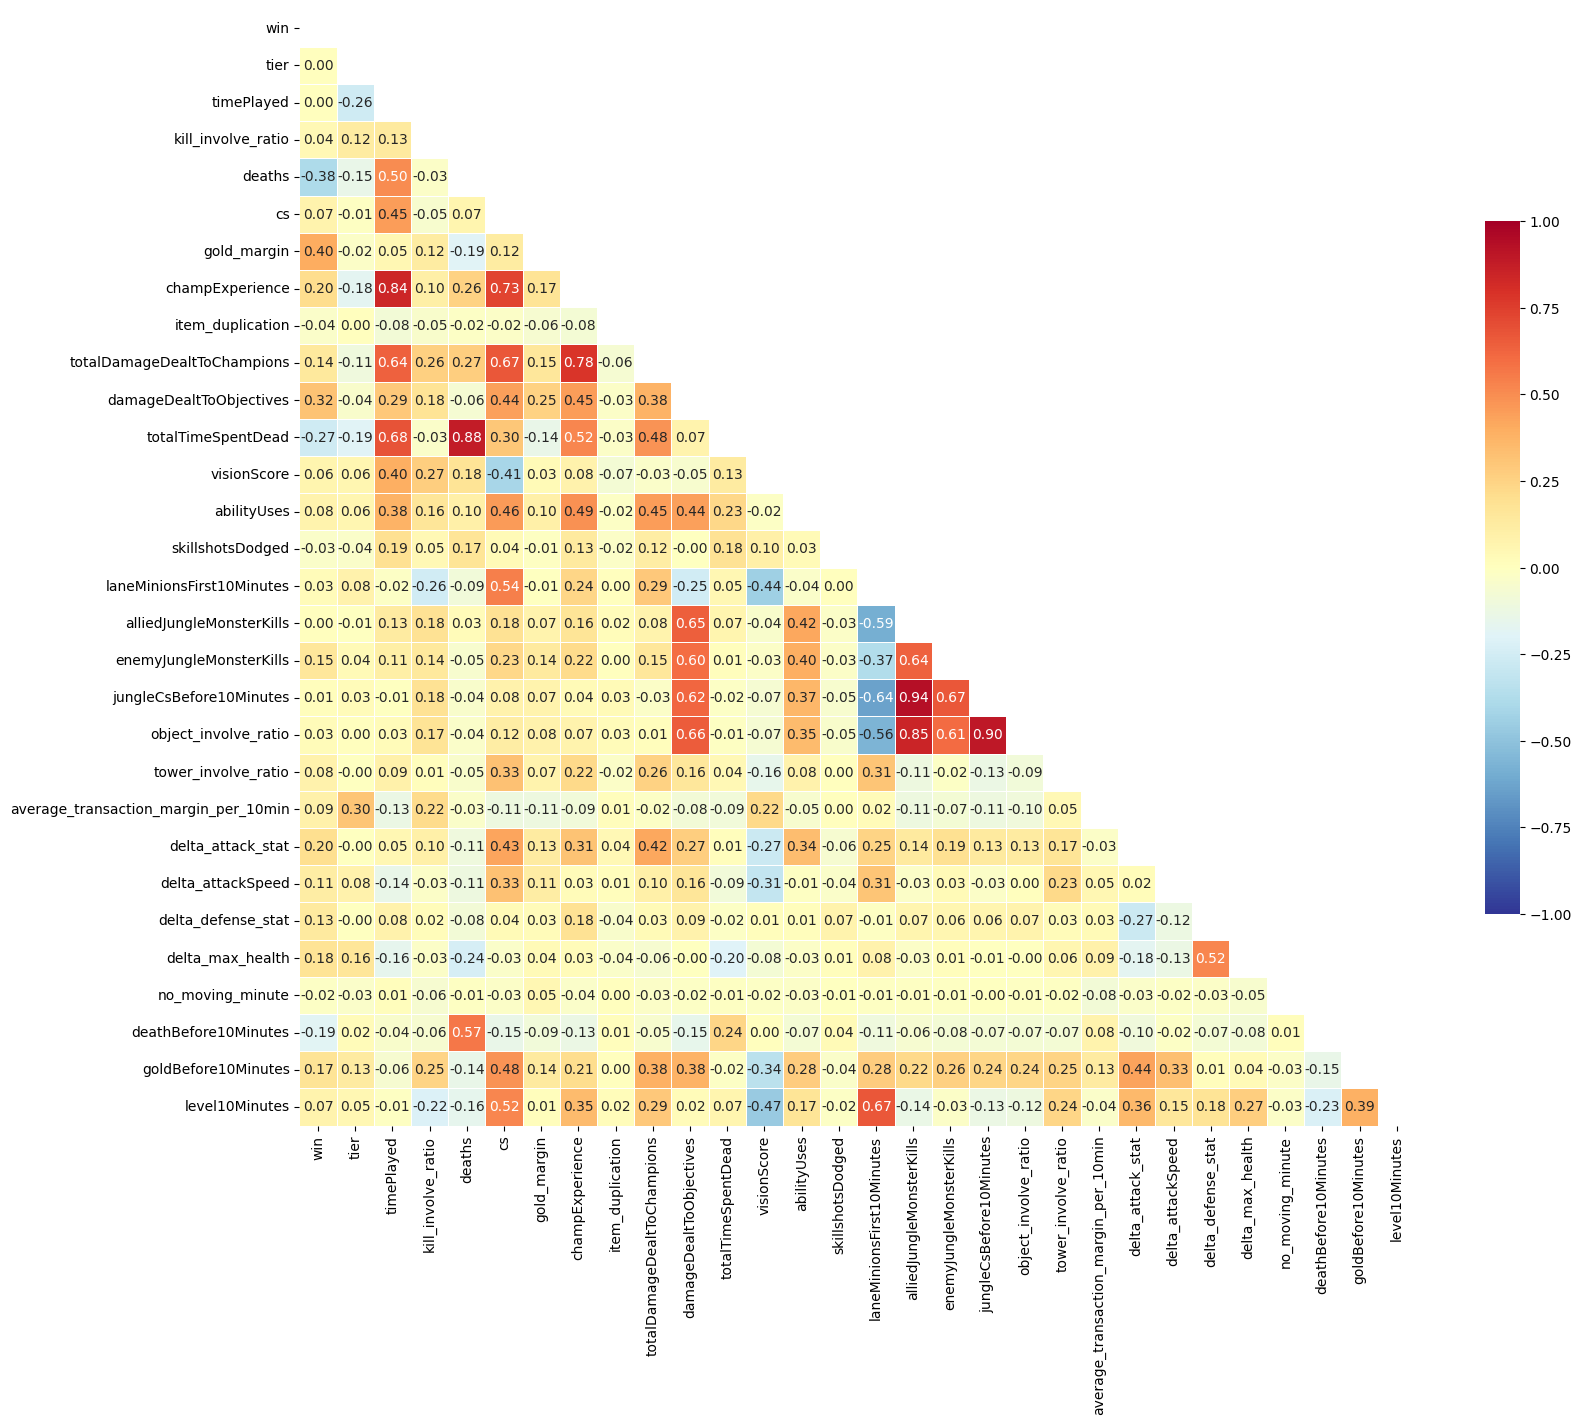

In [125]:
numeric_normal_df = normal_df[['win','tier','timePlayed','kill_involve_ratio','deaths', 'cs', 
                               'gold_margin', 'champExperience','item_duplication', 
                               'totalDamageDealtToChampions','damageDealtToObjectives', 
                               'totalTimeSpentDead', 'visionScore','abilityUses', 'skillshotsDodged', 
                               'laneMinionsFirst10Minutes', 'alliedJungleMonsterKills', 
                               'enemyJungleMonsterKills','jungleCsBefore10Minutes','object_involve_ratio', 
                               'tower_involve_ratio','average_transaction_margin_per_10min',
                               'delta_attack_stat', 'delta_attackSpeed', 'delta_defense_stat',
                               'delta_max_health', 'no_moving_minute', 'deathBefore10Minutes',
                               'goldBefore10Minutes','level10Minutes']]

normal_corr = numeric_normal_df.corr(numeric_only=True)

fig, ax = plt.subplots( figsize=(18,18) )

mask = np.zeros_like(numeric_normal_df.corr(numeric_only=True), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

test_heatmap = sns.heatmap(normal_corr.values,
                          cbar = True,
                           cbar_kws={"shrink": .5},
                           cmap = 'RdYlBu_r',
                           annot = True,
                          annot_kws={'size' : 10},
                           mask=mask,
                           fmt = '.2f',
                           square = 'True',
                           linewidths=.5,
                          yticklabels=normal_corr.columns,
                          xticklabels=normal_corr.columns,
                          vmin = -1,vmax = 1)
plt.show()

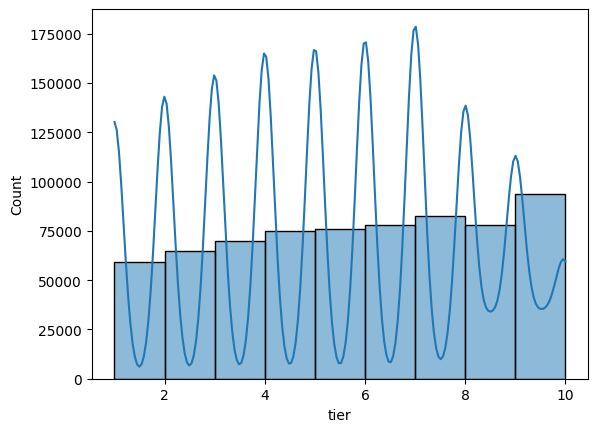

In [134]:
sns.histplot(data=normal_df,
            x='tier',
             kde=True,
             binwidth=1)

plt.show()

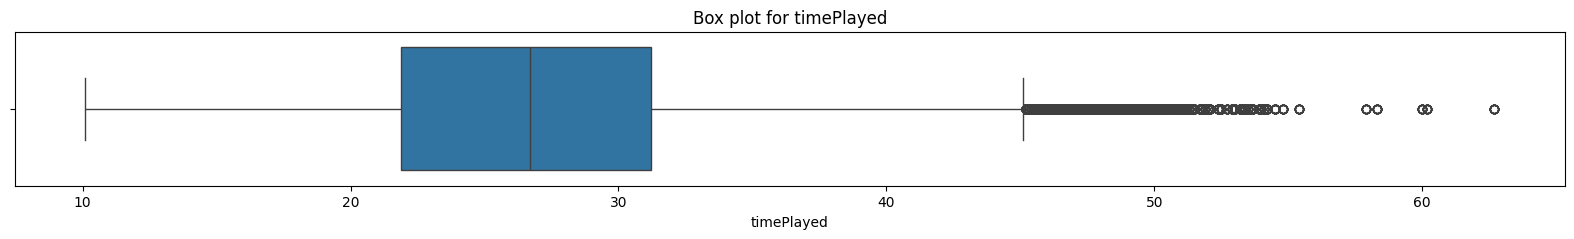

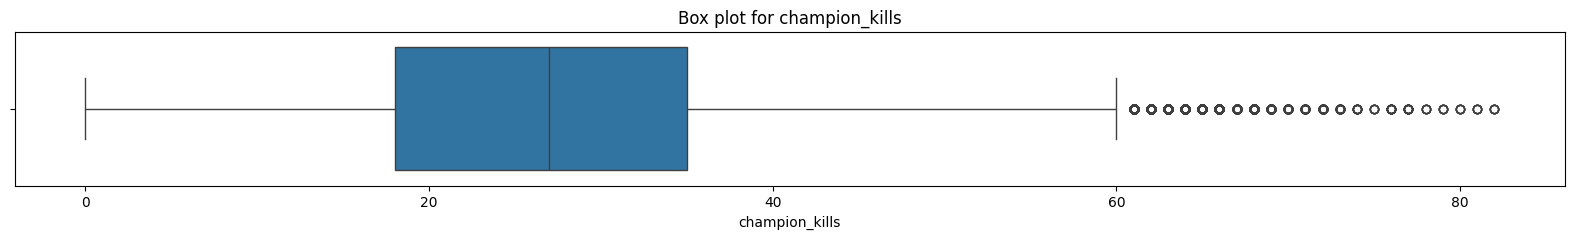

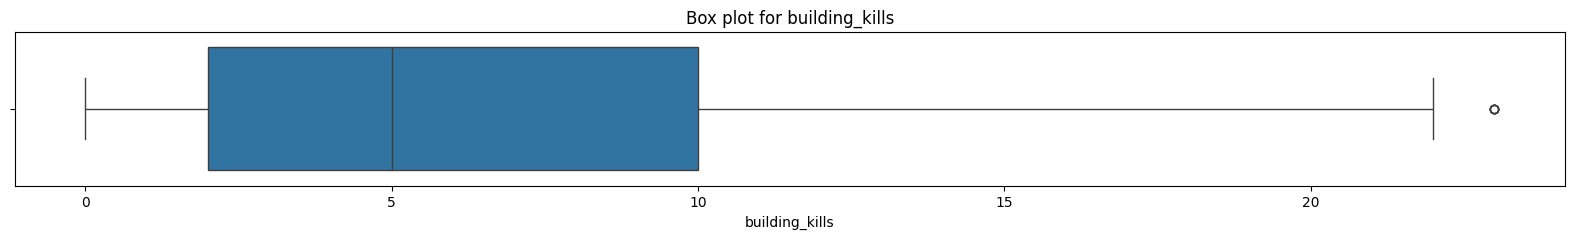

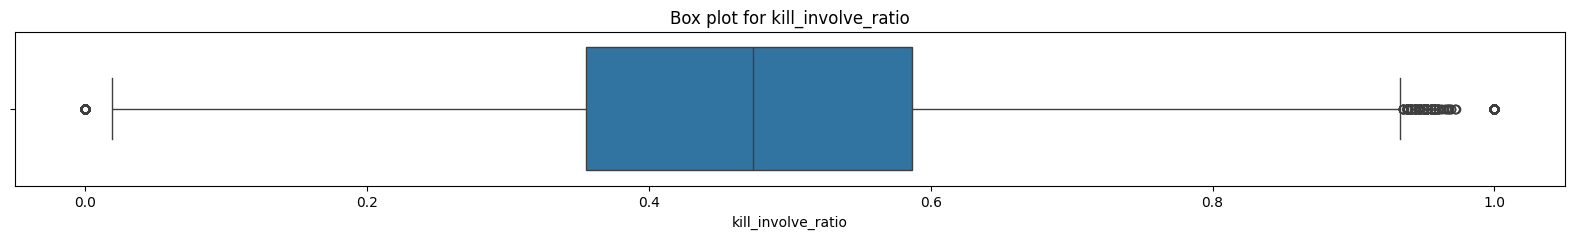

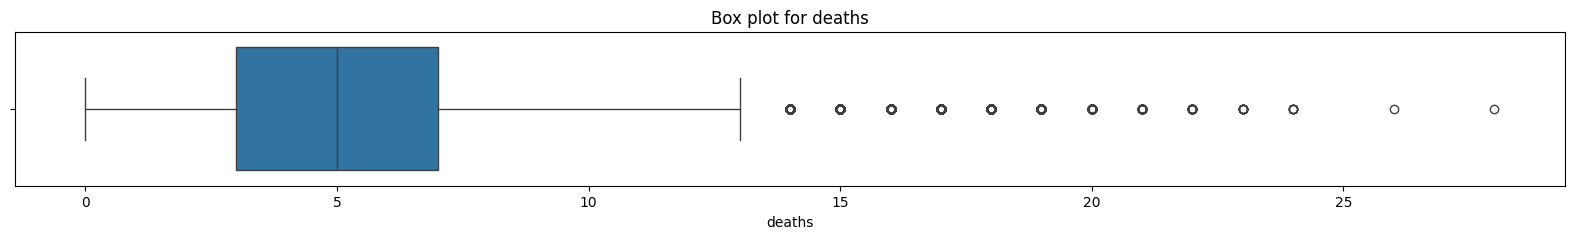

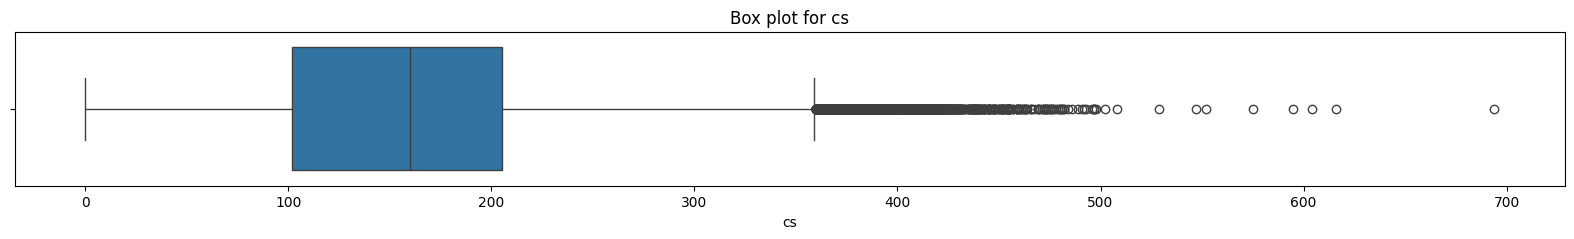

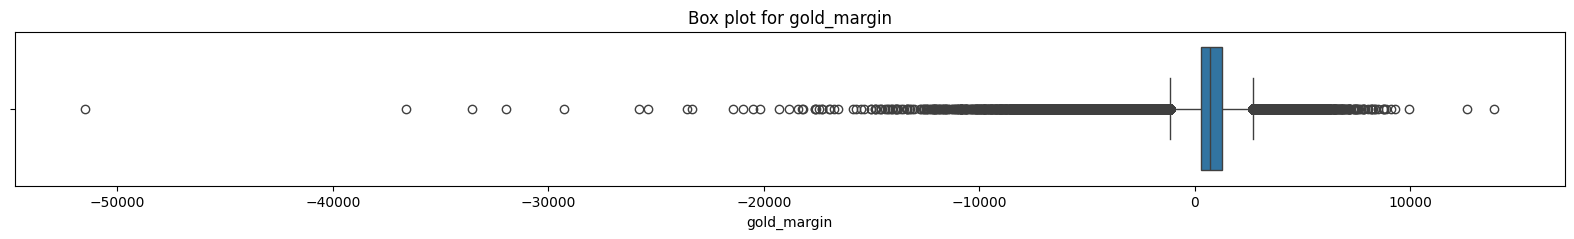

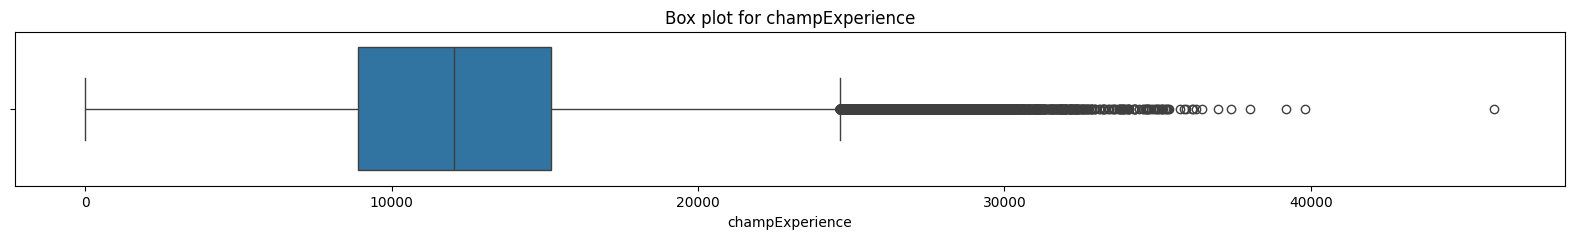

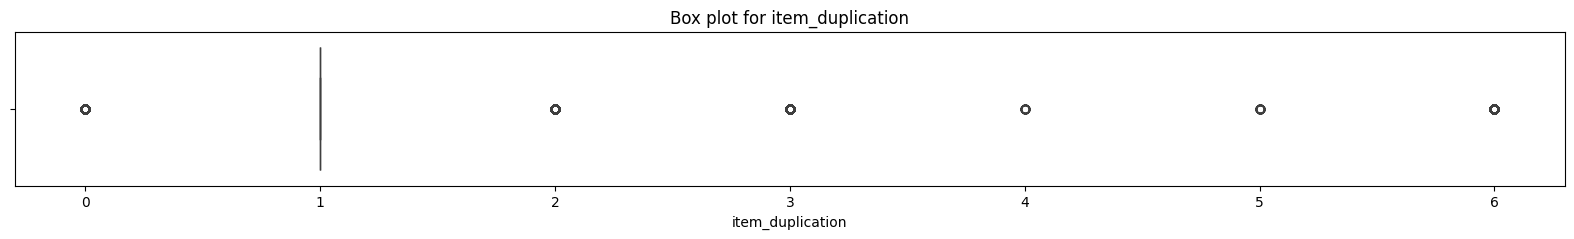

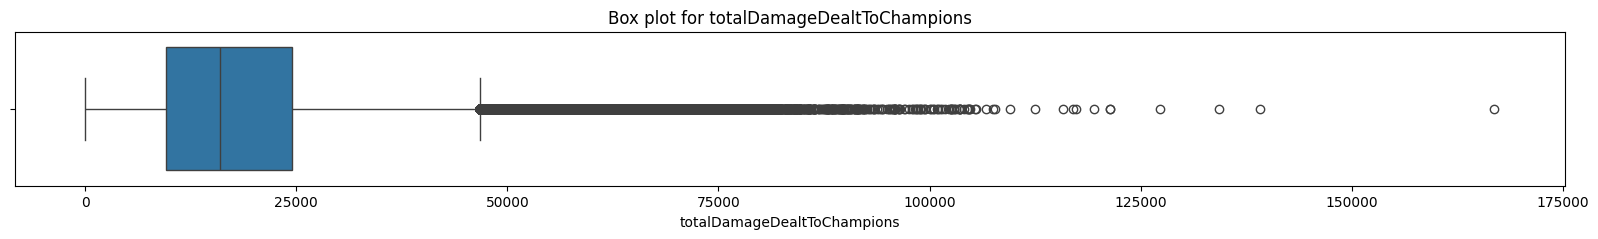

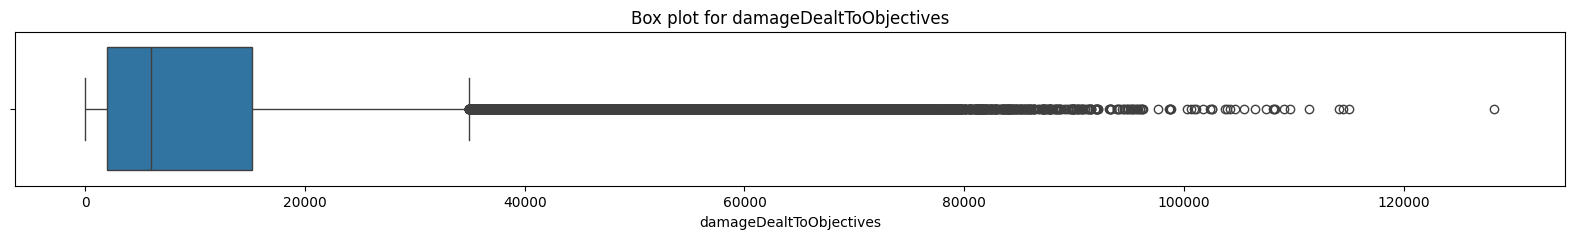

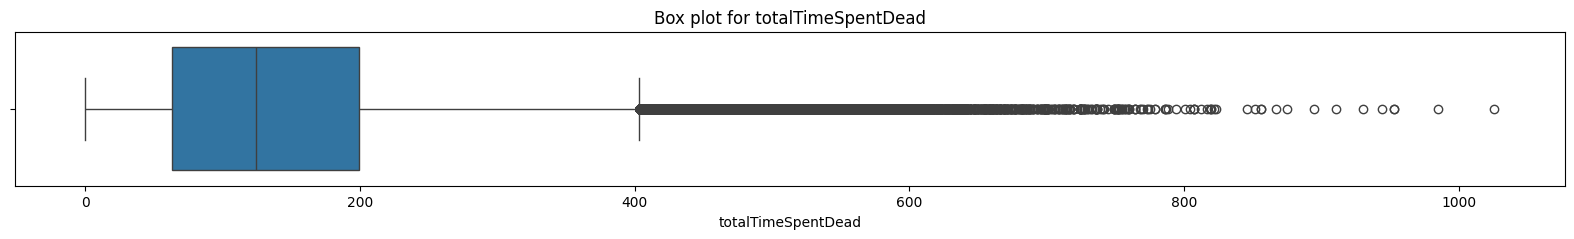

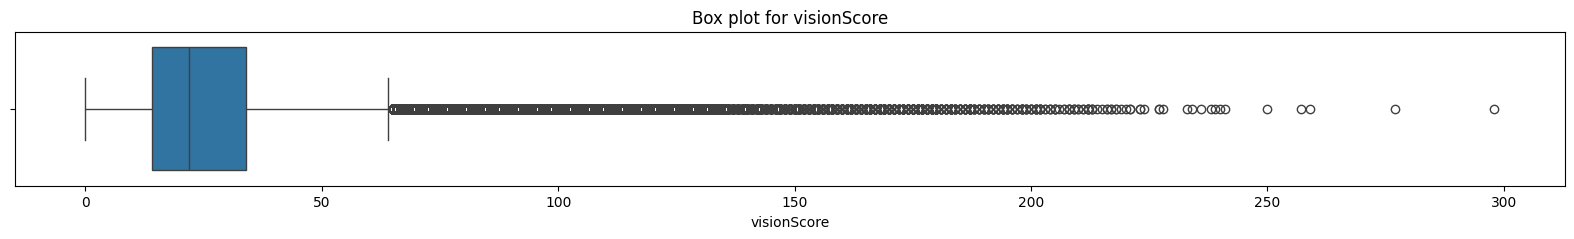

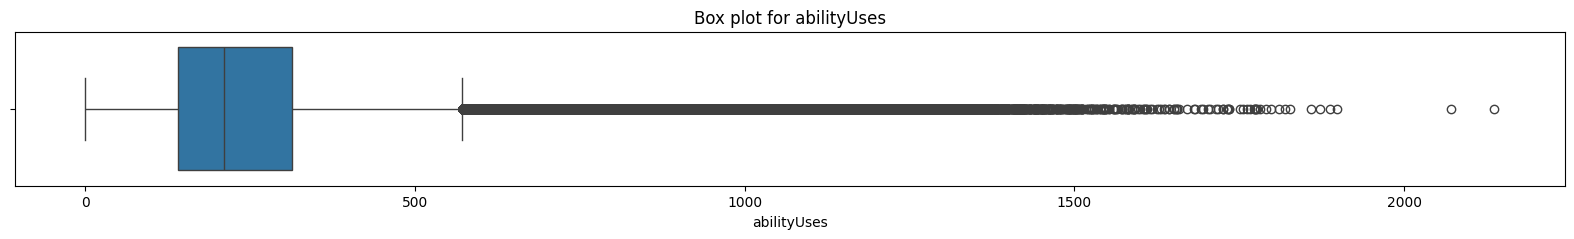

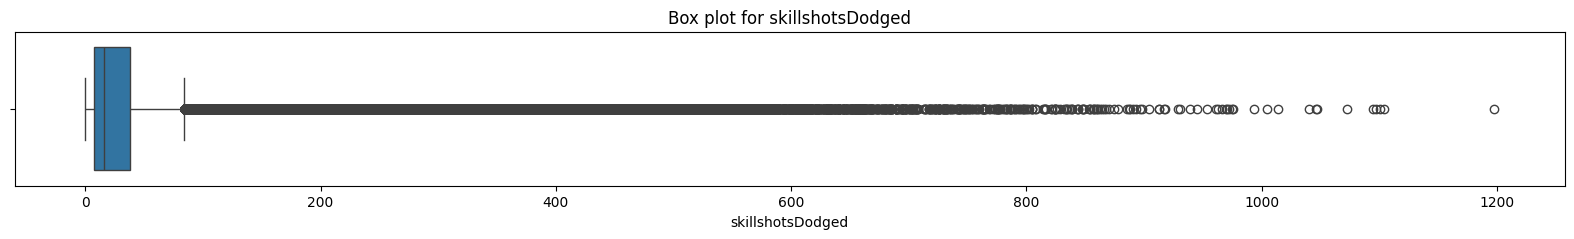

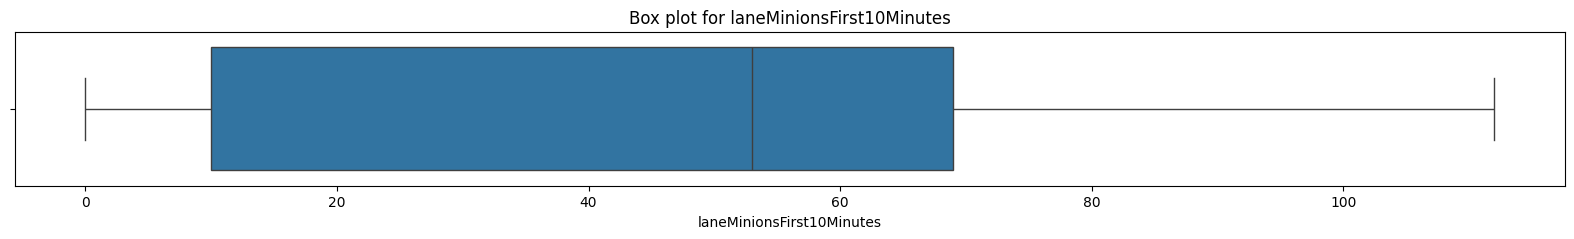

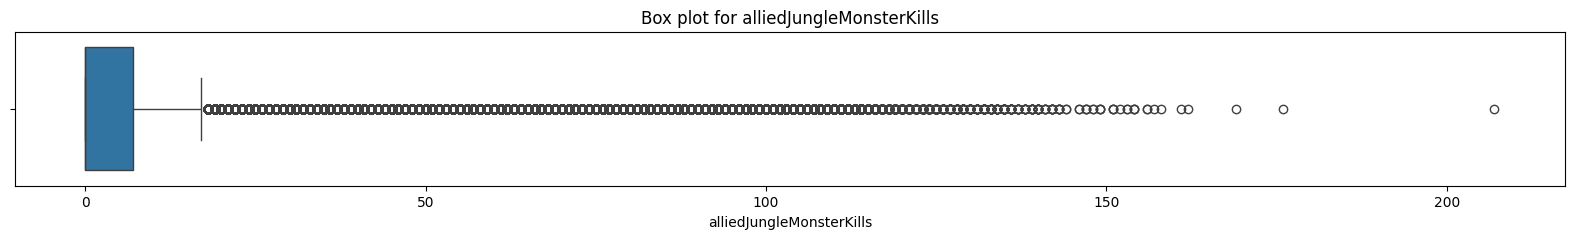

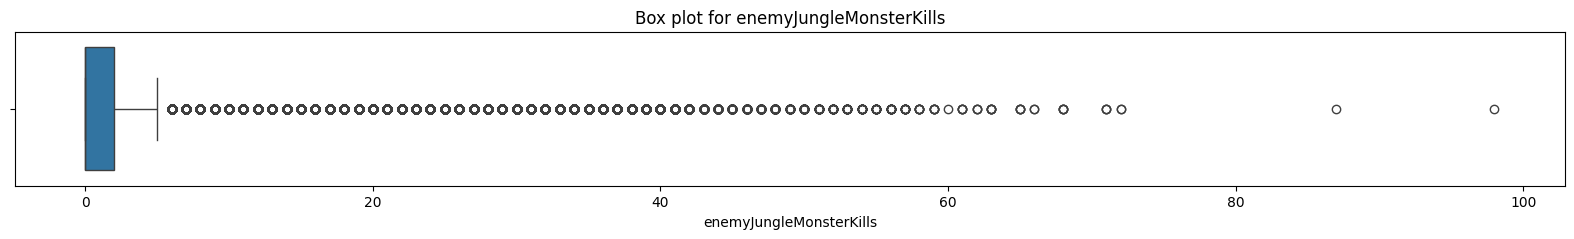

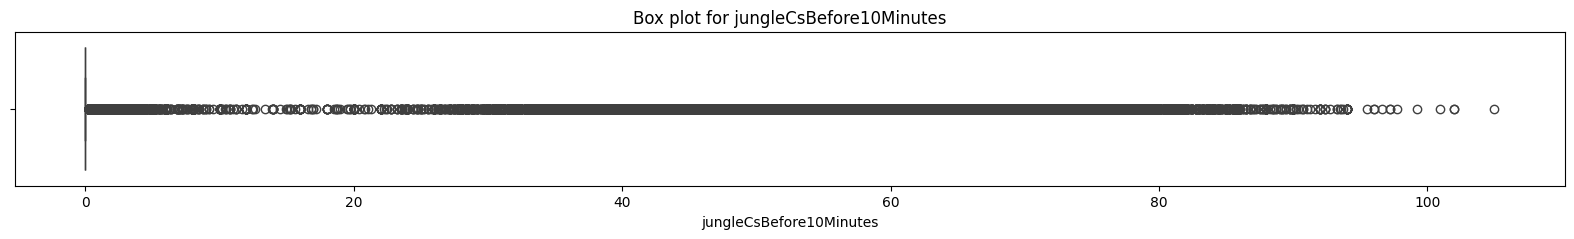

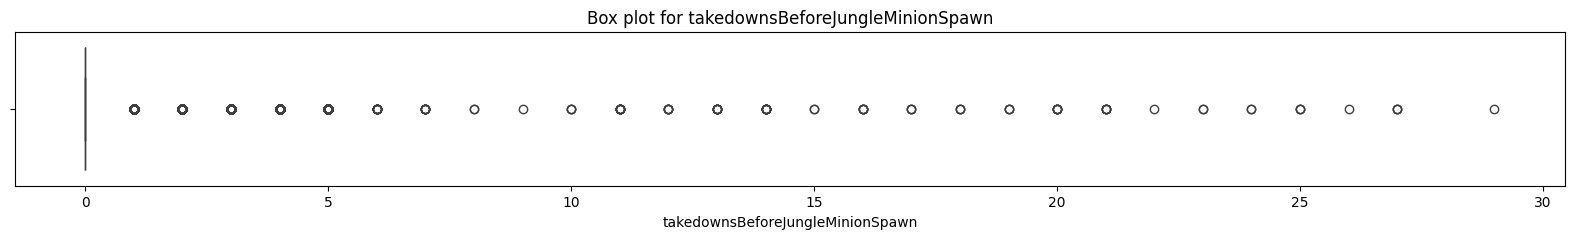

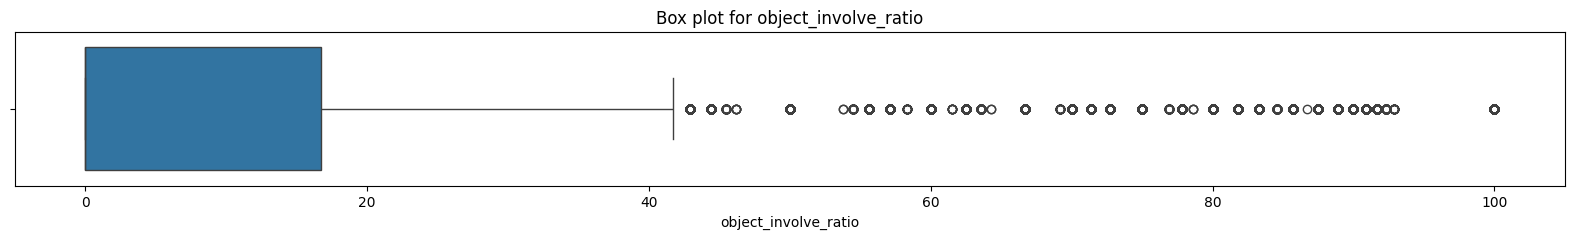

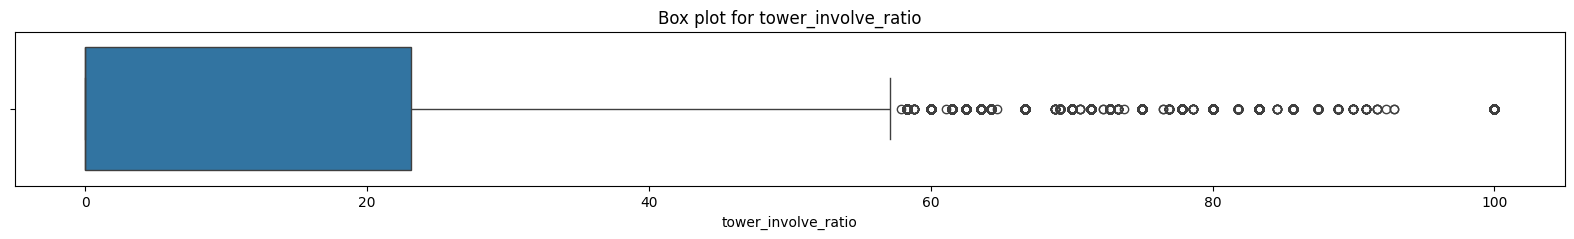

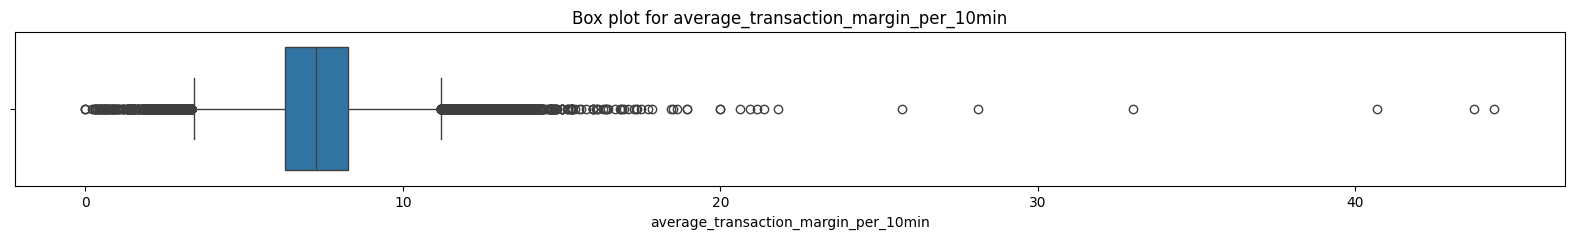

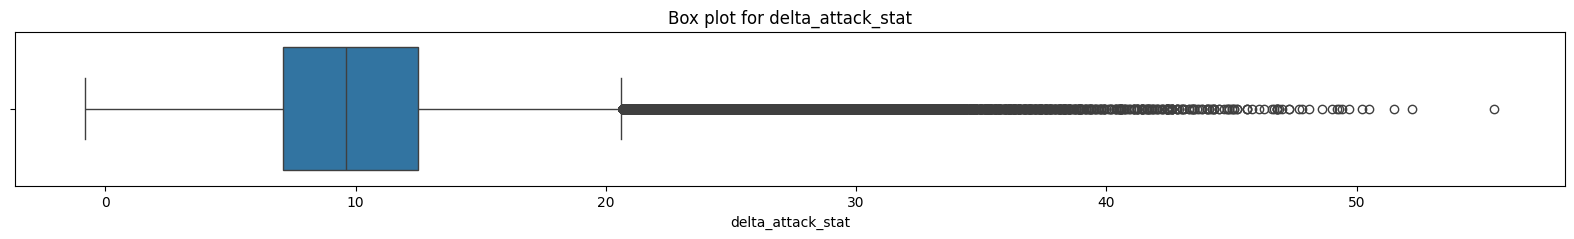

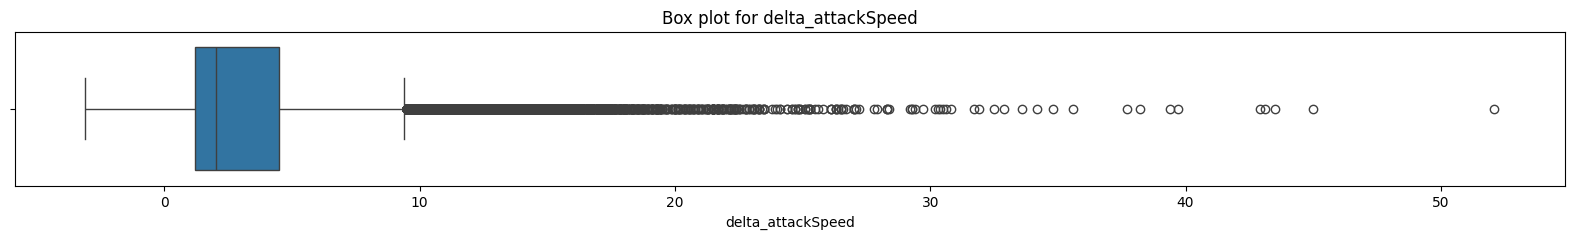

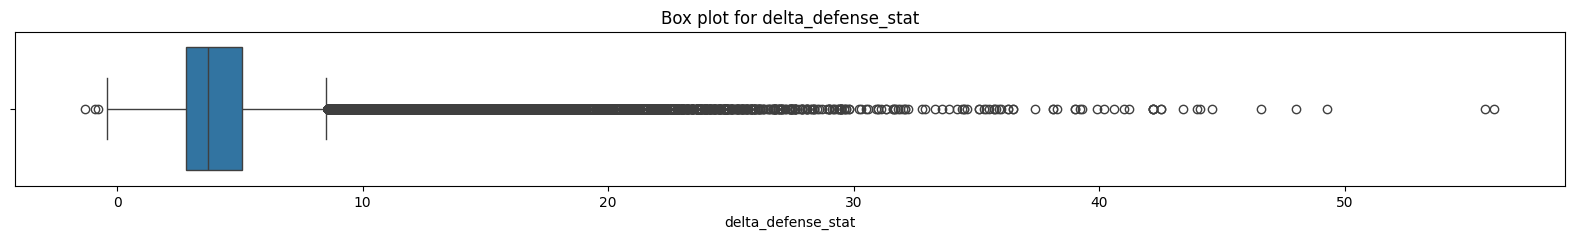

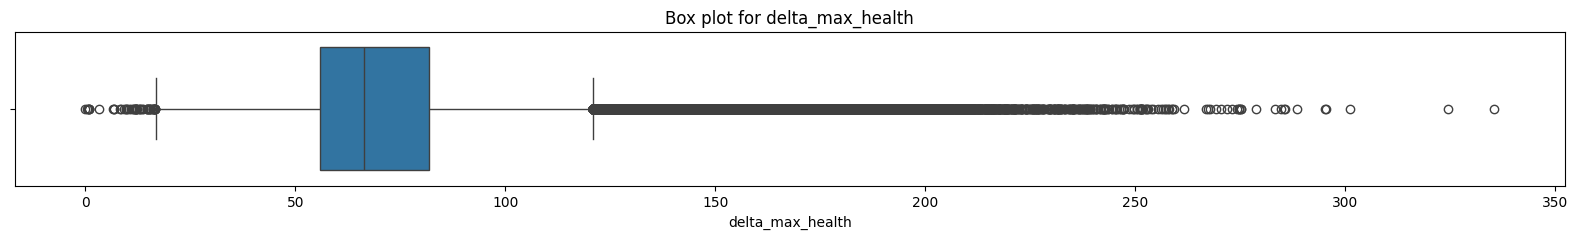

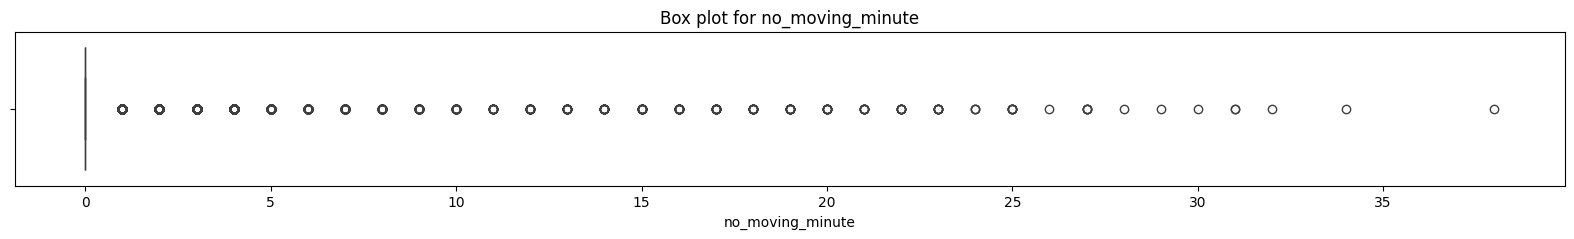

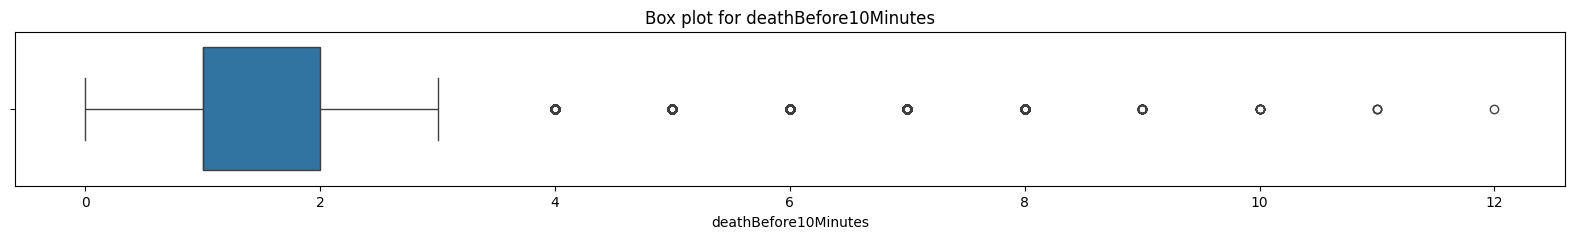

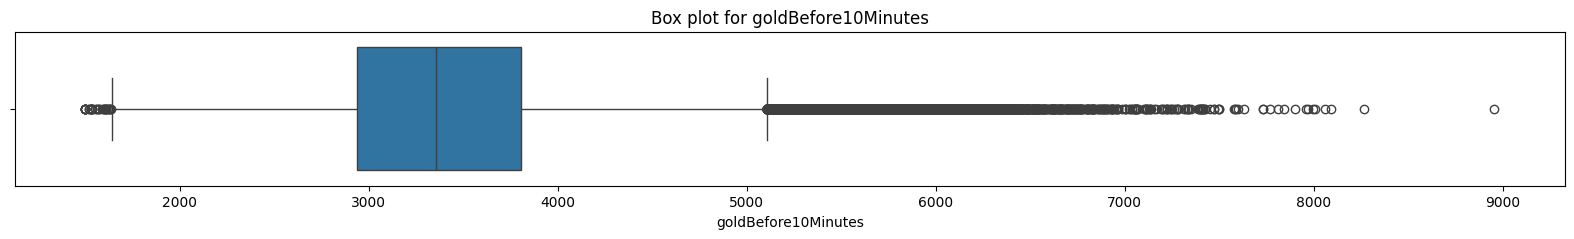

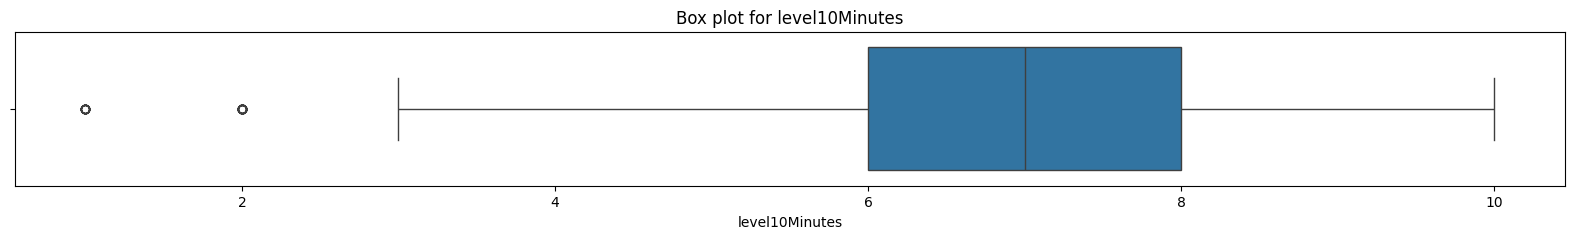

In [8]:
numeric_columns = ['timePlayed', 'champion_kills', 'building_kills', 'kill_involve_ratio', 
                   'deaths', 'cs','gold_margin', 'champExperience', 'item_duplication',
                   'totalDamageDealtToChampions', 'damageDealtToObjectives', 'totalTimeSpentDead', 
                   'visionScore','abilityUses', 'skillshotsDodged', 'laneMinionsFirst10Minutes', 
                   'alliedJungleMonsterKills','enemyJungleMonsterKills', 'jungleCsBefore10Minutes',
                   'object_involve_ratio', 'tower_involve_ratio',
                   'average_transaction_margin_per_10min', 'delta_attack_stat','delta_attackSpeed',
                   'delta_defense_stat', 'delta_max_health', 'no_moving_minute',
                   'deathBefore10Minutes', 'goldBefore10Minutes', 'level10Minutes']


for col in numeric_columns:
    plt.figure(figsize=(20, 2))  # 가로 길이와 세로 길이 조정
    sns.boxplot(x=normal_df[col])
    plt.title(f'Box plot for {col}')
    plt.show()

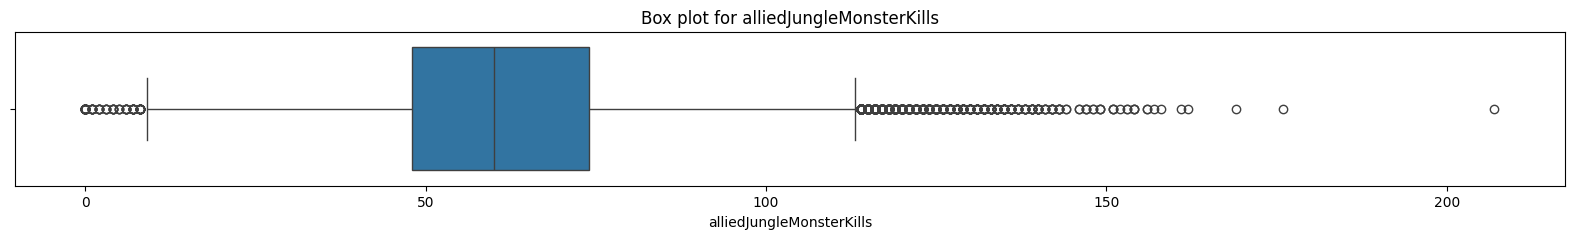

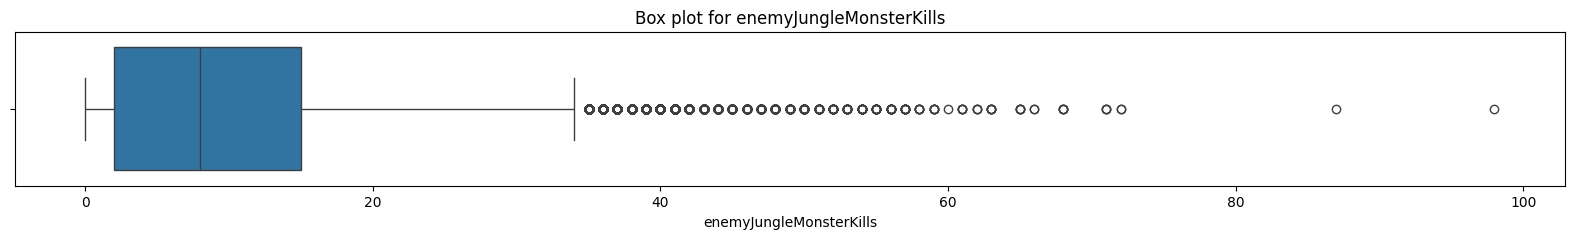

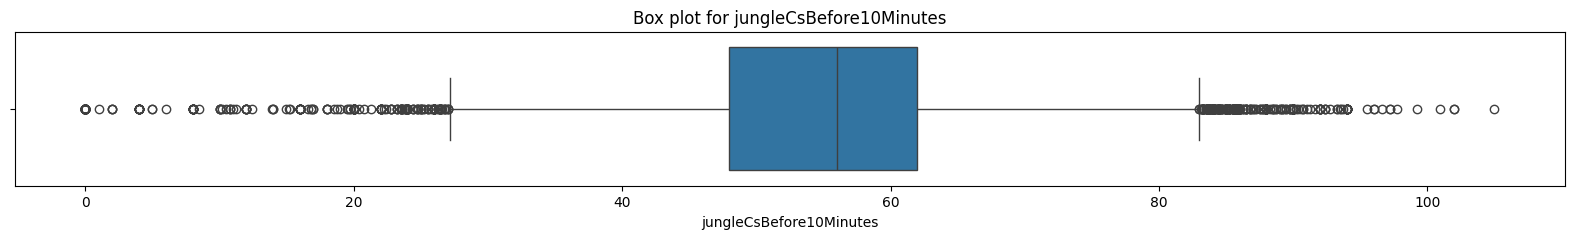

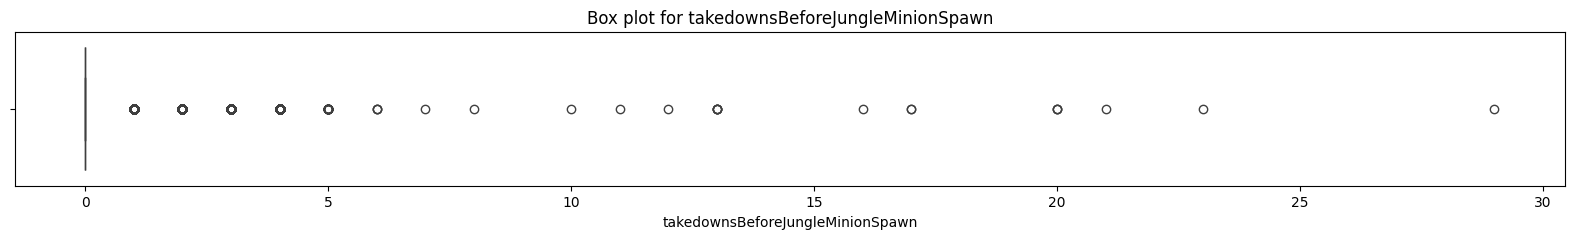

In [10]:
jungle_columns = ['alliedJungleMonsterKills','enemyJungleMonsterKills', 'jungleCsBefore10Minutes']

for col in jungle_columns:
    plt.figure(figsize=(20, 2))  # 가로 길이와 세로 길이 조정
    sns.boxplot(x=normal_df[normal_df['teamPosition']=='JUNGLE'][col])
    plt.title(f'Box plot for {col}')
    plt.show()

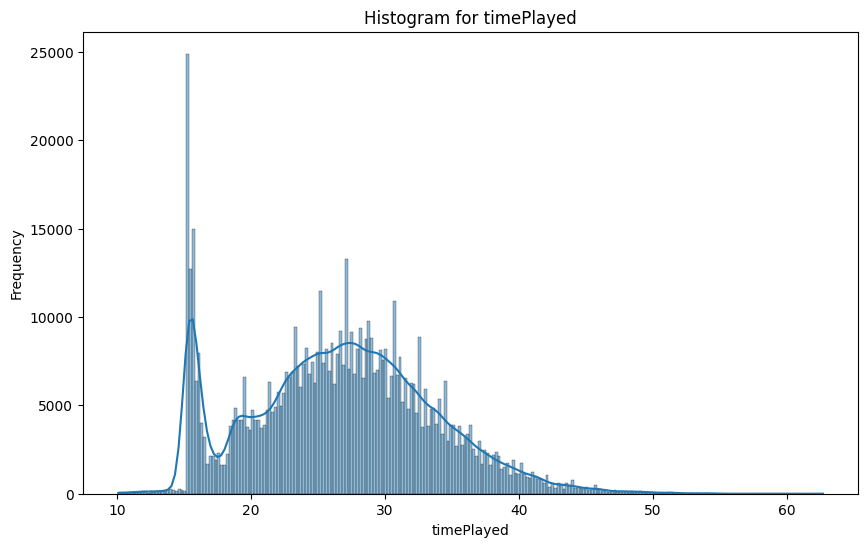

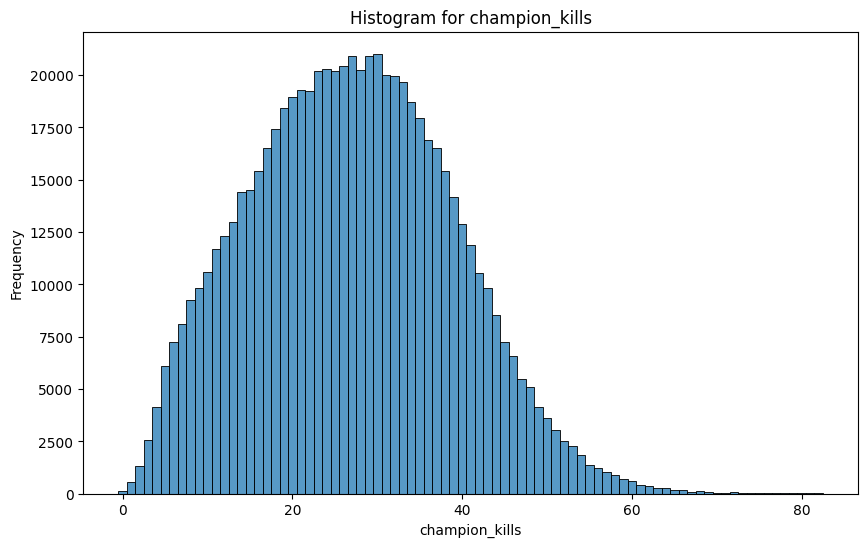

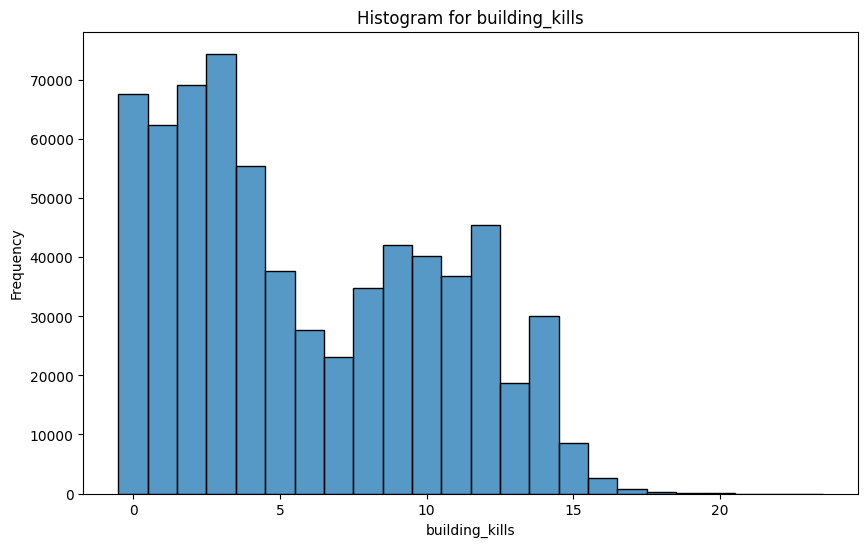

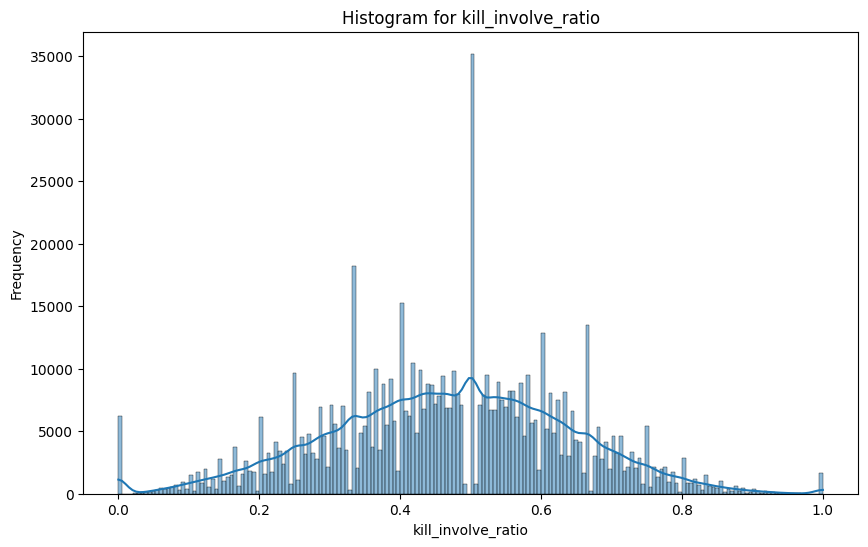

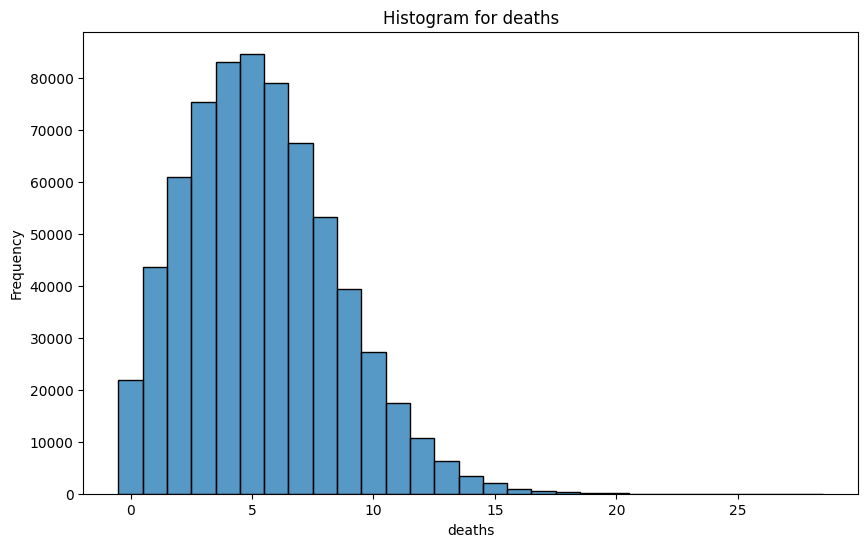

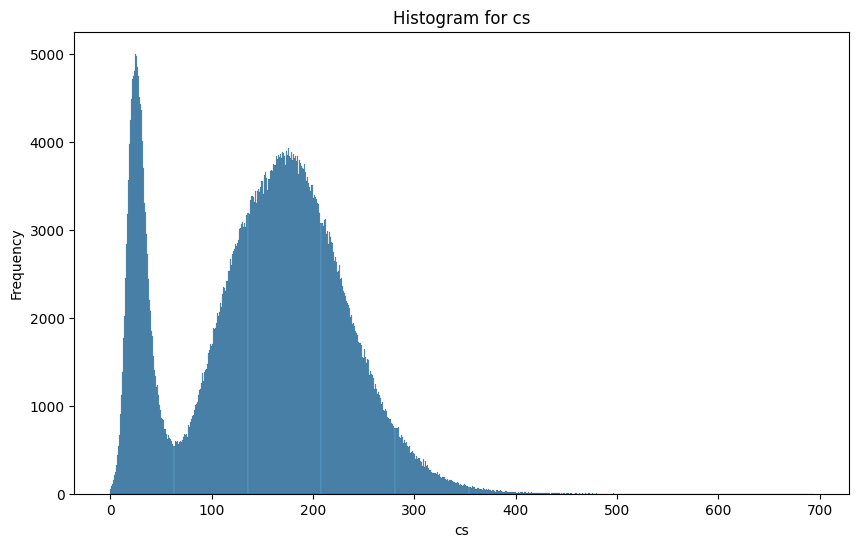

In [13]:
for col in numeric_columns[:6]:
    plt.figure(figsize=(10, 6))  # 가로 길이와 세로 길이 조정
    if pd.api.types.is_integer_dtype(normal_df[col]):
        sns.histplot(normal_df[col], discrete=True)
    else:
        sns.histplot(normal_df[col], kde=True)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

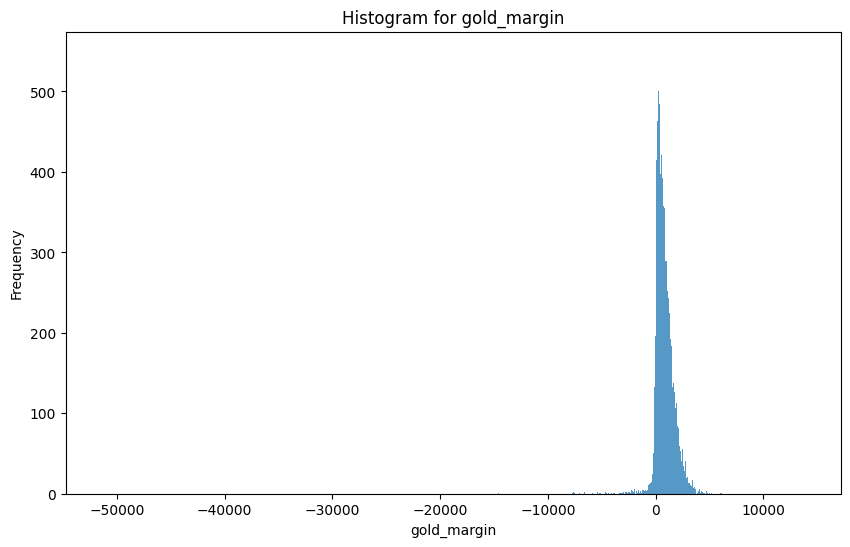

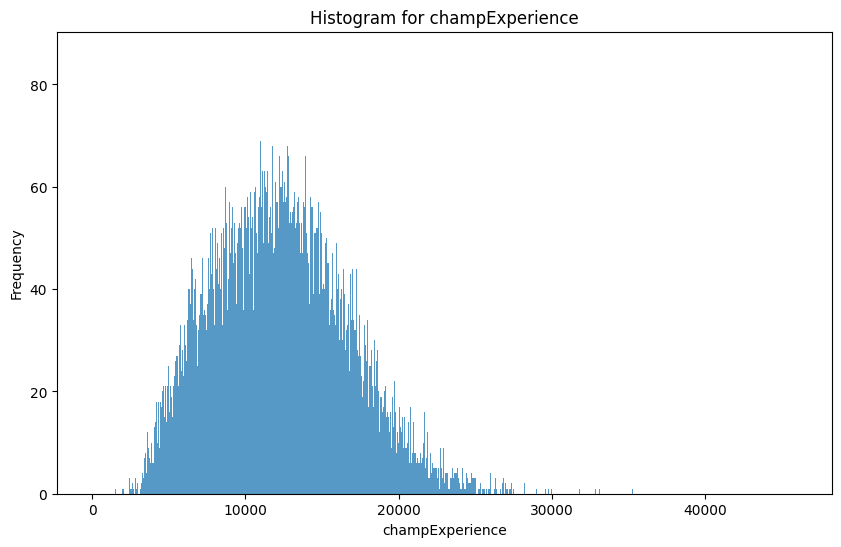

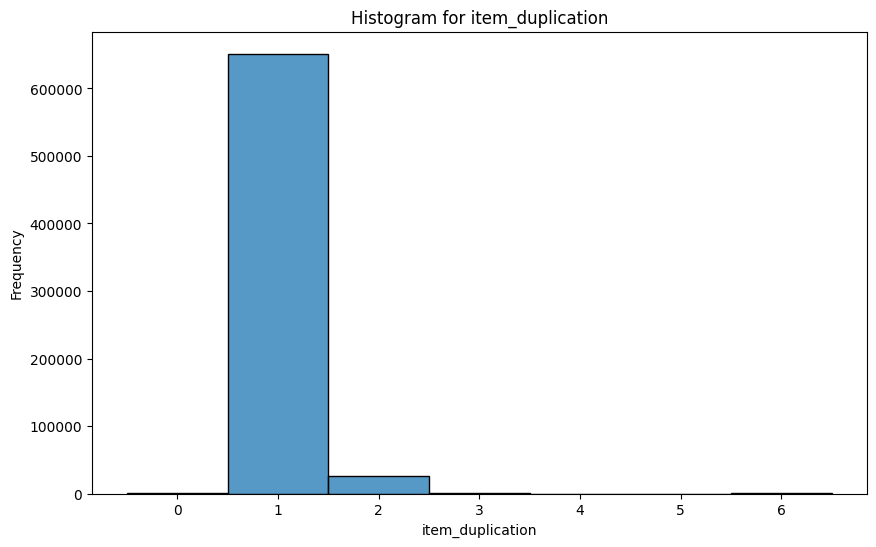

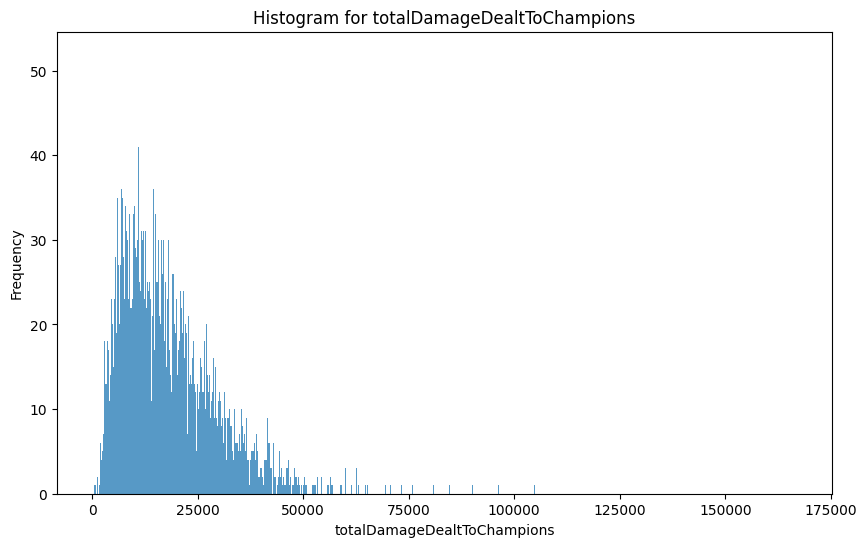

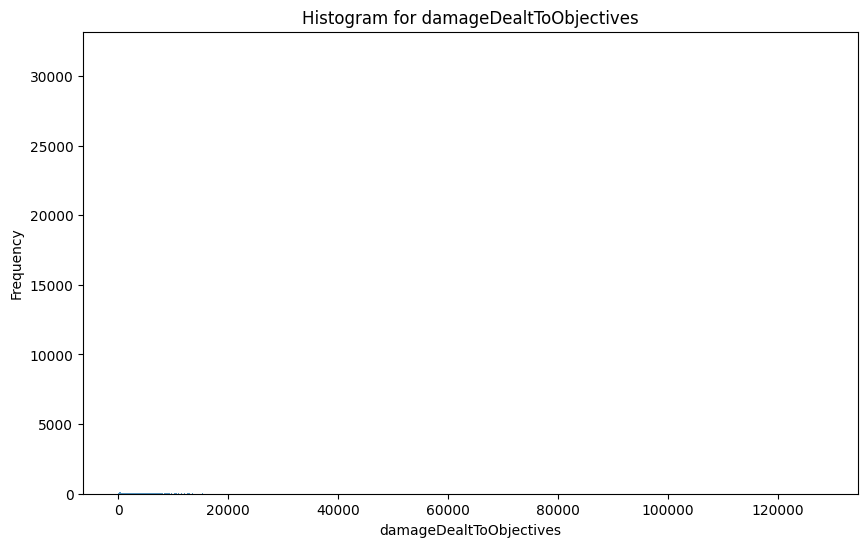

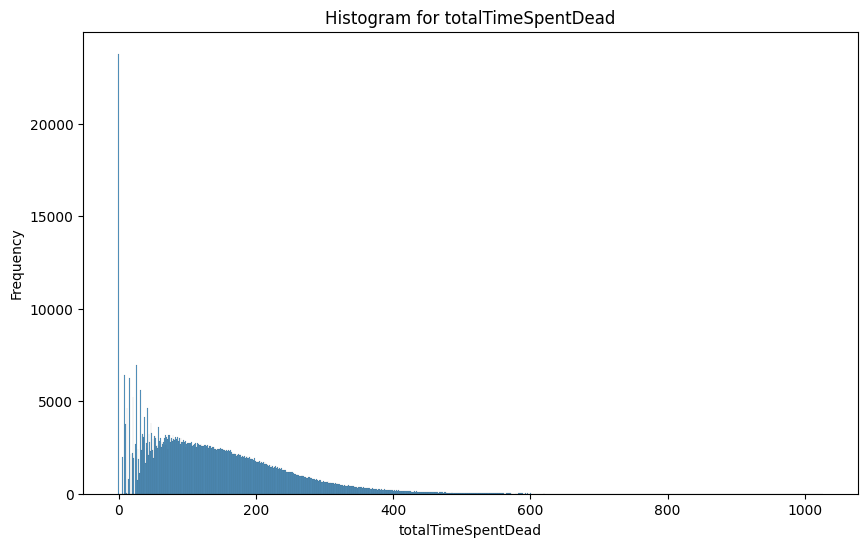

In [14]:
for col in numeric_columns[6:12]:
    plt.figure(figsize=(10, 6))  # 가로 길이와 세로 길이 조정
    if pd.api.types.is_integer_dtype(normal_df[col]):
        sns.histplot(normal_df[col], discrete=True)
    else:
        sns.histplot(normal_df[col], kde=True)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

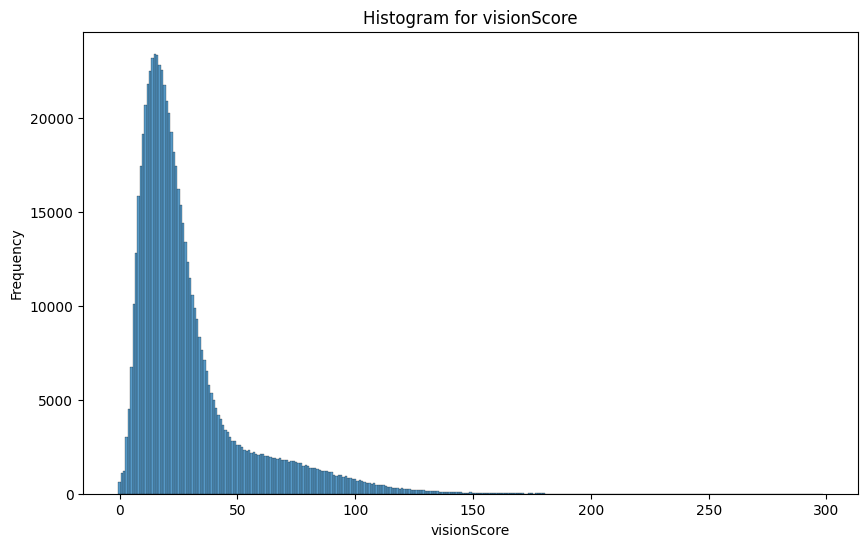

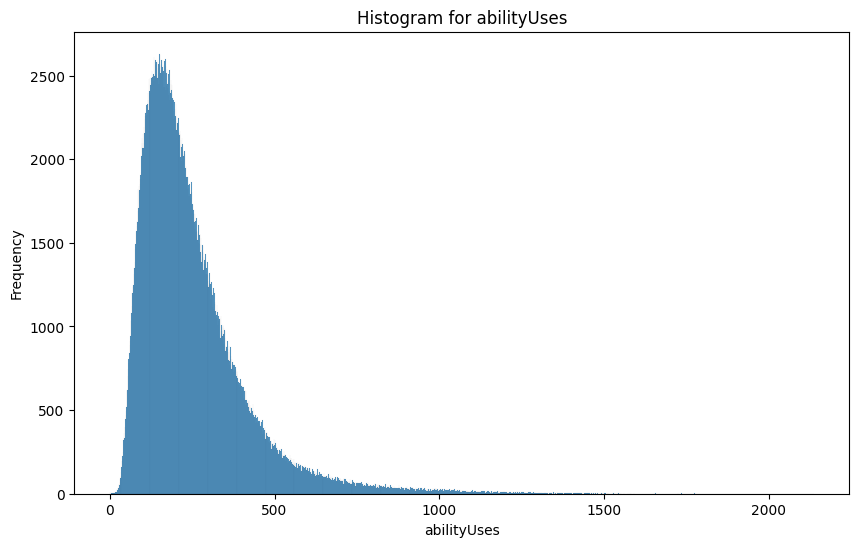

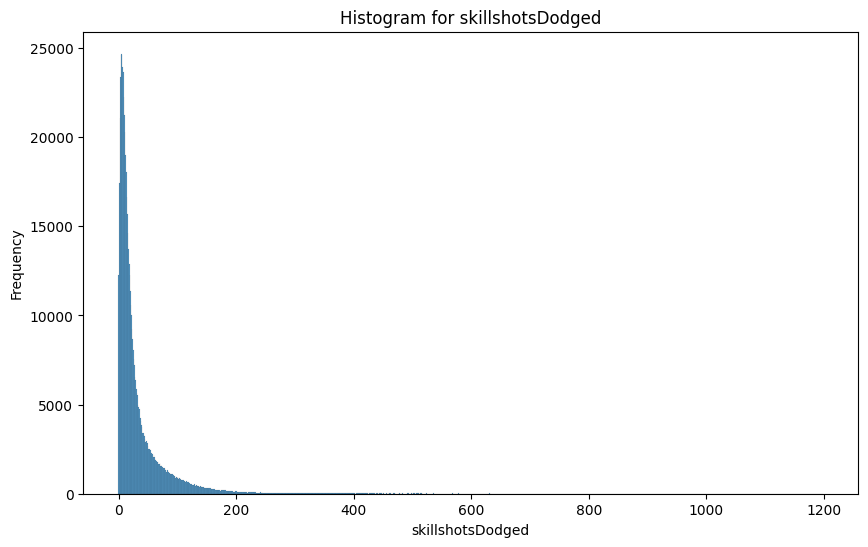

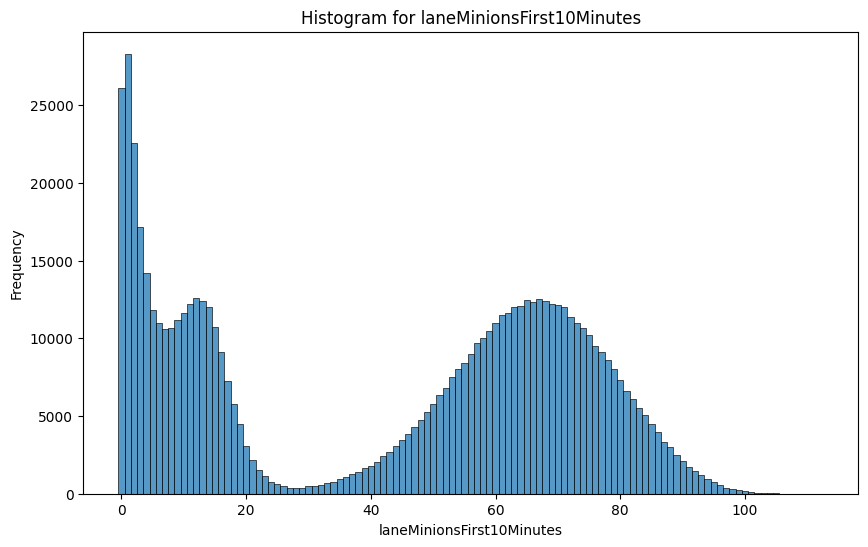

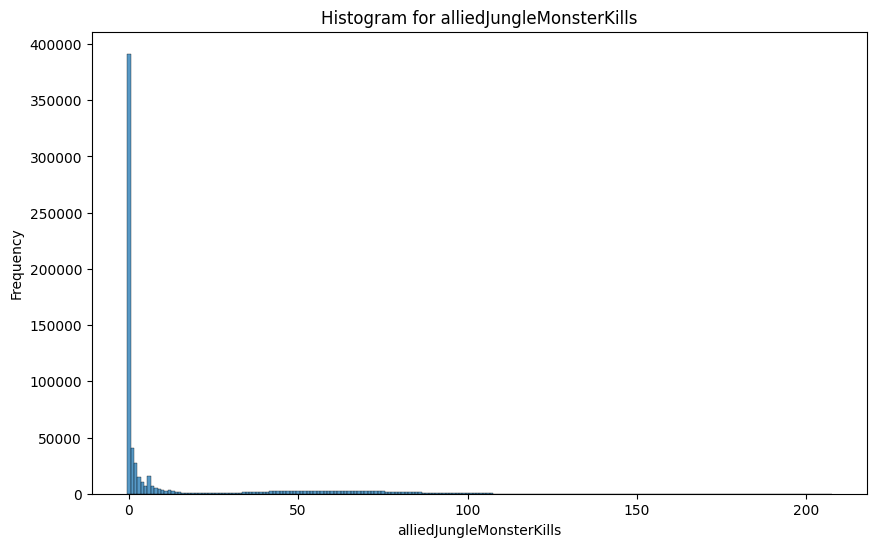

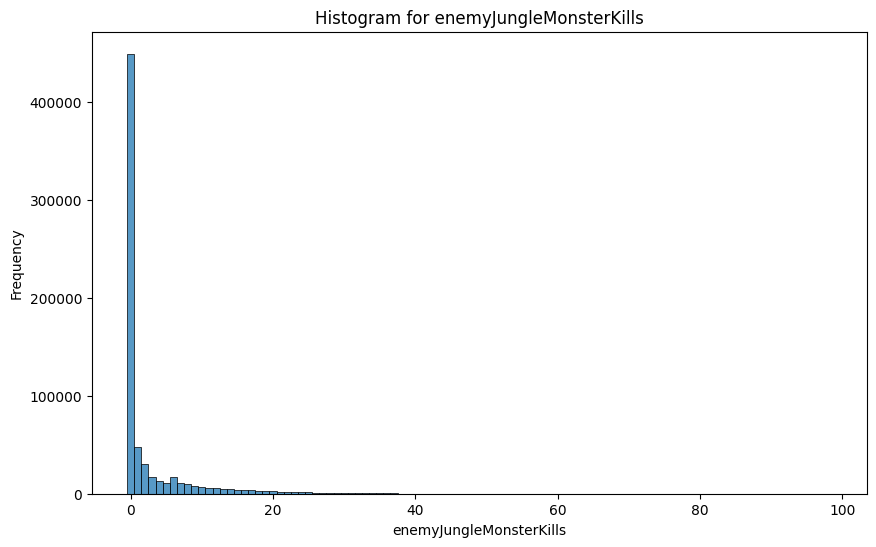

In [15]:
for col in numeric_columns[12:18]:
    plt.figure(figsize=(10, 6))  # 가로 길이와 세로 길이 조정
    if pd.api.types.is_integer_dtype(normal_df[col]):
        sns.histplot(normal_df[col], discrete=True)
    else:
        sns.histplot(normal_df[col], kde=True)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

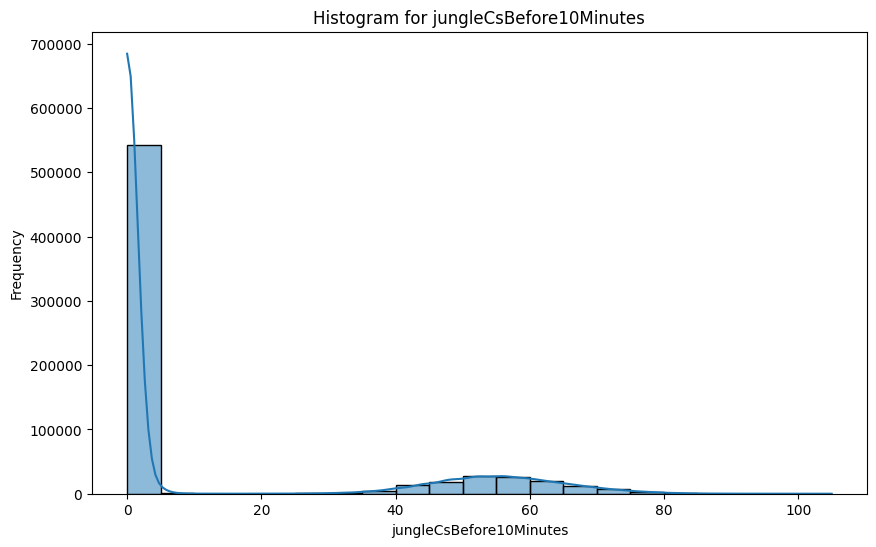

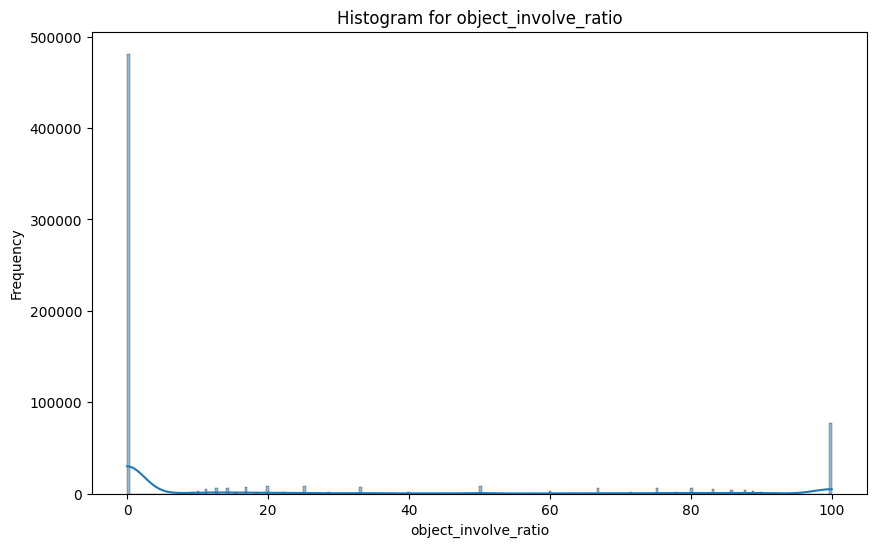

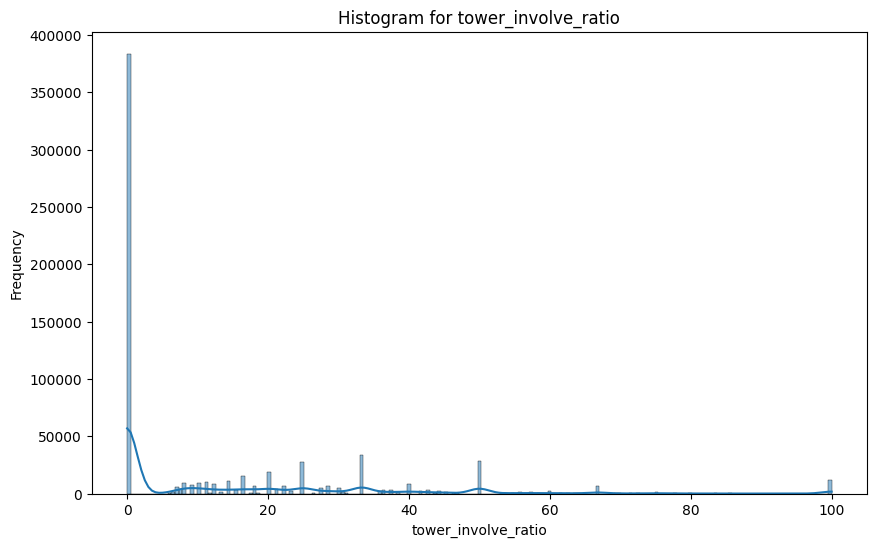

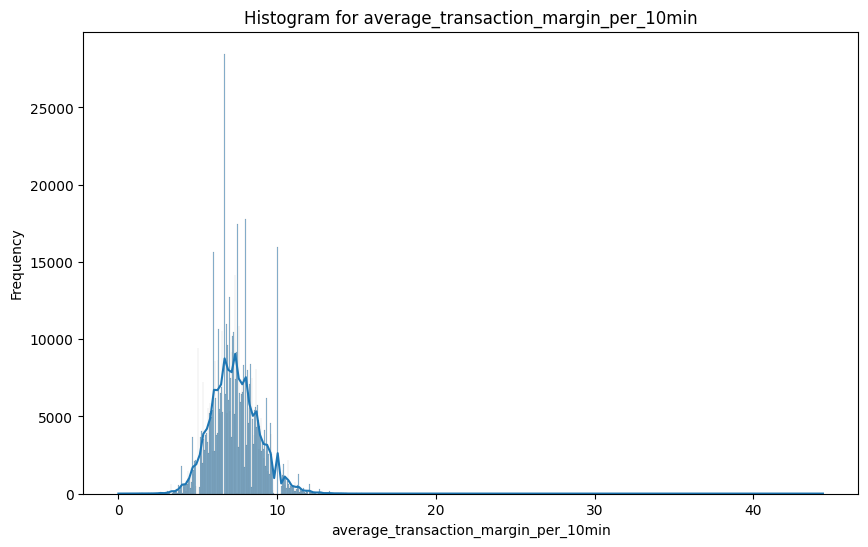

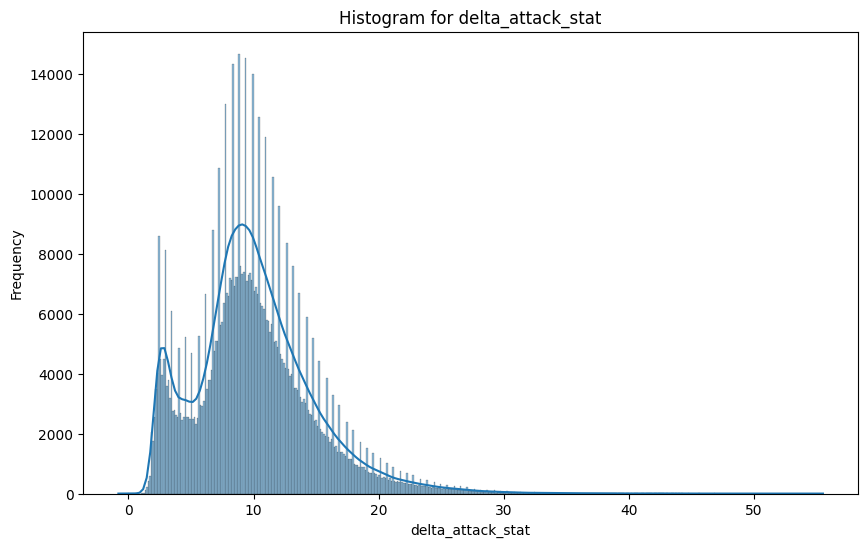

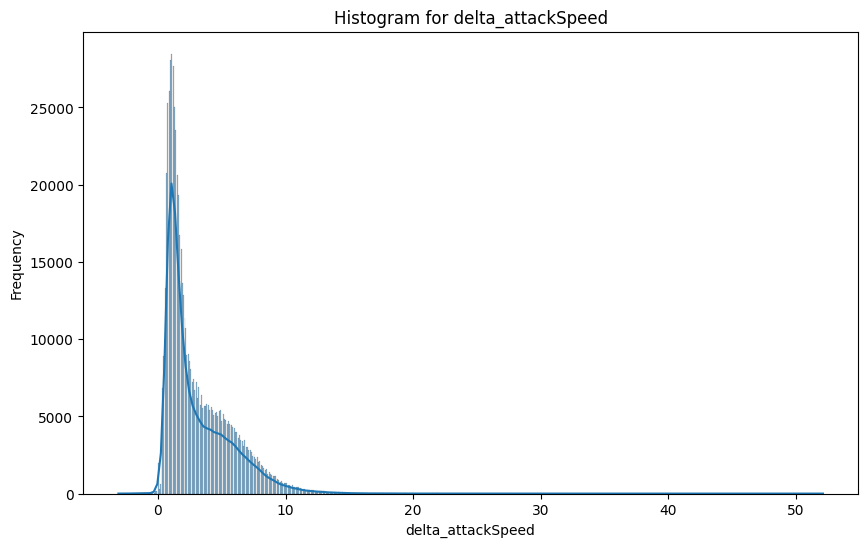

In [18]:
for col in numeric_columns[18:24]:
    plt.figure(figsize=(10, 6))  # 가로 길이와 세로 길이 조정
    if pd.api.types.is_integer_dtype(normal_df[col]):
        sns.histplot(normal_df[col], discrete=True)
    else:
        sns.histplot(normal_df[col], kde=True)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

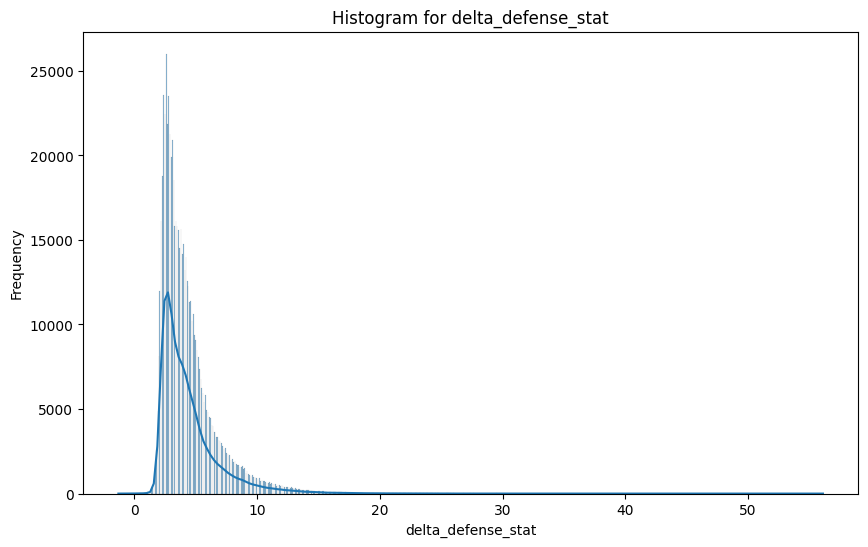

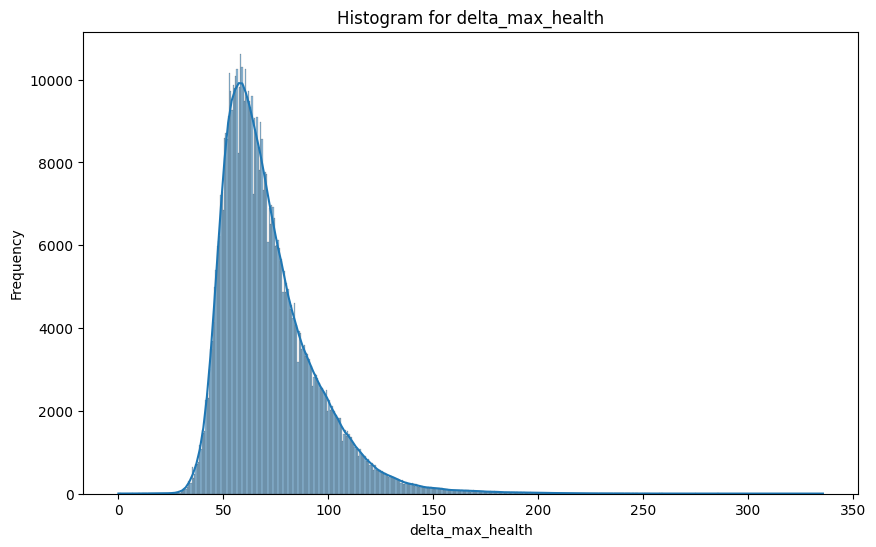

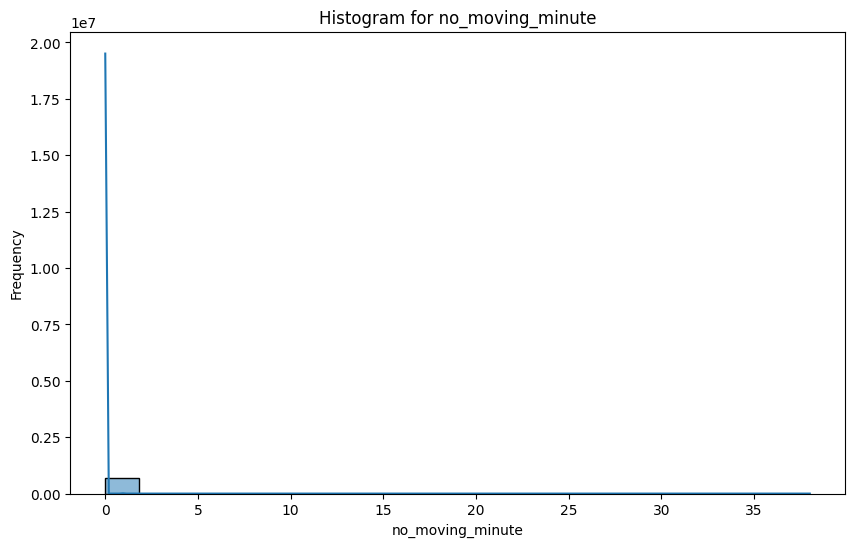

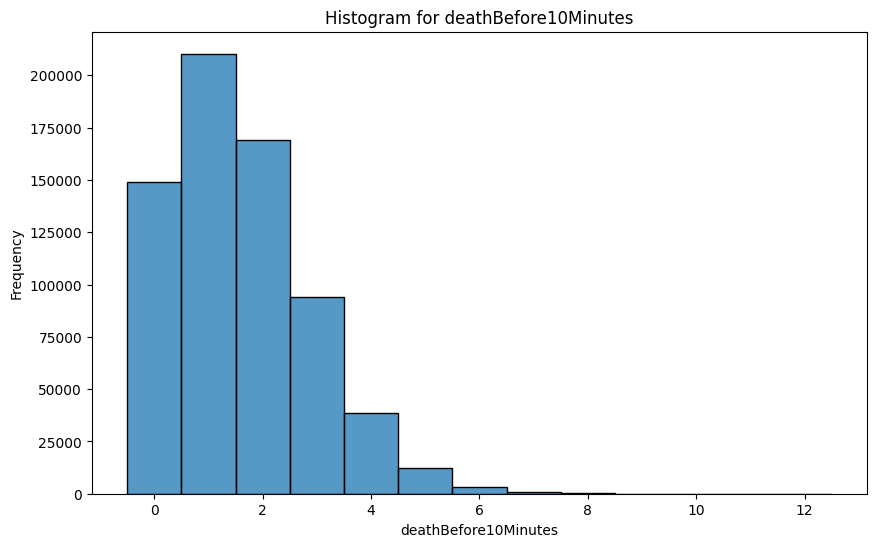

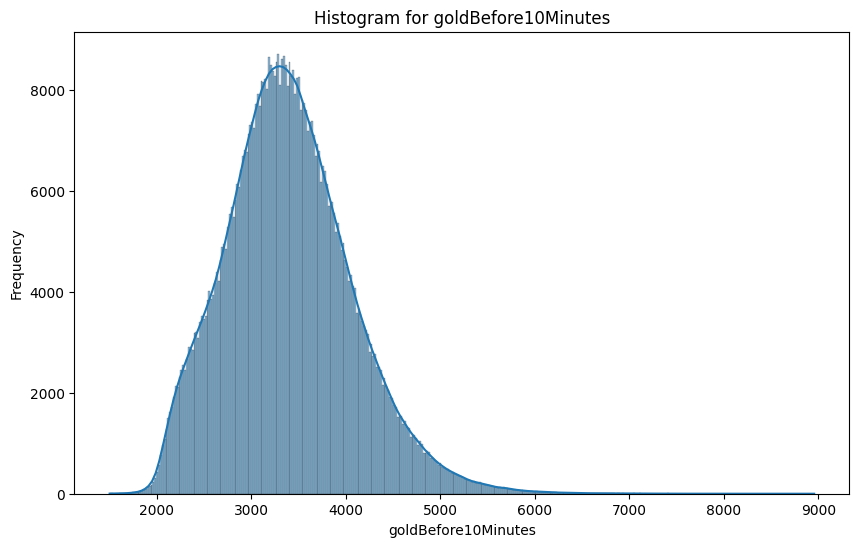

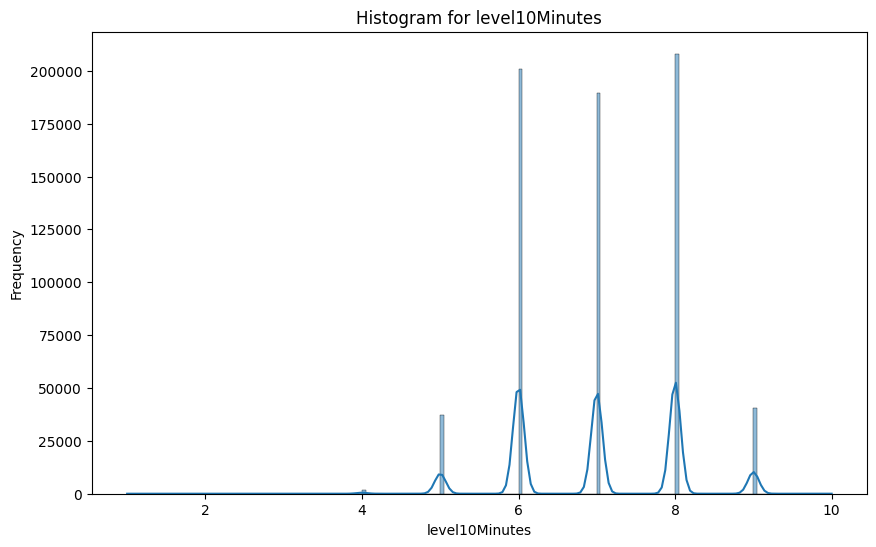

In [19]:
for col in numeric_columns[24:30]:
    plt.figure(figsize=(10, 6))  # 가로 길이와 세로 길이 조정
    if pd.api.types.is_integer_dtype(normal_df[col]):
        sns.histplot(normal_df[col], discrete=True)
    else:
        sns.histplot(normal_df[col], kde=True)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [20]:
for col in numeric_columns[30:]:
    plt.figure(figsize=(10, 6))  # 가로 길이와 세로 길이 조정
    if pd.api.types.is_integer_dtype(normal_df[col]):
        sns.histplot(normal_df[col], discrete=True)
    else:
        sns.histplot(normal_df[col], kde=True)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Win Rate Analysis

## no_moving_minute

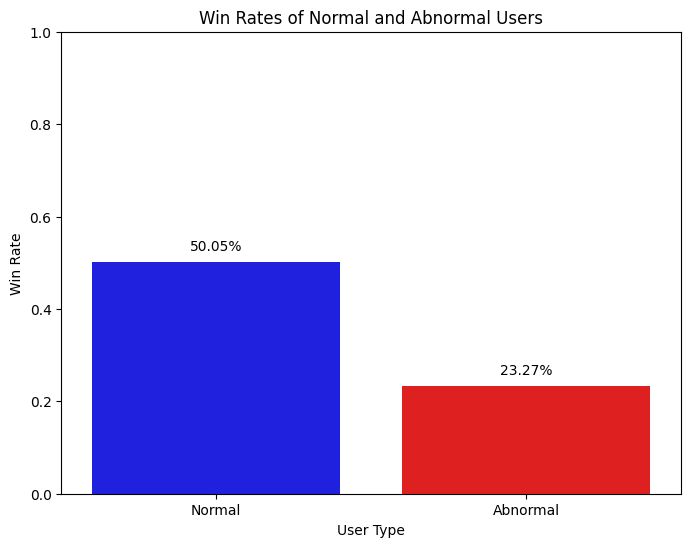

Comparison of Normal and Abnormal Users


,level_0,level_1,tier,timePlayed,teamId,champion_kills,monster_kills,building_kills,kill_involve_ratio,deaths,cs,champExperience,item_duplication,totalDamageDealtToChampions,damageDealtToObjectives,totalTimeSpentDead,visionScore,abilityUses,skillshotsDodged,laneMinionsFirst10Minutes,alliedJungleMonsterKills,enemyJungleMonsterKills,kda,jungleCsBefore10Minutes,tower_involve_ratio,object_involve_ratio,average_transaction_margin_per_10min,delta_attack_stat,delta_attackSpeed,delta_defense_stat,delta_max_health,no_moving_minute,deathBefore10Minutes,goldBefore10Minutes,level10Minutes,gold_margin
0,Normal Users,mean,5.373818,26.705865,149.997118,27.013713,5.013901,5.940318,0.469582,5.404165,151.173658,12268.101443,1.039834,18352.538439,10838.979802,140.686896,29.051142,251.856570,34.062165,42.535904,13.384390,2.531137,3.563029,11.199474,13.479719,19.406276,7.344943,10.042517,3.061580,4.416737,71.375571,0.003575,1.583286,3400.390393,7.012550,836.626951
1,Normal Users,std,2.653964,6.926876,50.000037,11.895070,2.912516,4.496822,0.170083,3.106946,78.259199,4452.765187,0.214815,11521.858560,12680.086074,100.828028,23.728190,167.630867,55.015871,30.278780,25.762492,5.683394,3.772382,22.658324,20.673195,35.683872,1.499212,4.776407,2.563981,2.453608,22.184134,0.059688,1.289783,668.766122,1.042188,890.587340
2,Abnormal Users,mean,3.426833,27.248114,151.387900,24.321708,3.850534,4.429893,0.277891,4.935943,97.868327,8608.099644,1.066904,10424.291815,5360.340925,116.951601,18.296797,158.361566,26.826335,34.279715,9.475445,1.261922,1.825634,9.494520,6.850890,13.627260,5.042819,6.923060,2.096014,3.055872,50.993167,5.804270,1.809253,2998.225623,6.429181,1402.071174
3,Abnormal Users,std,2.265755,7.888088,49.998530,13.635324,2.772038,4.220958,0.186389,3.366103,65.287500,4757.858228,0.299229,9385.166994,8692.005003,107.521444,19.616466,119.609474,56.473487,27.091660,20.234670,3.761934,2.141336,20.211664,15.437318,31.478178,1.968728,3.323643,1.758111,2.017502,20.034671,5.416760,1.429960,682.271456,1.447614,1140.907278


In [207]:
# 비정상 유저와 정상 유저 데이터 분리
abnormal_users = normal_df[normal_df['no_moving_minute'] > 1]
normal_users = normal_df[normal_df['no_moving_minute'] <= 1]

# 정상 유저와 비정상 유저의 승률 계산
abnormal_win_rate = abnormal_users['win'].mean()
normal_win_rate = normal_users['win'].mean()

# 정상 유저와 비정상 유저의 통계 비교
comparison_stats = pd.concat([
    normal_users.describe().loc[['mean', 'std']],
    abnormal_users.describe().loc[['mean', 'std']]
], keys=['Normal Users', 'Abnormal Users']).reset_index()

# 승률 시각화
plt.figure(figsize=(8, 6))
win_rates = pd.DataFrame({
    'User Type': ['Normal', 'Abnormal'],
    'Win Rate': [normal_win_rate, abnormal_win_rate]
})
ax = sns.barplot(x='User Type', y='Win Rate', data=win_rates, palette=['blue', 'red'])
for i, win_rate in enumerate(win_rates['Win Rate']):
    ax.text(i, win_rate + 0.02, f'{win_rate:.2%}', ha='center', va='bottom')
plt.title('Win Rates of Normal and Abnormal Users')
plt.ylabel('Win Rate')
plt.xlabel('User Type')
plt.ylim(0, 1)
plt.show()

# 비교 통계 출력
print("Comparison of Normal and Abnormal Users")
display(comparison_stats)

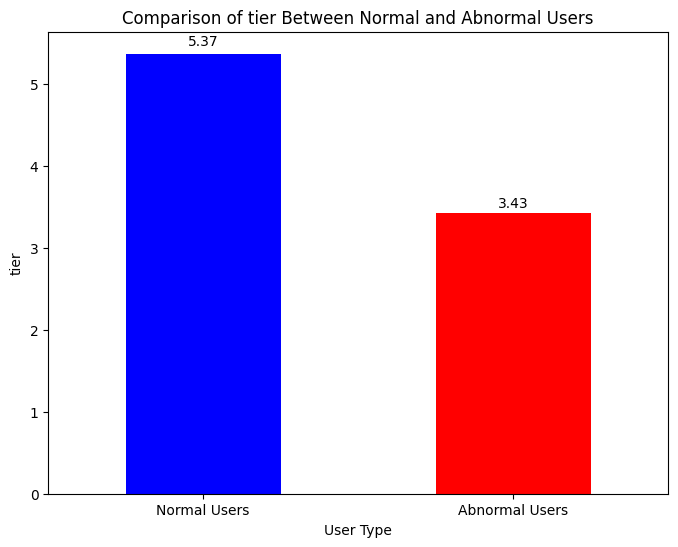

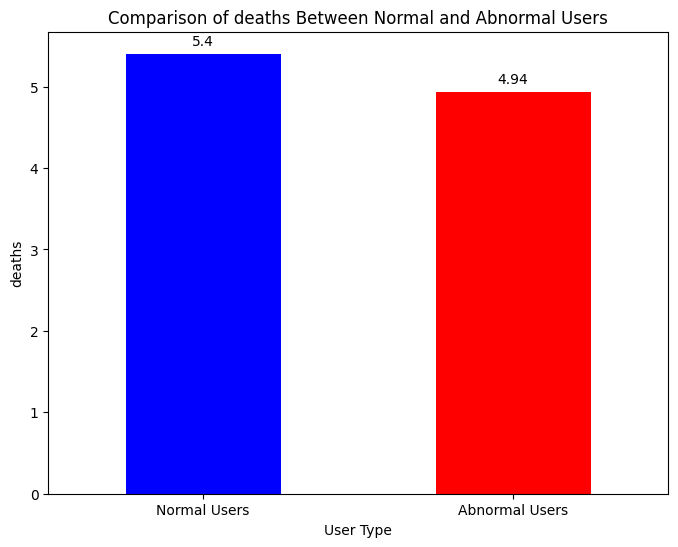

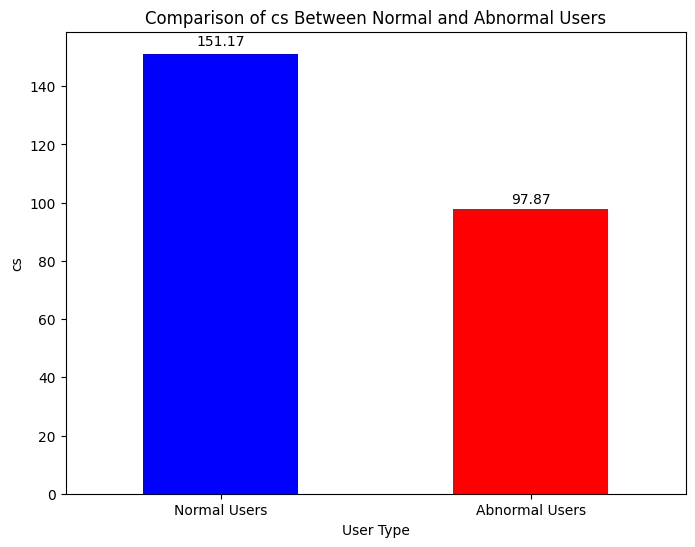

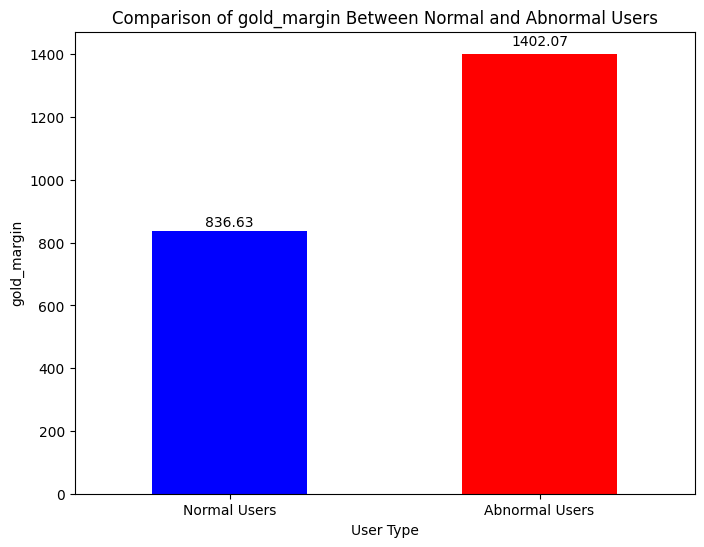

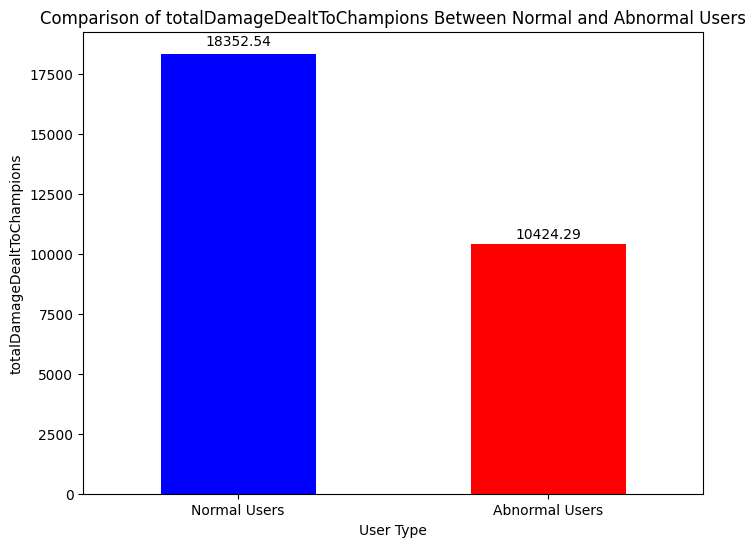

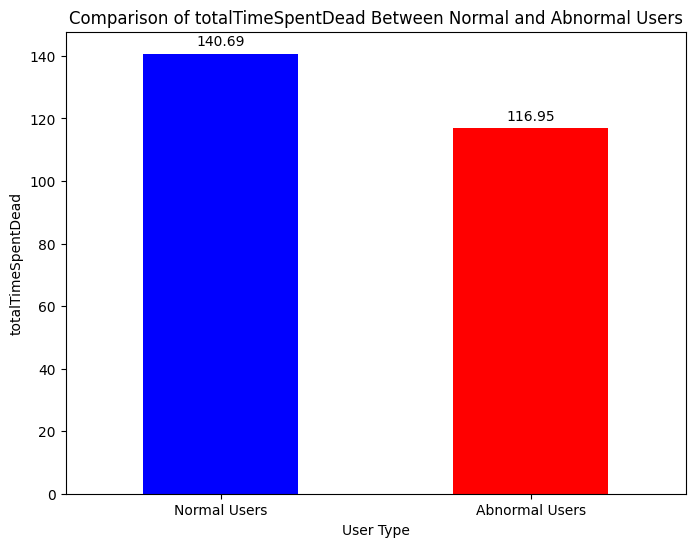

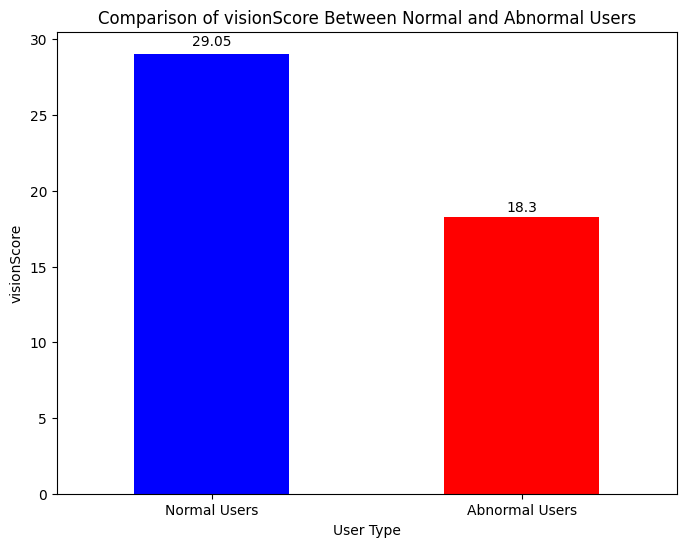

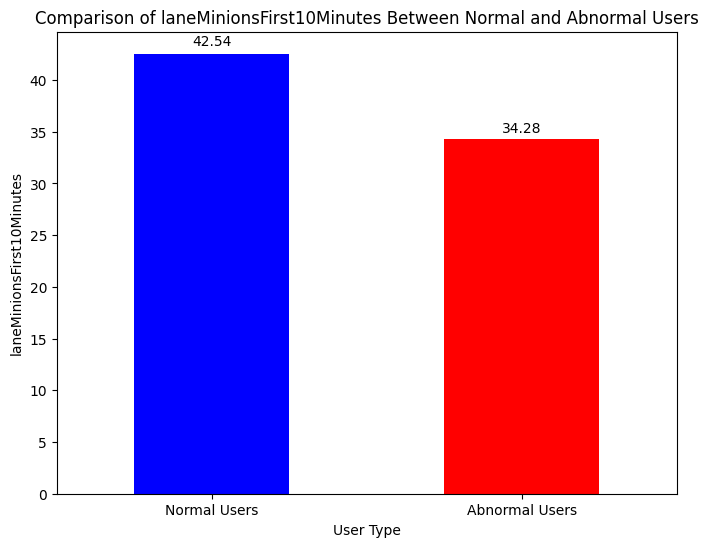

In [208]:
# 유의미한 차이가 나는 변수 선택 (차이가 큰 변수들을 임의로 선택)
significant_columns = [
    'tier', 'deaths', 'cs', 'gold_margin',
    'totalDamageDealtToChampions', 'totalTimeSpentDead', 'visionScore', 'laneMinionsFirst10Minutes'
]

# 주요 변수 평균 계산
normal_means = comparison_stats.loc[0,significant_columns]
abnormal_means = comparison_stats.loc[2,significant_columns]

comparison_means = pd.DataFrame({
    'Normal Users': normal_means[significant_columns],
    'Abnormal Users': abnormal_means[significant_columns]
})

# 평균값 시각화
for column in significant_columns:
    plt.figure(figsize=(8, 6))
    bar_data = comparison_means.loc[column]
    bar_data.plot(kind='bar', color=['blue', 'red'])
    plt.title(f'Comparison of {column} Between Normal and Abnormal Users')
    plt.ylabel(column)
    plt.xticks(rotation=0)
    plt.xlabel('User Type')
    
    # 막대기 위에 수치 표시
    for i, value in enumerate(bar_data):
        plt.text(i, value + (0.02 * value), round(value, 2), ha='center')
    
    plt.show()

Chi-squared test statistic: 385.98594878550665
p-value: 6.190882037384218e-86


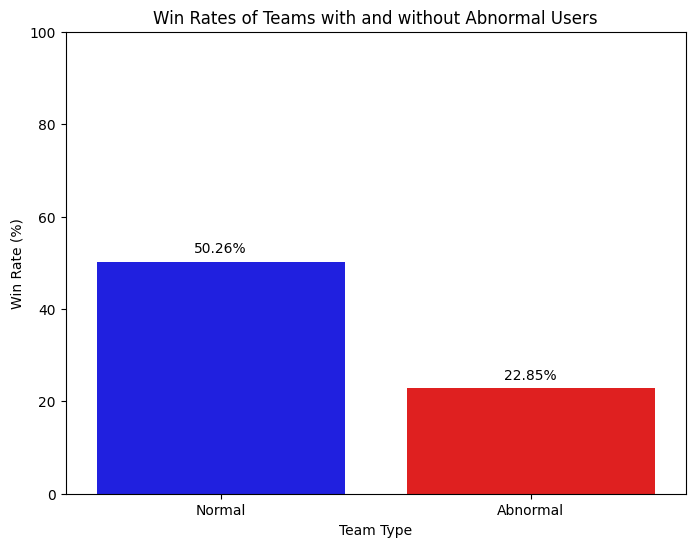

In [209]:
team_abnormal_flag = normal_df.groupby(['match_id', 'teamId'])['no_moving_minute'].apply(lambda x: (x > 1).any()).reset_index()
team_abnormal_flag.columns = ['match_id', 'teamId', 'has_abnormal']

# 팀 단위 승리 정보와 합치기
team_results = normal_df.groupby(['match_id', 'teamId'])['win'].first().reset_index()
team_results = team_results.merge(team_abnormal_flag, on=['match_id', 'teamId'])

# 비정상 유저가 있는 팀과 없는 팀 분리
teams_with_abnormal = team_results[team_results['has_abnormal'] == True]
teams_without_abnormal = team_results[team_results['has_abnormal'] == False]

# 승리와 패배 횟수 집계
win_counts = pd.DataFrame({
    'win': [teams_without_abnormal['win'].sum(), teams_with_abnormal['win'].sum()],
    'total': [teams_without_abnormal.shape[0], teams_with_abnormal.shape[0]]
}, index=['Normal', 'Abnormal'])

# 승률 계산
win_counts['win_rate'] = win_counts['win'] / win_counts['total'] * 100

# 카이제곱 검정 수행
chi2, p, _, _ = chi2_contingency([win_counts['win'], win_counts['total'] - win_counts['win']])

# 결과 출력
print("Chi-squared test statistic:", chi2)
print("p-value:", p)

# 승률 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=win_counts.index, y=win_counts['win_rate'], palette=['blue', 'red'])
plt.title('Win Rates of Teams with and without Abnormal Users')
plt.ylabel('Win Rate (%)')
plt.xlabel('Team Type')
plt.ylim(0, 100)

# 승률 값 표시
for i in range(len(win_counts)):
    plt.text(i, win_counts['win_rate'][i] + 2, f"{win_counts['win_rate'][i]:.2f}%", ha='center')

plt.show()

In [210]:
# afk 컬럼 생성
normal_df['afk'] = normal_df['no_moving_minute'] > 1

# no_moving_minute 컬럼 드롭
normal_df.drop(columns=['no_moving_minute'], inplace=True)

# Involve

Optimization terminated successfully.
         Current function value: 0.653665
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:               135594
Model:                          Logit   Df Residuals:                   135591
Method:                           MLE   Df Model:                            2
Date:                Wed, 07 Aug 2024   Pseudo R-squ.:                 0.05696
Time:                        22:03:47   Log-Likelihood:                -88633.
converged:                       True   LL-Null:                       -93987.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.2096      0.028    -77.839      0.000      -2.265      -2.154

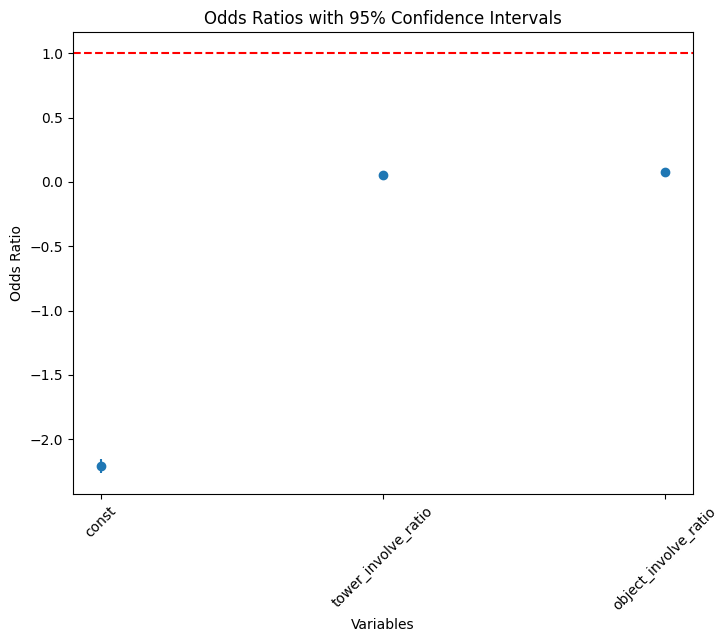

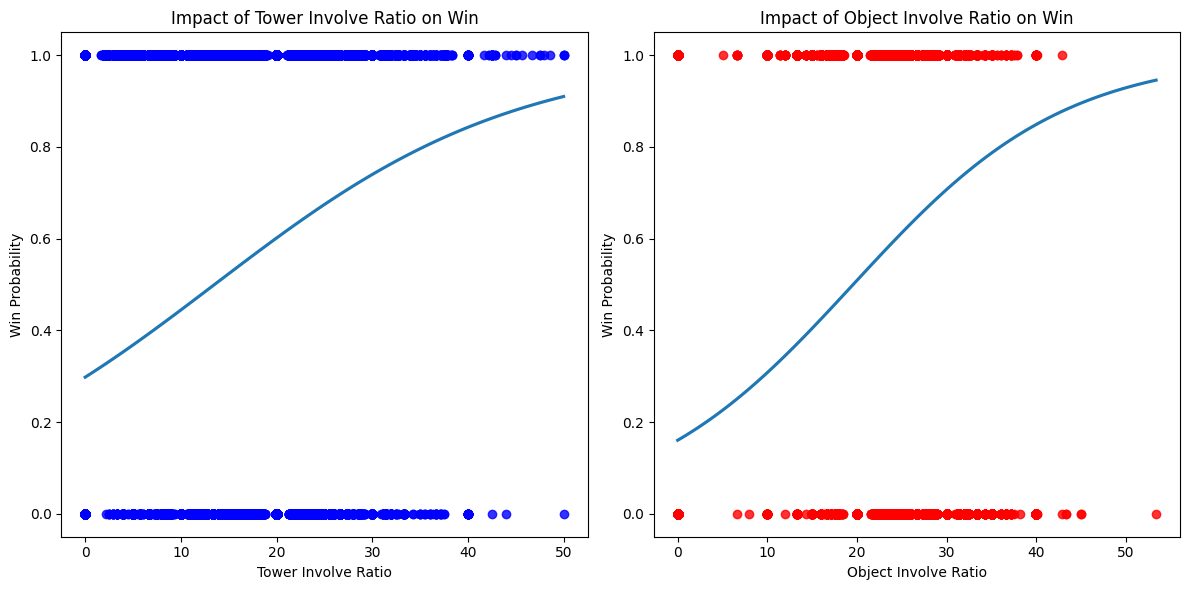

In [211]:
# 타워 철거 관여 비율과 에픽 몬스터 처치 관여 비율을 포함하여 팀별로 집계
team_data = normal_df.groupby(['match_id', 'teamId']).agg({
    'win': 'first',
    'tower_involve_ratio': 'mean',
    'object_involve_ratio': 'mean'
}).reset_index()

# 종속 변수 (win)와 독립 변수 (tower_involve_ratio, object_involve_ratio)
X = team_data[['tower_involve_ratio', 'object_involve_ratio']]
y = team_data['win'].astype(int)  # 승리를 이진 변수로 변환

# 상수 추가
X = sm.add_constant(X)

# 로지스틱 회귀 모델 적합
model = sm.Logit(y, X).fit()

# 결과 요약
print(model.summary())

# 회귀 계수 시각화
params = model.params
conf = model.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']

plt.figure(figsize=(8, 6))
plt.errorbar(conf.index, conf['OR'], yerr=[conf['OR'] - conf['Lower CI'], conf['Upper CI'] - conf['OR']], fmt='o')
plt.title('Odds Ratios with 95% Confidence Intervals')
plt.ylabel('Odds Ratio')
plt.xlabel('Variables')
plt.xticks(rotation=45)
plt.axhline(y=1, linestyle='--', color='red')
plt.show()

# 변수별 영향 시각화
plt.figure(figsize=(12, 6))

# tower_involve_ratio의 영향
plt.subplot(1, 2, 1)
sns.regplot(x='tower_involve_ratio', y='win', data=team_data, logistic=True, ci=None, scatter_kws={'color': 'blue'})
plt.title('Impact of Tower Involve Ratio on Win')
plt.xlabel('Tower Involve Ratio')
plt.ylabel('Win Probability')

# object_involve_ratio의 영향
plt.subplot(1, 2, 2)
sns.regplot(x='object_involve_ratio', y='win', data=team_data, logistic=True, ci=None, scatter_kws={'color': 'red'})
plt.title('Impact of Object Involve Ratio on Win')
plt.xlabel('Object Involve Ratio')
plt.ylabel('Win Probability')

plt.tight_layout()
plt.show()

Optimization terminated successfully.
         Current function value: 0.654083
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:               135594
Model:                          Logit   Df Residuals:                   135592
Method:                           MLE   Df Model:                            1
Date:                Wed, 07 Aug 2024   Pseudo R-squ.:                 0.05636
Time:                        22:03:48   Log-Likelihood:                -88690.
converged:                       True   LL-Null:                       -93987.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.0432      0.023    -89.717      0.000      -2.088      -1.999
involve_

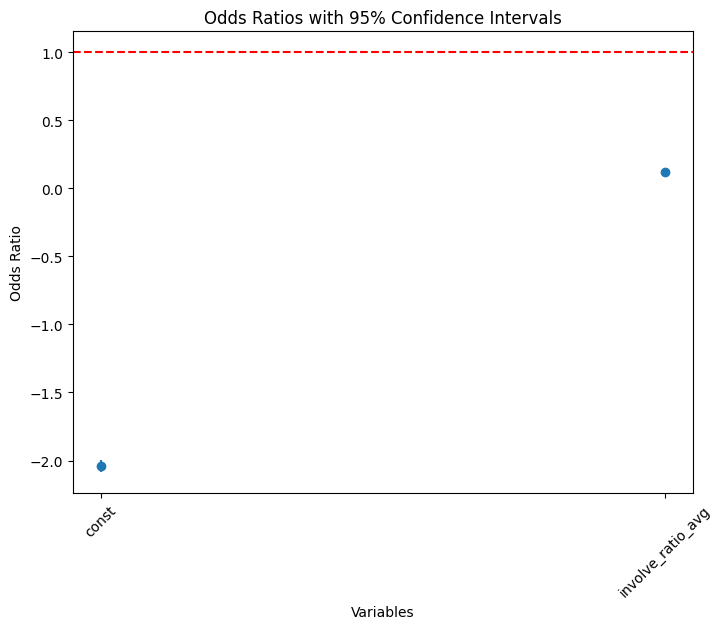

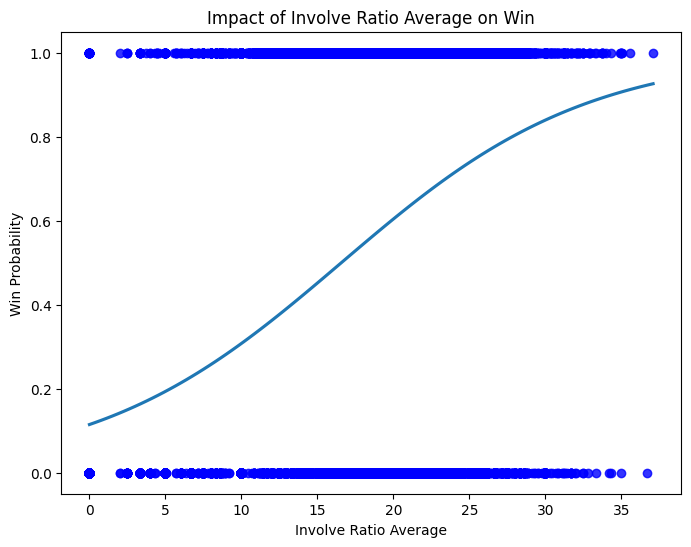

In [212]:
# 타워 철거 관여 비율과 에픽 몬스터 처치 관여 비율의 평균 값을 계산하여 새로운 변수 추가
normal_df['involve_ratio_avg'] = normal_df[['tower_involve_ratio', 'object_involve_ratio']].mean(axis=1)

# 팀별로 평균 값 집계
team_data = normal_df.groupby(['match_id', 'teamId']).agg({
    'win': 'first',
    'involve_ratio_avg': 'mean'
}).reset_index()

# 종속 변수 (win)와 독립 변수 (involve_ratio_avg)
X = team_data[['involve_ratio_avg']]
y = team_data['win'].astype(int)  # 승리를 이진 변수로 변환

# 상수 추가
X = sm.add_constant(X)

# 로지스틱 회귀 모델 적합
model = sm.Logit(y, X).fit()

# 결과 요약
print(model.summary())

# 회귀 계수 시각화
params = model.params
conf = model.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']

plt.figure(figsize=(8, 6))
plt.errorbar(conf.index, conf['OR'], yerr=[conf['OR'] - conf['Lower CI'], conf['Upper CI'] - conf['OR']], fmt='o')
plt.title('Odds Ratios with 95% Confidence Intervals')
plt.ylabel('Odds Ratio')
plt.xlabel('Variables')
plt.xticks(rotation=45)
plt.axhline(y=1, linestyle='--', color='red')
plt.show()

# 변수별 영향 시각화
plt.figure(figsize=(8, 6))
sns.regplot(x='involve_ratio_avg', y='win', data=team_data, logistic=True, ci=None, scatter_kws={'color': 'blue'})
plt.title('Impact of Involve Ratio Average on Win')
plt.xlabel('Involve Ratio Average')
plt.ylabel('Win Probability')
plt.show()

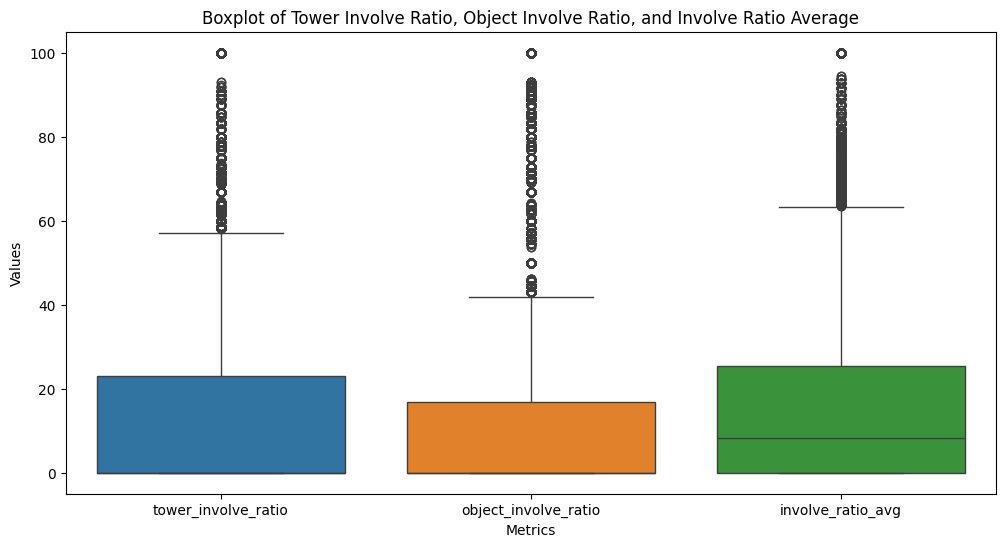

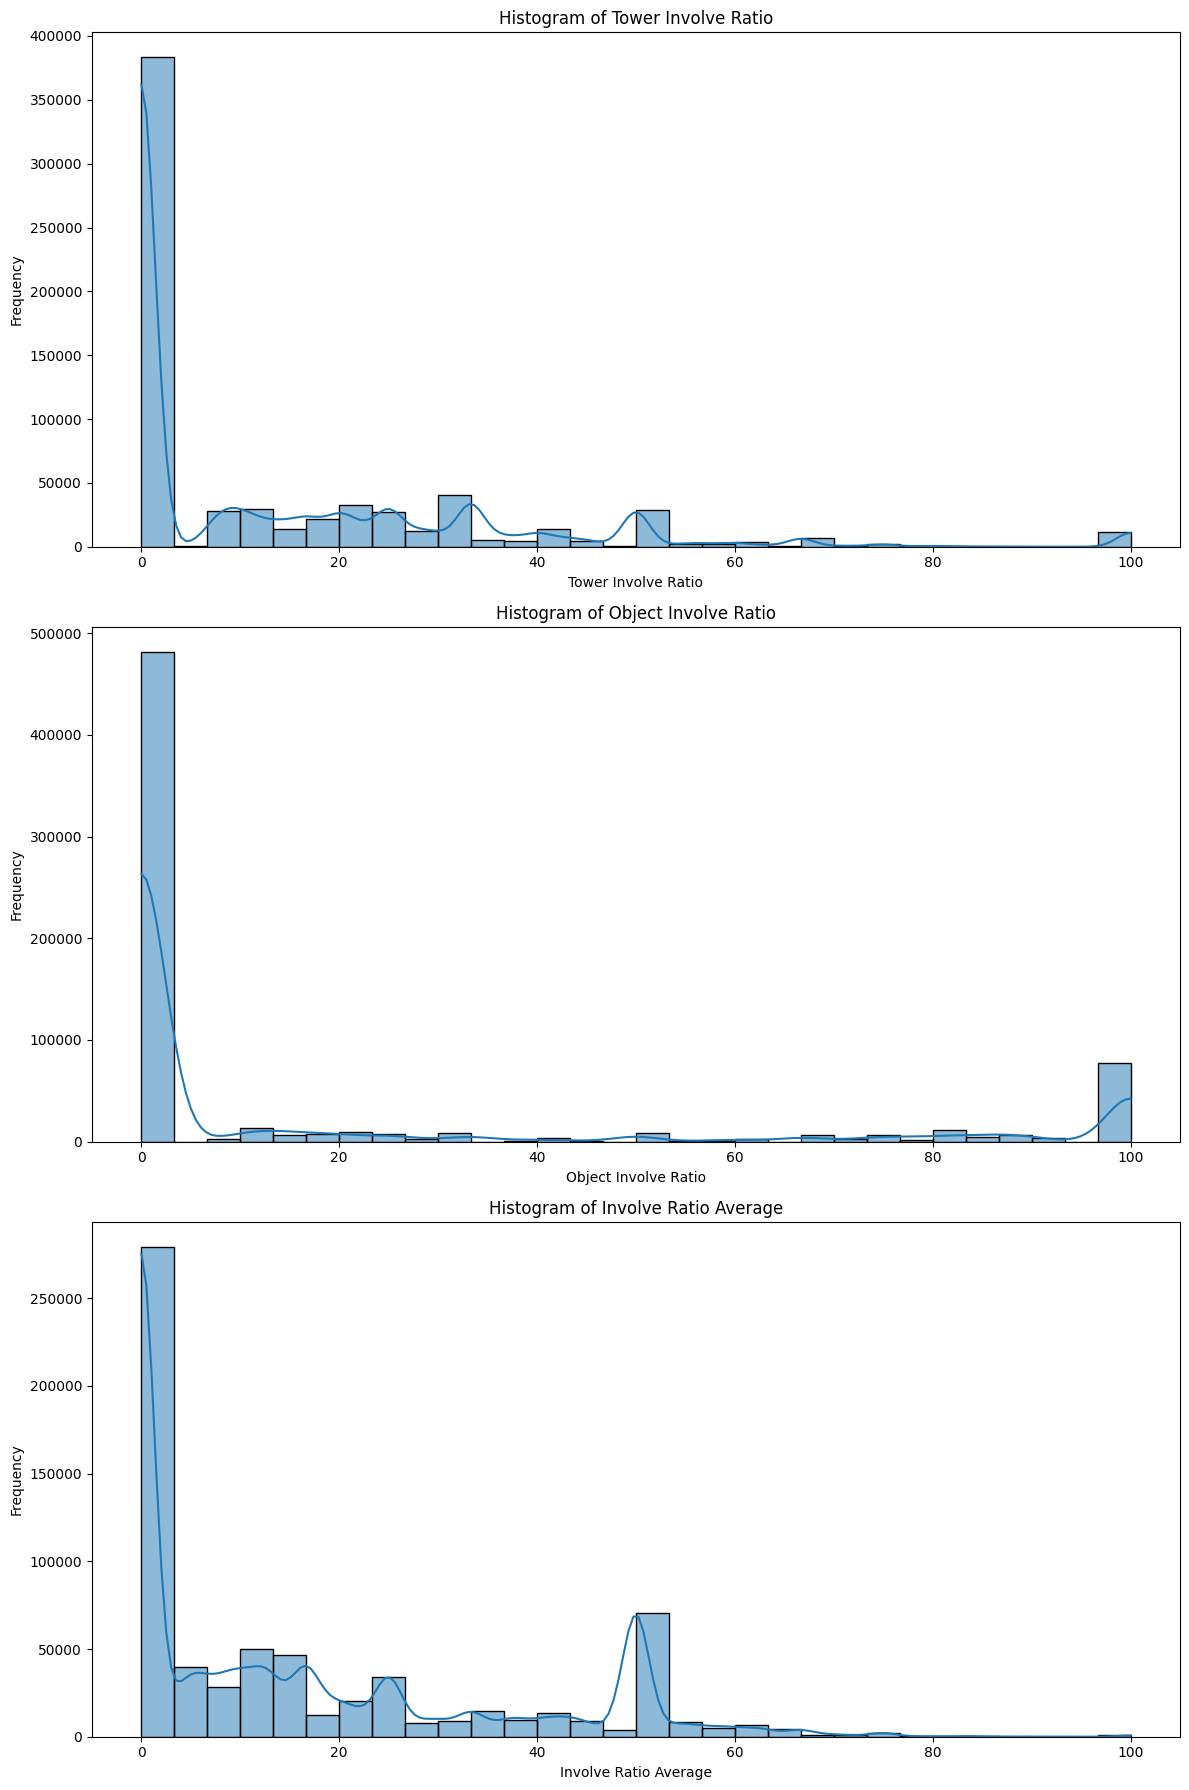

In [213]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=normal_df[['tower_involve_ratio', 'object_involve_ratio', 'involve_ratio_avg']])
plt.title('Boxplot of Tower Involve Ratio, Object Involve Ratio, and Involve Ratio Average')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.show()

# 히스토그램 시각화
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 타워 철거 관여 비율 히스토그램
sns.histplot(normal_df['tower_involve_ratio'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Tower Involve Ratio')
axes[0].set_xlabel('Tower Involve Ratio')
axes[0].set_ylabel('Frequency')

# 에픽 몬스터 처치 관여 비율 히스토그램
sns.histplot(normal_df['object_involve_ratio'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Histogram of Object Involve Ratio')
axes[1].set_xlabel('Object Involve Ratio')
axes[1].set_ylabel('Frequency')

# 평균 관여 비율 히스토그램
sns.histplot(normal_df['involve_ratio_avg'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Histogram of Involve Ratio Average')
axes[2].set_xlabel('Involve Ratio Average')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [214]:
team_stats = normal_df.groupby(['match_id', 'teamId']).agg({
    'champion_kills': 'sum',
    'monster_kills': 'sum',
    'building_kills': 'sum',
    'win': 'mean'
}).reset_index()

# 각 지표의 중위수를 기준으로 그룹 나누기
median_champion_kills = team_stats['champion_kills'].median()
median_monster_kills = team_stats['monster_kills'].median()
median_building_kills = team_stats['building_kills'].median()

team_stats['high_champion_kills'] = team_stats['champion_kills'] > median_champion_kills
team_stats['high_monster_kills'] = team_stats['monster_kills'] > median_monster_kills
team_stats['high_building_kills'] = team_stats['building_kills'] > median_building_kills

# 카이제곱 검정 함수
def chi2_test(stat):
    contingency_table = pd.crosstab(team_stats[stat], team_stats['win'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    return chi2, p

# 검정 결과 출력
for stat in ['high_champion_kills', 'high_monster_kills', 'high_building_kills']:
    chi2, p = chi2_test(stat)
    print(f"Chi-squared test for {stat}: chi2 = {chi2:.2f}, p-value = {p:.6f}")

Chi-squared test for high_champion_kills: chi2 = 26381.19, p-value = 0.000000
Chi-squared test for high_monster_kills: chi2 = 24313.06, p-value = 0.000000
Chi-squared test for high_building_kills: chi2 = 57066.59, p-value = 0.000000


Thresholds for low involvement based on winning teams' means and standard deviations:
{'kill_involve_ratio': 0.16427721505331988, 'tower_involve_ratio': -20.211723266071203, 'object_involve_ratio': -49.88627370623634}

Number of users in losing teams with low involvement ratios:
{'kill_involve_ratio': 17848, 'tower_involve_ratio': 0, 'object_involve_ratio': 0}

Rate of losing teams with at least one user with low involvement: 5.28%


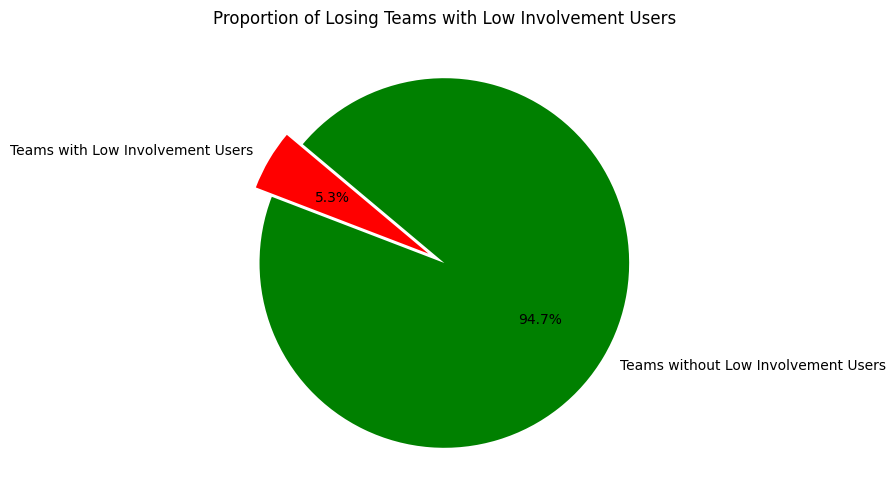

In [216]:
# afk == False인 행만 필터링
losing_teams = normal_df[(normal_df['win'] == 0) & (normal_df['afk'] == False)]
winning_teams = normal_df[(normal_df['win'] == 1) & (normal_df['afk'] == False)]

# 관여 지표
involvement_stats = ['kill_involve_ratio', 'tower_involve_ratio', 'object_involve_ratio']

# 패배한 팀에서 관여 비율이 낮은 유저 식별
thresholds = {stat: winning_teams[stat].mean() - 2 * winning_teams[stat].std() for stat in involvement_stats}

print("Thresholds for low involvement based on winning teams' means and standard deviations:")
print(thresholds)

# 패배한 팀의 유저 중 관여 비율이 낮은 유저 식별
for stat in involvement_stats:
    losing_teams.loc[:, f'low_{stat}'] = losing_teams[stat] < thresholds[stat]

# 각 지표별로 고의로 관여하지 않은 유저 수
low_involvement_counts = {stat: losing_teams[f'low_{stat}'].sum() for stat in involvement_stats}

print("\nNumber of users in losing teams with low involvement ratios:")
print(low_involvement_counts)

# 고의로 관여하지 않은 유저가 있는 팀과 그렇지 않은 팀 분리
teams_with_low_involvement = losing_teams[losing_teams[[f'low_{stat}' for stat in involvement_stats]].any(axis=1)]
teams_without_low_involvement = losing_teams[~losing_teams[[f'low_{stat}' for stat in involvement_stats]].any(axis=1)]

# 승률 계산 (패배한 팀에서 관여 비율이 낮은 유저가 있는 팀과 그렇지 않은 팀의 승률은 모두 0이므로, 추가적인 분석은 필요하지 않음)
# 대신, 고의로 관여하지 않은 유저의 비율을 계산
low_involvement_rate = len(teams_with_low_involvement) / len(losing_teams) * 100

print(f"\nRate of losing teams with at least one user with low involvement: {low_involvement_rate:.2f}%")

# 시각화
plt.figure(figsize=(10, 6))
labels = ['Teams with Low Involvement Users', 'Teams without Low Involvement Users']
counts = [len(teams_with_low_involvement), len(teams_without_low_involvement)]
colors = ['red', 'green']

plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=(0.1, 0))
plt.title('Proportion of Losing Teams with Low Involvement Users')
plt.show()


T-test for champion_kills: t-statistic = -104.42, p-value = 0.000000
T-test for monster_kills: t-statistic = -54.43, p-value = 0.000000
T-test for building_kills: t-statistic = -68.33, p-value = 0.000000
T-test for deaths: t-statistic = -49.08, p-value = 0.000000
T-test for cs: t-statistic = -25.72, p-value = 0.000000
T-test for champExperience: t-statistic = -84.92, p-value = 0.000000
T-test for totalDamageDealtToChampions: t-statistic = -104.08, p-value = 0.000000
T-test for damageDealtToObjectives: t-statistic = -61.74, p-value = 0.000000
T-test for totalTimeSpentDead: t-statistic = -60.04, p-value = 0.000000
T-test for visionScore: t-statistic = -85.51, p-value = 0.000000
T-test for abilityUses: t-statistic = -62.25, p-value = 0.000000
T-test for skillshotsDodged: t-statistic = -27.08, p-value = 0.000000
T-test for laneMinionsFirst10Minutes: t-statistic = 60.36, p-value = 0.000000
T-test for alliedJungleMonsterKills: t-statistic = -50.48, p-value = 0.000000
T-test for enemyJungleMo

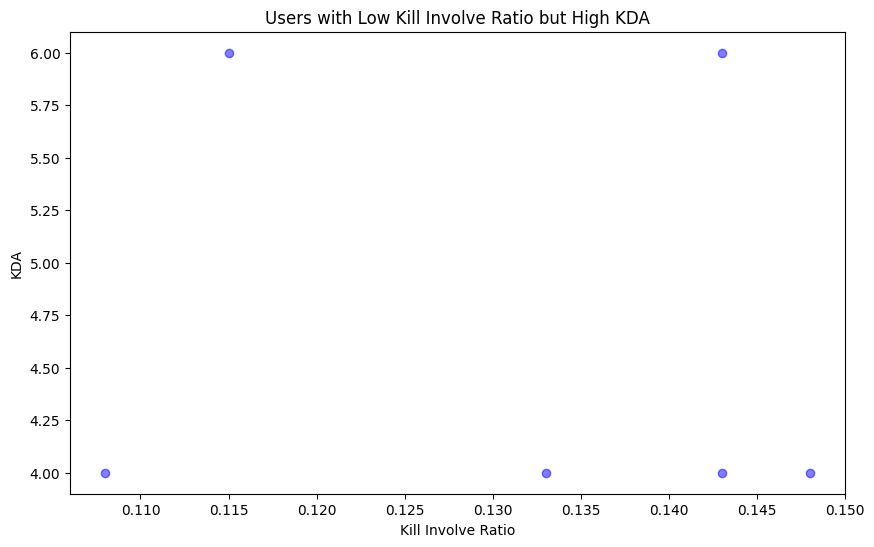

In [238]:
other_stats = ['champion_kills', 'monster_kills', 'building_kills', 'deaths', 'cs', 'champExperience',
               'totalDamageDealtToChampions', 'damageDealtToObjectives', 'totalTimeSpentDead', 'visionScore',
               'abilityUses', 'skillshotsDodged', 'laneMinionsFirst10Minutes', 'alliedJungleMonsterKills',
               'enemyJungleMonsterKills', 'jungleCsBefore10Minutes', 'average_transaction_margin_per_10min',
               'delta_attack_stat', 'delta_attackSpeed', 'delta_defense_stat', 'delta_max_health',
               'deathBefore10Minutes', 'goldBefore10Minutes', 'level10Minutes', 'gold_margin', 'kda']

# t-검정 수행
for stat in other_stats:
    # NaN 값 제거
    teams_with_low_involvement_stat = teams_with_low_involvement[stat].dropna()
    teams_without_low_involvement_stat = teams_without_low_involvement[stat].dropna()

    # t-검정 수행
    t_stat, p_val = ttest_ind(teams_with_low_involvement_stat, teams_without_low_involvement_stat)
    print(f"T-test for {stat}: t-statistic = {t_stat:.2f}, p-value = {p_val:.6f}")

# KDA 임계치 설정 (평균에서 표준편차의 일부를 뺀 값)
# kda_threshold = losing_teams['kda'].mean()
kda_threshold = 3

# 관여율 지표는 낮지만 KDA가 양호한 유저 식별
low_involvement_high_kda = losing_teams[losing_teams['low_kill_involve_ratio'] & (losing_teams['kda'] > kda_threshold)]

print("\nNumber of users with low involvement but high KDA:")
print(len(low_involvement_high_kda))

# 해당 유저들의 KDA와 kill_involve_ratio 비교 시각화
plt.figure(figsize=(10, 6))
plt.scatter(low_involvement_high_kda['kill_involve_ratio'], low_involvement_high_kda['kda'], color='blue', alpha=0.5)
plt.title('Users with Low Kill Involve Ratio but High KDA')
plt.xlabel('Kill Involve Ratio')
plt.ylabel('KDA')
plt.show()

# Item & Gold

In [143]:
threshold = normal_df['average_transaction_margin_per_10min'].quantile(0.95)
high_margin_users = normal_df[normal_df['average_transaction_margin_per_10min'] > threshold]
low_margin_users = normal_df[normal_df['average_transaction_margin_per_10min'] <= threshold]

# 두 그룹의 주요 지표 통계 분석
high_margin_stats = high_margin_users.describe()
low_margin_stats = low_margin_users.describe()

# 결과 확인
print("High Margin Users Stats")
display(high_margin_stats)
print("\nLow Margin Users Stats")
display(low_margin_stats)

High Margin Users Stats


,tier,timePlayed,teamId,champion_kills,monster_kills,building_kills,kill_involve_ratio,deaths,cs,champExperience,item_duplication,totalDamageDealtToChampions,damageDealtToObjectives,totalTimeSpentDead,visionScore,abilityUses,skillshotsDodged,laneMinionsFirst10Minutes,alliedJungleMonsterKills,enemyJungleMonsterKills,jungleCsBefore10Minutes,average_transaction_margin_per_10min,delta_attack_stat,delta_attackSpeed,delta_defense_stat,delta_max_health,deathBefore10Minutes,goldBefore10Minutes,level10Minutes,gold_margin,involve_ratio_avg
count,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.00000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000,24261.000000
mean,6.915486,23.846709,150.175178,27.154033,5.325255,5.821071,0.540619,4.925642,103.334323,10175.747661,1.05243,14614.627344,6363.642925,106.046412,45.474671,196.744652,34.031285,38.604138,4.524546,1.090928,3.970057,11.041251,8.838424,2.976254,4.538976,76.828659,1.824533,3490.585466,6.694077,601.289765,10.623701
std,2.431688,6.003186,50.000724,10.262080,2.770877,4.165804,0.154960,3.017398,78.676302,3694.254610,0.32518,9260.252289,8599.953816,81.199736,35.974676,122.851795,50.337632,30.678743,14.804762,3.381984,14.247692,0.881496,5.188159,3.005966,2.313162,22.737298,1.362767,823.101970,1.226921,906.835738,16.014920
min,1.000000,10.100000,100.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1060.000000,0.00000,941.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.200000,-0.400000,-2.500000,0.000000,22.100000,0.000000,1839.000000,3.000000,-36603.000000,0.000000
25%,5.000000,19.000000,100.000000,20.000000,3.000000,2.000000,0.440000,3.000000,26.000000,7506.000000,1.00000,7763.000000,1044.000000,43.000000,18.000000,113.000000,7.000000,11.000000,0.000000,0.000000,0.000000,10.480000,4.200000,1.000000,2.900000,60.000000,1.000000,2847.000000,6.000000,228.000000,0.000000
50%,8.000000,23.800000,200.000000,27.000000,5.000000,5.000000,0.545000,5.000000,107.000000,9737.000000,1.00000,12004.000000,3083.000000,89.000000,32.000000,163.000000,16.000000,19.000000,0.000000,0.000000,0.000000,10.770000,8.600000,1.600000,4.000000,72.600000,2.000000,3394.000000,6.000000,538.000000,0.000000
75%,9.000000,28.000000,200.000000,34.000000,7.000000,9.000000,0.647000,7.000000,169.000000,12577.000000,1.00000,19331.000000,7971.000000,153.000000,69.000000,243.000000,39.000000,69.000000,0.000000,0.000000,0.000000,11.330000,12.100000,4.300000,5.500000,91.700000,3.000000,4018.000000,8.000000,981.000000,16.650000
max,10.000000,54.500000,200.000000,81.000000,15.000000,18.000000,1.000000,20.000000,389.000000,27820.000000,6.00000,83103.000000,75306.000000,663.000000,277.000000,1369.000000,662.000000,109.000000,118.000000,43.000000,82.000000,44.380000,55.500000,43.500000,32.000000,266.800000,9.000000,8957.000000,10.000000,5598.000000,100.000000



Low Margin Users Stats


,tier,timePlayed,teamId,champion_kills,monster_kills,building_kills,kill_involve_ratio,deaths,cs,champExperience,item_duplication,totalDamageDealtToChampions,damageDealtToObjectives,totalTimeSpentDead,visionScore,abilityUses,skillshotsDodged,laneMinionsFirst10Minutes,alliedJungleMonsterKills,enemyJungleMonsterKills,jungleCsBefore10Minutes,average_transaction_margin_per_10min,delta_attack_stat,delta_attackSpeed,delta_defense_stat,delta_max_health,deathBefore10Minutes,goldBefore10Minutes,level10Minutes,gold_margin,involve_ratio_avg
count,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000,653709.000000
mean,5.312418,26.813142,149.993499,27.002720,4.999845,5.941497,0.466534,5.420918,152.834544,12337.888294,1.039424,18474.222972,10993.297183,141.921490,28.418504,253.700983,34.047760,42.664078,13.704803,2.581860,11.464114,7.202814,10.080500,3.062672,4.409275,71.129384,1.574818,3396.178635,7.023116,846.576278,16.645634
std,2.645288,6.938383,50.000038,11.955986,2.917195,4.508551,0.170310,3.109463,77.694824,4463.622869,0.209816,11575.979443,12771.887411,101.277016,22.920472,168.688683,55.186034,30.250014,26.012954,5.741094,22.862423,1.337848,4.754176,2.544973,2.458500,22.152819,1.286489,662.397484,1.034226,889.767886,19.863197
min,1.000000,10.100000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.800000,-3.100000,-1.300000,0.000000,0.000000,1500.000000,1.000000,-51485.000000,0.000000
25%,3.000000,22.100000,100.000000,18.000000,3.000000,2.000000,0.353000,3.000000,105.000000,8989.000000,1.000000,9702.000000,1984.000000,64.000000,14.000000,142.000000,7.000000,10.000000,0.000000,0.000000,0.000000,6.250000,7.200000,1.200000,2.800000,55.700000,1.000000,2943.000000,6.000000,310.000000,0.000000
50%,5.000000,26.900000,100.000000,27.000000,5.000000,5.000000,0.471000,5.000000,161.000000,12131.000000,1.000000,16128.000000,6100.000000,125.000000,21.000000,212.000000,16.000000,53.000000,0.000000,0.000000,0.000000,7.200000,9.600000,2.000000,3.700000,66.100000,1.000000,3357.000000,7.000000,700.000000,8.400000
75%,7.000000,31.400000,200.000000,35.000000,7.000000,10.000000,0.583000,7.000000,206.000000,15274.000000,1.000000,24606.000000,15432.000000,201.000000,33.000000,315.000000,37.000000,69.000000,7.000000,2.000000,0.000000,8.120000,12.500000,4.500000,5.100000,81.400000,2.000000,3800.000000,8.000000,1278.000000,27.000000
max,10.000000,62.700000,200.000000,82.000000,15.000000,23.000000,1.000000,28.000000,694.000000,45990.000000,6.000000,166916.000000,128259.000000,1026.000000,298.000000,2137.000000,1198.000000,112.000000,207.000000,98.000000,105.000000,10.000000,52.200000,52.100000,56.100000,335.500000,12.000000,8059.000000,10.000000,13910.000000,100.000000


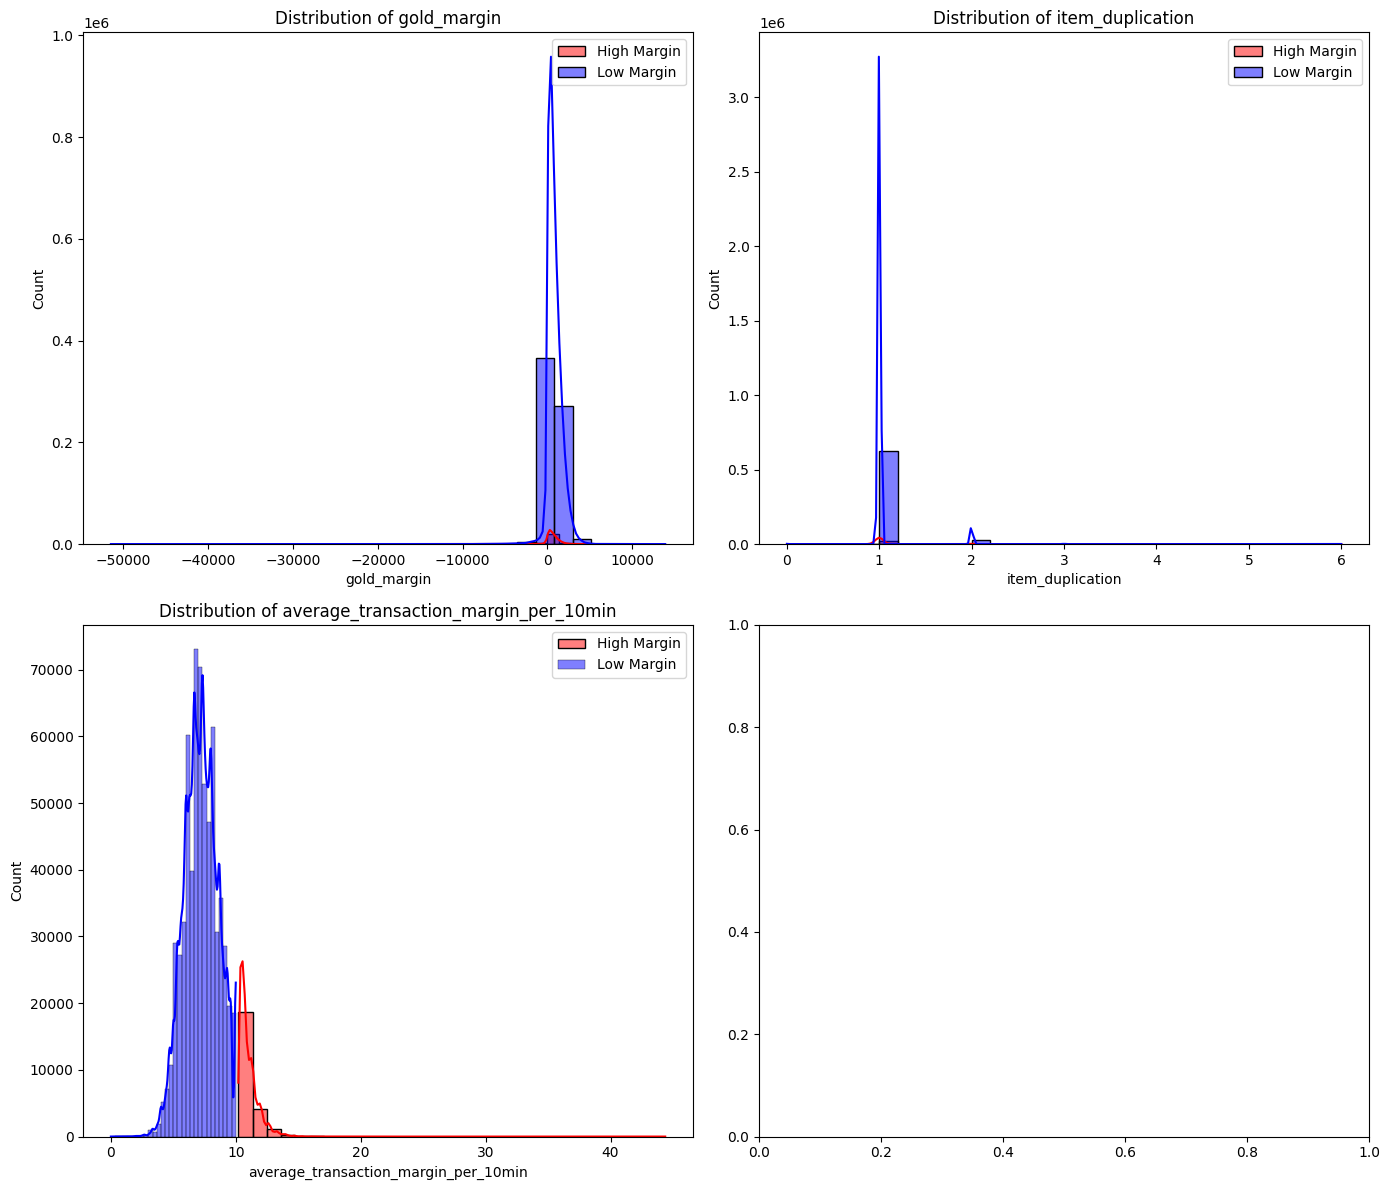

Comparison of High and Low Margin Users


,High Margin Users,Low Margin Users
gold_margin,601.289765,846.576278
item_duplication,1.052430,1.039424
average_transaction_margin_per_10min,11.041251,7.202814


In [144]:
selected_columns = ['gold_margin', 'item_duplication', 'average_transaction_margin_per_10min']

# 각 그룹의 평균 값 계산
high_margin_means = high_margin_users[selected_columns].mean()
low_margin_means = low_margin_users[selected_columns].mean()

# 결과 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for i, col in enumerate(selected_columns):
    sns.histplot(high_margin_users[col], bins=30, kde=True, ax=axes[i // 2, i % 2], color='red', label='High Margin')
    sns.histplot(low_margin_users[col], bins=30, kde=True, ax=axes[i // 2, i % 2], color='blue', label='Low Margin')
    axes[i // 2, i % 2].set_title(f'Distribution of {col}')
    axes[i // 2, i % 2].legend()

plt.tight_layout()
plt.show()

# 두 그룹의 주요 지표 비교
comparison_stats = pd.DataFrame({
    'High Margin Users': high_margin_means,
    'Low Margin Users': low_margin_means
})

print("Comparison of High and Low Margin Users")
display(comparison_stats)

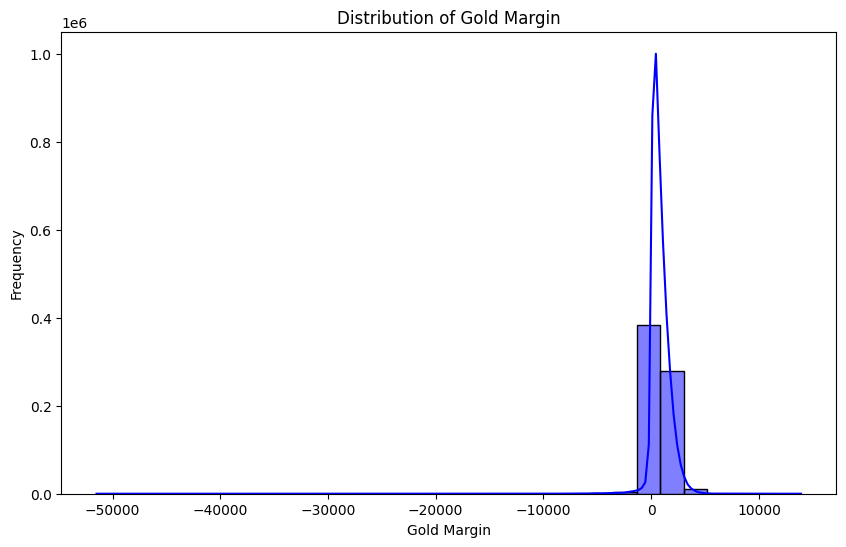

Large Negative Gold Margin Users Stats


,tier,timePlayed,teamId,champion_kills,monster_kills,building_kills,kill_involve_ratio,deaths,cs,champExperience,item_duplication,totalDamageDealtToChampions,damageDealtToObjectives,totalTimeSpentDead,visionScore,abilityUses,skillshotsDodged,laneMinionsFirst10Minutes,alliedJungleMonsterKills,enemyJungleMonsterKills,jungleCsBefore10Minutes,average_transaction_margin_per_10min,delta_attack_stat,delta_attackSpeed,delta_defense_stat,delta_max_health,deathBefore10Minutes,goldBefore10Minutes,level10Minutes,gold_margin,involve_ratio_avg
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,4.169118,40.979412,160.294118,45.794118,6.764706,9.382353,0.511794,9.205882,287.882353,21973.308824,1.014706,46598.720588,22145.397059,365.926471,30.500000,446.676471,71.735294,55.705882,21.073529,5.661765,9.002206,8.519412,9.720588,2.697059,4.020588,57.307353,1.338235,3983.176471,7.338235,-17418.852941,23.012500
std,2.328619,6.648568,49.292626,14.800725,2.643593,4.210964,0.152030,2.970295,87.997885,5483.310459,0.657736,17880.891048,15275.520009,147.133640,14.260372,252.371465,103.721731,27.118347,29.900989,7.103941,20.977928,4.650045,4.415223,1.623427,1.730633,16.533397,1.276776,795.484700,1.001645,6622.768153,18.310831
min,1.000000,19.900000,100.000000,9.000000,2.000000,1.000000,0.098000,2.000000,31.000000,9612.000000,0.000000,9351.000000,1763.000000,50.000000,0.000000,136.000000,2.000000,0.000000,0.000000,0.000000,0.000000,5.100000,2.100000,0.600000,2.000000,36.100000,0.000000,2866.000000,5.000000,-51485.000000,0.000000
25%,2.000000,36.000000,100.000000,37.000000,5.000000,6.000000,0.435000,8.000000,228.750000,18668.000000,1.000000,35022.500000,10273.750000,256.000000,22.000000,249.250000,14.750000,47.750000,2.000000,0.000000,0.000000,7.200000,6.800000,1.275000,3.100000,45.875000,0.000000,3299.500000,7.000000,-18189.750000,8.350000
50%,4.000000,41.900000,200.000000,47.000000,6.500000,9.500000,0.520000,9.000000,291.500000,22741.000000,1.000000,48912.000000,19420.000000,356.500000,27.000000,393.000000,32.500000,67.000000,8.500000,3.000000,0.000000,7.790000,9.200000,2.300000,3.600000,52.150000,1.000000,3908.500000,7.000000,-14942.500000,17.400000
75%,6.000000,45.825000,200.000000,56.000000,8.250000,13.000000,0.597000,11.000000,333.500000,25839.750000,1.000000,59909.750000,29584.000000,455.250000,37.250000,562.500000,89.000000,74.000000,22.250000,9.250000,0.000000,8.825000,11.550000,3.925000,4.325000,63.250000,2.000000,4407.500000,8.000000,-13749.250000,34.862500
max,9.000000,52.500000,200.000000,77.000000,13.000000,18.000000,0.889000,15.000000,552.000000,30802.000000,6.000000,91781.000000,76258.000000,702.000000,82.000000,1218.000000,610.000000,86.000000,141.000000,33.000000,69.750000,44.380000,26.000000,6.100000,10.500000,113.700000,4.000000,6345.000000,9.000000,-12435.000000,69.450000



Mean of Average Transaction Margin per 10min for Large Negative Gold Margin Users: 8.52

Normal Users Stats


,tier,timePlayed,teamId,champion_kills,monster_kills,building_kills,kill_involve_ratio,deaths,cs,champExperience,item_duplication,totalDamageDealtToChampions,damageDealtToObjectives,totalTimeSpentDead,visionScore,abilityUses,skillshotsDodged,laneMinionsFirst10Minutes,alliedJungleMonsterKills,enemyJungleMonsterKills,jungleCsBefore10Minutes,average_transaction_margin_per_10min,delta_attack_stat,delta_attackSpeed,delta_defense_stat,delta_max_health,deathBefore10Minutes,goldBefore10Minutes,level10Minutes,gold_margin,involve_ratio_avg
count,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000,677902.000000
mean,5.369904,26.705557,149.998967,27.006250,5.011314,5.936842,0.469181,5.402813,151.049466,12259.542306,1.039892,18333.273225,10826.490794,140.615110,29.028708,251.643252,34.043390,42.517472,13.375517,2.528193,11.196161,7.340053,10.036084,3.059616,4.413956,71.334738,1.583779,3399.498419,7.011308,839.630072,16.429481
std,2.654699,6.927600,50.000037,11.897757,2.912685,4.496688,0.170343,3.107357,78.259087,4455.352697,0.214939,11519.205639,12674.782629,100.817252,23.726197,167.577701,55.011674,30.274862,25.752326,5.680135,22.653812,1.503302,4.775996,2.563023,2.453624,22.199301,1.290129,669.005174,1.043527,870.153213,19.770140
min,1.000000,10.100000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.800000,-3.100000,-1.300000,0.000000,0.000000,1500.000000,1.000000,-12360.000000,0.000000
25%,3.000000,21.900000,100.000000,18.000000,3.000000,2.000000,0.355000,3.000000,102.000000,8907.000000,1.000000,9596.000000,1928.000000,63.000000,14.000000,140.000000,7.000000,10.000000,0.000000,0.000000,0.000000,6.300000,7.100000,1.200000,2.800000,55.800000,1.000000,2940.000000,6.000000,307.000000,0.000000
50%,5.000000,26.700000,100.000000,27.000000,5.000000,5.000000,0.474000,5.000000,160.000000,12040.000000,1.000000,15972.000000,5947.000000,124.000000,22.000000,210.000000,16.000000,53.000000,0.000000,0.000000,0.000000,7.270000,9.600000,2.000000,3.700000,66.300000,1.000000,3358.000000,7.000000,694.000000,8.350000
75%,8.000000,31.200000,200.000000,35.000000,7.000000,10.000000,0.587000,7.000000,205.000000,15192.000000,1.000000,24434.000000,15141.000000,199.000000,34.000000,313.000000,38.000000,69.000000,7.000000,2.000000,0.000000,8.260000,12.500000,4.500000,5.100000,81.800000,2.000000,3807.000000,8.000000,1267.000000,25.400000
max,10.000000,62.700000,200.000000,82.000000,15.000000,23.000000,1.000000,28.000000,694.000000,45990.000000,6.000000,166916.000000,128259.000000,1026.000000,298.000000,2137.000000,1198.000000,112.000000,207.000000,98.000000,105.000000,43.750000,55.500000,52.100000,56.100000,335.500000,12.000000,8957.000000,10.000000,13910.000000,100.000000



Mean of Average Transaction Margin per 10min for Normal Users: 7.34


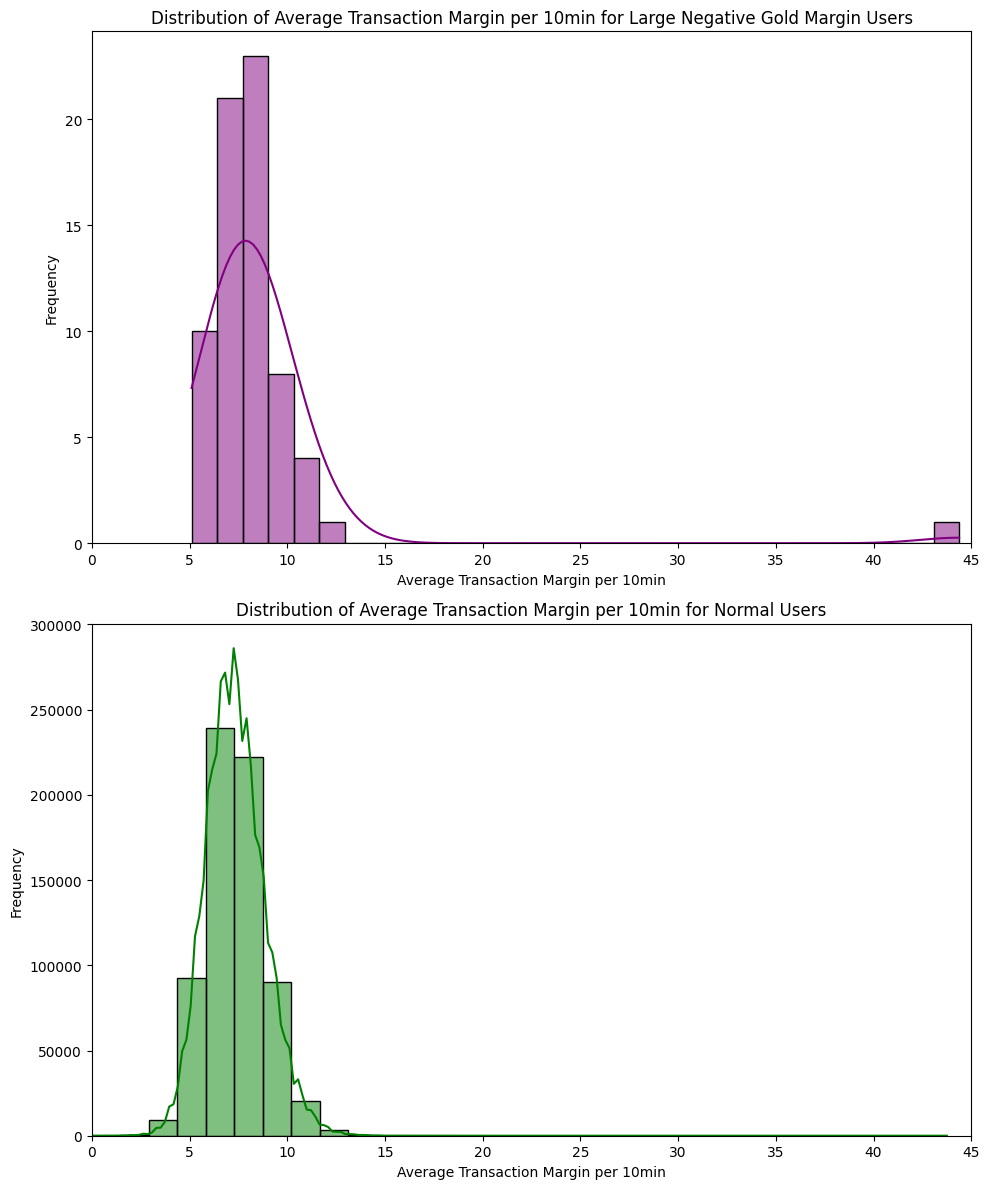

In [145]:
# gold_margin 값의 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(normal_df['gold_margin'], bins=30, kde=True, color='blue')
plt.title('Distribution of Gold Margin')
plt.xlabel('Gold Margin')
plt.ylabel('Frequency')
plt.show()

# gold_margin이 음수 쪽으로 큰 값 (상위 0.01% 절대값이 큰 음수 데이터) 필터링
threshold = normal_df['gold_margin'].quantile(0.0001)
large_negative_gold_margin = normal_df[normal_df['gold_margin'] < threshold]

# 정상 유저 데이터 필터링 (gold_margin이 음수가 아닌 경우)
normal_users = normal_df[normal_df['gold_margin'] >= threshold]

# 필터링된 데이터의 주요 지표 통계 분석
large_negative_gold_margin_stats = large_negative_gold_margin.describe()
normal_users_stats = normal_users.describe()

# average_transaction_margin_per_10min의 평균 계산
average_transaction_margin_mean_anomalous = large_negative_gold_margin['average_transaction_margin_per_10min'].mean()
average_transaction_margin_mean_normal = normal_users['average_transaction_margin_per_10min'].mean()

# 결과 출력
print("Large Negative Gold Margin Users Stats")
display(large_negative_gold_margin_stats)
print(f"\nMean of Average Transaction Margin per 10min for Large Negative Gold Margin Users: {average_transaction_margin_mean_anomalous:.2f}")
print("\nNormal Users Stats")
display(normal_users_stats)
print(f"\nMean of Average Transaction Margin per 10min for Normal Users: {average_transaction_margin_mean_normal:.2f}")

# 히스토그램 시각화
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

sns.histplot(large_negative_gold_margin['average_transaction_margin_per_10min'], bins=30, kde=True, color='purple', ax=axes[0])
axes[0].set_xlim(0, 45)
axes[0].set_title('Distribution of Average Transaction Margin per 10min for Large Negative Gold Margin Users')
axes[0].set_xlabel('Average Transaction Margin per 10min')
axes[0].set_ylabel('Frequency')

sns.histplot(normal_users['average_transaction_margin_per_10min'], bins=30, kde=True, color='green', ax=axes[1])
axes[1].set_xlim(0, 45)
axes[1].set_title('Distribution of Average Transaction Margin per 10min for Normal Users')
axes[1].set_xlabel('Average Transaction Margin per 10min')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Chi-squared test statistic: 6.852925199102705
p-value: 0.008849626270753088


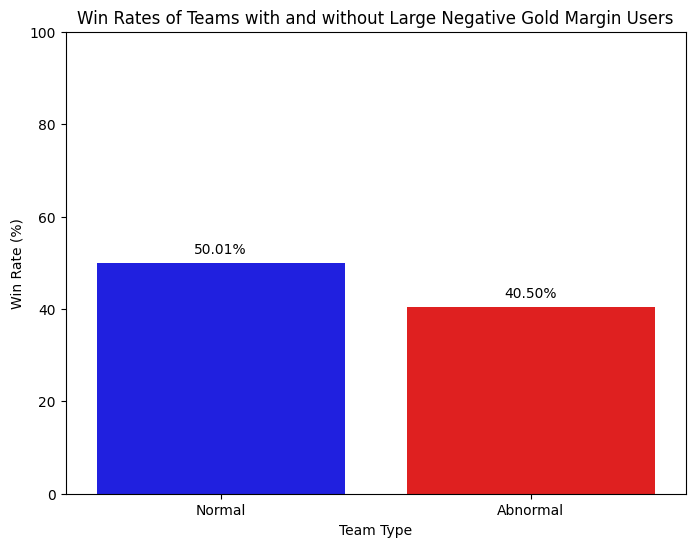

In [146]:
# gold_margin이 음수 쪽으로 큰 값 (상위 0.03% 절대값이 큰 음수 데이터) 필터링
threshold = normal_df['gold_margin'].quantile(0.0003)
large_negative_gold_margin_users = normal_df[normal_df['gold_margin'] < threshold]

# gold_margin이 큰 유저가 속한 팀 식별
teams_with_large_negative_gold_margin_users = large_negative_gold_margin_users[['match_id', 'teamId']].drop_duplicates()
teams_with_large_negative_gold_margin_users['has_large_negative_gold_margin'] = True

# 팀 단위 승리 정보와 합치기
team_results = normal_df.groupby(['match_id', 'teamId'])['win'].first().reset_index()
team_results = team_results.merge(teams_with_large_negative_gold_margin_users, on=['match_id', 'teamId'], how='left')
team_results['has_large_negative_gold_margin'].fillna(False, inplace=True)

# 비정상 유저가 있는 팀과 없는 팀 분리
teams_with_abnormal = team_results[team_results['has_large_negative_gold_margin'] == True]
teams_without_abnormal = team_results[team_results['has_large_negative_gold_margin'] == False]

# 승리와 패배 횟수 집계
win_counts = pd.DataFrame({
    'win': [teams_without_abnormal['win'].sum(), teams_with_abnormal['win'].sum()],
    'total': [teams_without_abnormal.shape[0], teams_with_abnormal.shape[0]]
}, index=['Normal', 'Abnormal'])

# 승률 계산
win_counts['win_rate'] = win_counts['win'] / win_counts['total'] * 100

# 카이제곱 검정 수행
chi2, p, _, _ = chi2_contingency([win_counts['win'], win_counts['total'] - win_counts['win']])

# 결과 출력
print("Chi-squared test statistic:", chi2)
print("p-value:", p)

# 승률 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=win_counts.index, y=win_counts['win_rate'], palette=['blue', 'red'])
plt.title('Win Rates of Teams with and without Large Negative Gold Margin Users')
plt.ylabel('Win Rate (%)')
plt.xlabel('Team Type')
plt.ylim(0, 100)

# 승률 값 표시
for i in range(len(win_counts)):
    plt.text(i, win_counts['win_rate'][i] + 2, f"{win_counts['win_rate'][i]:.2f}%", ha='center')

plt.show()

Item duplication 0: Win rate 26.09%
Item duplication 1: Win rate 51.85%
Item duplication 2: Win rate 41.91%
Item duplication 3: Win rate 26.00%
Item duplication 4: Win rate 25.71%
Item duplication 5: Win rate 19.05%
Item duplication 6: Win rate 22.93%
Item duplication 0: Chi-squared test statistic 368.13, p-value 0.000000
Item duplication 1: Chi-squared test statistic 4312.05, p-value 0.000000
Item duplication 2: Chi-squared test statistic 3685.40, p-value 0.000000
Item duplication 3: Chi-squared test statistic 487.61, p-value 0.000000
Item duplication 4: Chi-squared test statistic 40.33, p-value 0.000000
Item duplication 5: Chi-squared test statistic 79.26, p-value 0.000000
Item duplication 6: Chi-squared test statistic 229.25, p-value 0.000000


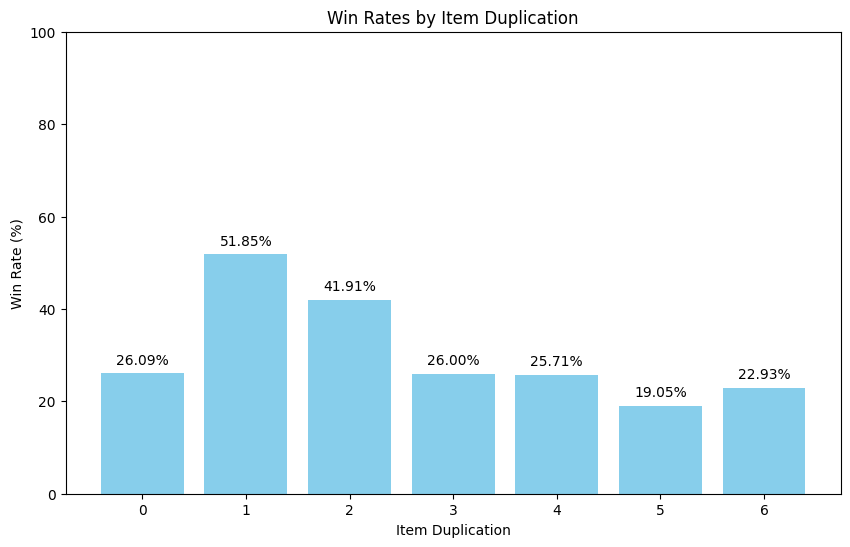

In [149]:
# 각 item_duplication 값이 있는 팀의 승률 계산 및 통계적 검정
item_duplication_values = [0, 1, 2, 3, 4, 5, 6]
win_rates = []
chi2_results = []

for value in item_duplication_values:
    if value == 1:
        teams_with_value = normal_df.groupby(['match_id', 'teamId'])['item_duplication'].apply(lambda x: (x == 1).all()).reset_index()
        teams_with_value = teams_with_value[teams_with_value['item_duplication'] == True]
        teams_with_value['has_item_duplication'] = True
    else:
        teams_with_value = normal_df[normal_df['item_duplication'] == value][['match_id', 'teamId']].drop_duplicates()
        teams_with_value['has_item_duplication'] = True

    team_results = normal_df.merge(teams_with_value, on=['match_id', 'teamId'], how='left')
    team_results['has_item_duplication'].fillna(False, inplace=True)

    teams_with_value_results = team_results[team_results['has_item_duplication'] == True]
    teams_without_value_results = team_results[team_results['has_item_duplication'] == False]

    win_rate_with_value = teams_with_value_results['win'].mean() * 100
    win_rate_without_value = teams_without_value_results['win'].mean() * 100
    win_rates.append(win_rate_with_value)

    # 카이제곱 검정
    contingency_table = [
        [teams_with_value_results['win'].sum(), len(teams_with_value_results) - teams_with_value_results['win'].sum()],
        [teams_without_value_results['win'].sum(), len(teams_without_value_results) - teams_without_value_results['win'].sum()]
    ]
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results.append((value, chi2, p))

# 결과 출력
for value, win_rate in zip(item_duplication_values, win_rates):
    print(f"Item duplication {value}: Win rate {win_rate:.2f}%")

for value, chi2, p in chi2_results:
    print(f"Item duplication {value}: Chi-squared test statistic {chi2:.2f}, p-value {p:.6f}")

# 승률 시각화
plt.figure(figsize=(10, 6))
plt.bar(item_duplication_values, win_rates, color='skyblue')
plt.title('Win Rates by Item Duplication')
plt.xlabel('Item Duplication')
plt.ylabel('Win Rate (%)')
plt.ylim(0, 100)

# 각 막대 위에 승률 값 표시
for i, win_rate in enumerate(win_rates):
    plt.text(i, win_rate + 2, f"{win_rate:.2f}%", ha='center')

plt.show()

Win rate with abnormal users: 24.77%
Win rate without abnormal users: 50.10%
Chi-squared test statistic: 705.59, p-value: 0.000000


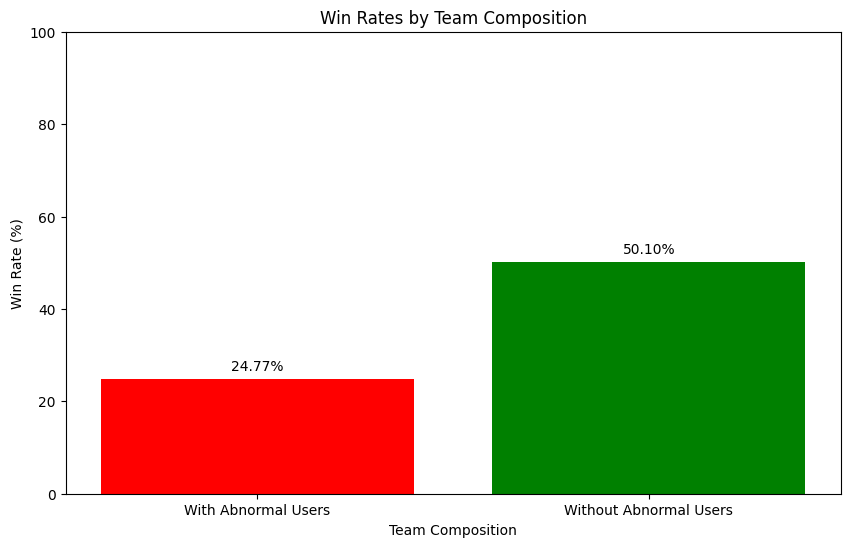

In [164]:
# 비정상 유저 판별
normal_df['item_abnormal'] = normal_df['item_duplication'].apply(lambda x: x in [0, 4, 5, 6])

# 비정상 유저가 속한 팀과 그렇지 않은 팀을 구분
teams_with_abnormal = normal_df[normal_df['item_abnormal'] == True][['match_id', 'teamId']].drop_duplicates()
teams_with_abnormal['has_abnormal'] = True

team_results = normal_df.merge(teams_with_abnormal, on=['match_id', 'teamId'], how='left')
team_results['has_abnormal'].fillna(False, inplace=True)

# 비정상 유저가 속한 팀과 그렇지 않은 팀 분리
teams_with_abnormal_results = team_results[team_results['has_abnormal'] == True]
teams_without_abnormal_results = team_results[team_results['has_abnormal'] == False]

# 승률 계산
win_rate_with_abnormal = teams_with_abnormal_results['win'].mean() * 100
win_rate_without_abnormal = teams_without_abnormal_results['win'].mean() * 100

# 카이제곱 검정
contingency_table = [
    [teams_with_abnormal_results['win'].sum(), len(teams_with_abnormal_results) - teams_with_abnormal_results['win'].sum()],
    [teams_without_abnormal_results['win'].sum(), len(teams_without_abnormal_results) - teams_without_abnormal_results['win'].sum()]
]
chi2, p, _, _ = chi2_contingency(contingency_table)

# 결과 출력
print(f"Win rate with abnormal users: {win_rate_with_abnormal:.2f}%")
print(f"Win rate without abnormal users: {win_rate_without_abnormal:.2f}%")
print(f"Chi-squared test statistic: {chi2:.2f}, p-value: {p:.6f}")

# 승률 시각화
plt.figure(figsize=(10, 6))
labels = ['With Abnormal Users', 'Without Abnormal Users']
win_rates = [win_rate_with_abnormal, win_rate_without_abnormal]

plt.bar(labels, win_rates, color=['red', 'green'])
plt.title('Win Rates by Team Composition')
plt.xlabel('Team Composition')
plt.ylabel('Win Rate (%)')
plt.ylim(0, 100)

# 각 막대 위에 승률 값 표시
for i, win_rate in enumerate(win_rates):
    plt.text(i, win_rate + 2, f"{win_rate:.2f}%", ha='center')

plt.show()

AFK rate for abnormal users: 1.07%
AFK rate for normal users: 0.21%
Chi-squared test statistic: 16.32, p-value: 0.000054


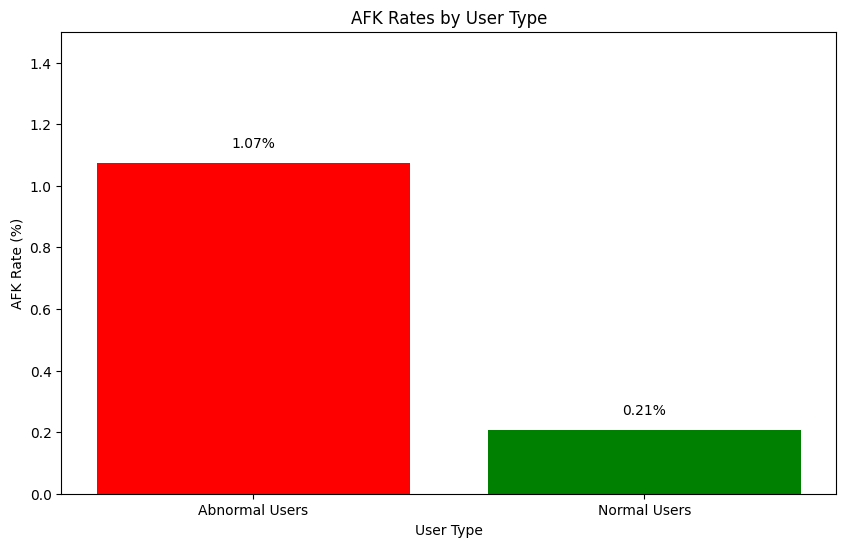

In [168]:
# 비정상 유저 판별
normal_df['abnormal'] = normal_df['item_duplication'].apply(lambda x: x in [0, 4, 5, 6])

# 정상 유저와 비정상 유저의 AFK 비율 계산
abnormal_users = normal_df[normal_df['abnormal'] == True]
normal_users = normal_df[normal_df['abnormal'] == False]

afk_rate_abnormal = abnormal_users['afk'].mean() * 100
afk_rate_normal = normal_users['afk'].mean() * 100

print(f"AFK rate for abnormal users: {afk_rate_abnormal:.2f}%")
print(f"AFK rate for normal users: {afk_rate_normal:.2f}%")

# 통계적 검정 (카이제곱 검정)
contingency_table = [
    [abnormal_users['afk'].sum(), len(abnormal_users) - abnormal_users['afk'].sum()],
    [normal_users['afk'].sum(), len(normal_users) - normal_users['afk'].sum()]
]
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-squared test statistic: {chi2:.2f}, p-value: {p:.6f}")

# AFK 비율 시각화
plt.figure(figsize=(10, 6))
labels = ['Abnormal Users', 'Normal Users']
afk_rates = [afk_rate_abnormal, afk_rate_normal]

plt.bar(labels, afk_rates, color=['red', 'green'])
plt.title('AFK Rates by User Type')
plt.xlabel('User Type')
plt.ylabel('AFK Rate (%)')
plt.ylim(0, 1.5)  # y축 범위 조정

# 각 막대 위에 AFK 비율 값 표시
for i, afk_rate in enumerate(afk_rates):
    plt.text(i, afk_rate + 0.05, f"{afk_rate:.2f}%", ha='center')

plt.show()

# Smite Liner

Chi-squared test statistic: 34.41866392634811
p-value: 4.444409046186066e-09


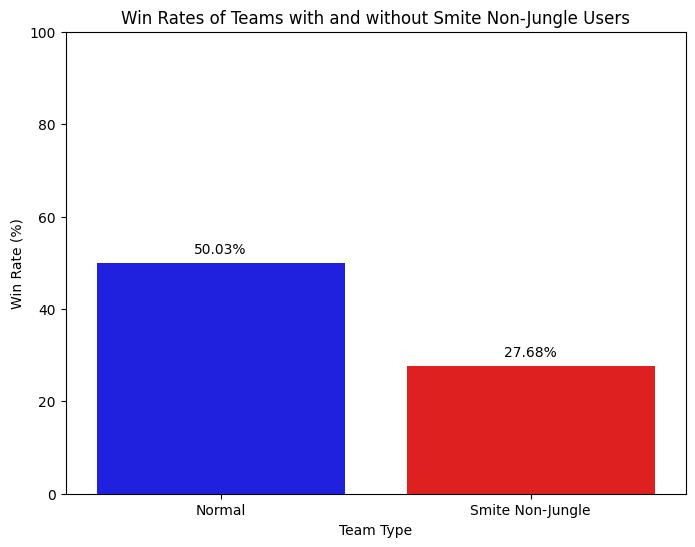

In [68]:
# 정글 포지션이 아닌 유저 필터링 (예: top, mid, bot, support)
non_jungle_users = normal_df[normal_df['teamPosition']!='JUNGLE']

# Smite를 든 유저 필터링 (summoner1Id 또는 summoner2Id가 Smite인 경우)
smite_users = non_jungle_users[(non_jungle_users['summoner1Id'] == 'Smite') | (non_jungle_users['summoner2Id'] == 'Smite')]

# Smite를 든 유저가 속한 팀 식별
teams_with_smite_non_jungle = smite_users[['match_id', 'teamId']].drop_duplicates()
teams_with_smite_non_jungle['has_smite_non_jungle'] = True

# 팀 단위 승리 정보와 합치기
team_results = normal_df.groupby(['match_id', 'teamId'])['win'].first().reset_index()
team_results = team_results.merge(teams_with_smite_non_jungle, on=['match_id', 'teamId'], how='left')
team_results['has_smite_non_jungle'].fillna(False, inplace=True)

# Smite를 든 비정상 유저가 있는 팀과 없는 팀 분리
teams_with_smite_non_jungle = team_results[team_results['has_smite_non_jungle'] == True]
teams_without_smite_non_jungle = team_results[team_results['has_smite_non_jungle'] == False]

# 승리와 패배 횟수 집계
win_counts = pd.DataFrame({
    'win': [teams_without_smite_non_jungle['win'].sum(), teams_with_smite_non_jungle['win'].sum()],
    'total': [teams_without_smite_non_jungle.shape[0], teams_with_smite_non_jungle.shape[0]]
}, index=['Normal', 'Smite Non-Jungle'])

# 승률 계산
win_counts['win_rate'] = win_counts['win'] / win_counts['total'] * 100

# 카이제곱 검정 수행
chi2, p, _, _ = chi2_contingency([win_counts['win'], win_counts['total'] - win_counts['win']])

# 결과 출력
print("Chi-squared test statistic:", chi2)
print("p-value:", p)

# 승률 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=win_counts.index, y=win_counts['win_rate'], palette=['blue', 'red'])
plt.title('Win Rates of Teams with and without Smite Non-Jungle Users')
plt.ylabel('Win Rate (%)')
plt.xlabel('Team Type')
plt.ylim(0, 100)

# 승률 값 표시
for i in range(len(win_counts)):
    plt.text(i, win_counts['win_rate'][i] + 2, f"{win_counts['win_rate'][i]:.2f}%", ha='center')

plt.show()

Chi-squared test statistic: 9.616630721061698
p-value: 0.0019282316615979957


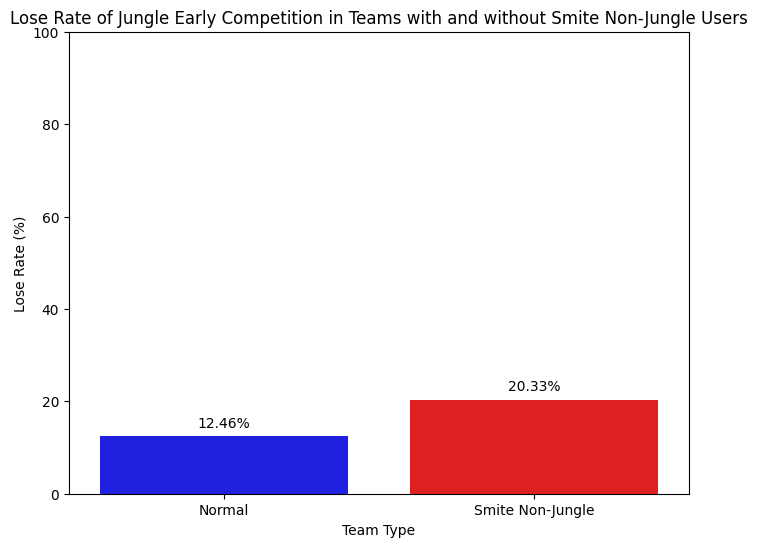

In [107]:
# 정글 포지션이 아닌 유저 필터링 (예: top, mid, bot, support)
non_jungle_users = normal_df[normal_df['teamPosition']!='JUNGLE']

# Smite를 든 유저 필터링 (summoner1Id 또는 summoner2Id가 Smite인 경우)
smite_users = non_jungle_users[(non_jungle_users['summoner1Id'] == 'Smite') | (non_jungle_users['summoner2Id'] == 'Smite')]

# Smite를 든 유저가 속한 팀 식별
teams_with_smite_non_jungle = smite_users[['match_id', 'teamId']].drop_duplicates()
teams_with_smite_non_jungle['has_smite_non_jungle'] = True

# 팀 단위로 정글러 데이터 필터링
jungle_users = normal_df[normal_df['teamPosition'] == 'JUNGLE']

# 팀 단위 승리 정보와 합치기
jungle_team_results = jungle_users.merge(teams_with_smite_non_jungle, on=['match_id', 'teamId'], how='left')
jungle_team_results['has_smite_non_jungle'].fillna(False, inplace=True)

# Smite를 든 비정상 유저가 있는 팀과 없는 팀 분리
jungle_with_smite_non_jungle = jungle_team_results[jungle_team_results['has_smite_non_jungle'] == True]
jungle_without_smite_non_jungle = jungle_team_results[jungle_team_results['has_smite_non_jungle'] == False]

# early_competition이 Lose인 비율 계산
lose_counts = pd.DataFrame({
    'early_competition_lose': [jungle_without_smite_non_jungle['early_competition'].value_counts().get('lose', 0),
                               jungle_with_smite_non_jungle['early_competition'].value_counts().get('lose', 0)],
    'total': [jungle_without_smite_non_jungle.shape[0], jungle_with_smite_non_jungle.shape[0]]
}, index=['Normal', 'Smite Non-Jungle'])

lose_counts['lose_rate'] = lose_counts['early_competition_lose'] / lose_counts['total'] * 100

# 카이제곱 검정 수행
chi2, p, _, _ = chi2_contingency([lose_counts['early_competition_lose'], lose_counts['total'] - lose_counts['early_competition_lose']])

# 결과 출력
print("Chi-squared test statistic:", chi2)
print("p-value:", p)

# 비율 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=lose_counts.index, y=lose_counts['lose_rate'], palette=['blue', 'red'])
plt.title('Lose Rate of Jungle Early Competition in Teams with and without Smite Non-Jungle Users')
plt.ylabel('Lose Rate (%)')
plt.xlabel('Team Type')
plt.ylim(0, 100)

# 비율 값 표시
for i in range(len(lose_counts)):
    plt.text(i, lose_counts['lose_rate'][i] + 2, f"{lose_counts['lose_rate'][i]:.2f}%", ha='center')

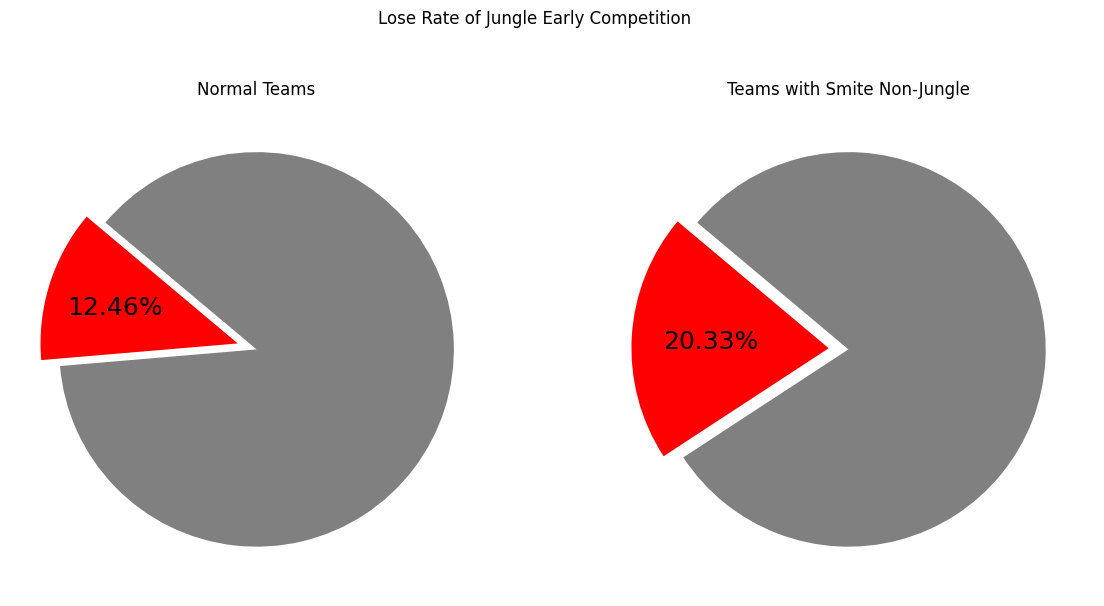

In [108]:
# 파이차트 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

colors = ['red', 'gray']

# Normal 팀 파이차트
wedges, texts = axes[0].pie([lose_counts.loc['Normal', 'early_competition_lose'], lose_counts.loc['Normal', 'total'] - lose_counts.loc['Normal', 'early_competition_lose']],
                            colors=colors, startangle=140, explode=[0.1, 0], labels=['', ''])
# 강조된 부분에 비율 텍스트 추가
for i, wedge in enumerate(wedges):
    if i == 0:  # 강조된 부분
        ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
        x = np.cos(np.radians(ang))
        y = np.sin(np.radians(ang))
        axes[0].text(x*0.75, y*0.70, f"{(lose_counts.loc['Normal', 'early_competition_lose'] / lose_counts.loc['Normal', 'total'] * 100):.2f}%", 
                     ha='center', va='center', fontsize=18, color='black')

axes[0].set_title('Normal Teams')

# Smite Non-Jungle 팀 파이차트
wedges, texts = axes[1].pie([lose_counts.loc['Smite Non-Jungle', 'early_competition_lose'], lose_counts.loc['Smite Non-Jungle', 'total'] - lose_counts.loc['Smite Non-Jungle', 'early_competition_lose']],
                            colors=colors, startangle=140, explode=[0.1, 0], labels=['', ''])
# 강조된 부분에 비율 텍스트 추가
for i, wedge in enumerate(wedges):
    if i == 0:  # 강조된 부분
        ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
        x = np.cos(np.radians(ang))
        y = np.sin(np.radians(ang))
        axes[1].text(x*0.7, y*0.65, f"{(lose_counts.loc['Smite Non-Jungle', 'early_competition_lose'] / lose_counts.loc['Smite Non-Jungle', 'total'] * 100):.2f}%", 
                     ha='center', va='center', fontsize=18, color='black')

axes[1].set_title('Teams with Smite Non-Jungle')

plt.suptitle('Lose Rate of Jungle Early Competition')
plt.show()